In [1]:
import numpy as np
import pandas as pd
import gzip
from os import listdir
from os.path import split
import matplotlib.pyplot as plt
rcParams = {'font.size': 24 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
import scipy.cluster.hierarchy as sch
from copy import deepcopy
from scipy.spatial.distance import squareform

plt.rcParams.update(rcParams)

def Return_Gene_Orders(gbff_filepath):
    head, tail = split(gbff_filepath)
    df = pd.read_csv(gbff_filepath, sep = '\t',usecols = ['Start','End','locus_tag','gene'])
    df.loc[df['gene'].isna(), 'gene'] = df.loc[df['gene'].isna(), 'locus_tag']
    df['Mask'] = df['gene']!=df['locus_tag']
    df = df.sort_values(by = ['Start'])
    print(df)
    gene_list = df['gene'].tolist()
    mask = df['Mask'].tolist()
    return np.array(gene_list), np.array(mask)

def Get_Gene_Counts(gene_dict):
    ctr = 0
    gene_count_dict = {}
    gene_set = set()
    print(len(gene_dict))
    for g in gene_dict:
        print(ctr, g)
        ctr += 1
        
        gene_orders, mask = gene_dict[g]
        gene_set = gene_set.union(set(gene_orders))
        mask_index = np.where(mask == True)
        gene_orders = list(gene_orders[mask_index[0]])
        for gene in set(gene_orders):
            try:
                gene_count_dict[gene]['Counts'] += 1
                if gene_orders.count(gene) > 1:
                    gene_count_dict[gene]['Multi_Copies'] += 1
                    gene_count_dict[gene]['Genome_Multi_Copies'].append(g)
                elif gene_orders.count(gene) == 1:
                    gene_count_dict[gene]['Single_Copies'] += 1
            except KeyError:
                gene_count_dict[gene] = {'Counts':1, 'Multi_Copies':0,'Single_Copies':0}
                if gene_orders.count(gene) > 1:
                    gene_count_dict[gene]['Multi_Copies'] = 1
                    gene_count_dict[gene]['Genome_Multi_Copies'] = [g]
                elif gene_orders.count(gene) == 1:
                    gene_count_dict[gene]['Single_Copies'] =1
    df_Gene_Counts = pd.DataFrame(gene_count_dict)
    df_Gene_Counts = df_Gene_Counts.T
    df_Gene_Counts.index.name = 'Gene'
    sample_specific_genes = gene_set - set(df_Gene_Counts.index.tolist())
    df_Gene_Counts = df_Gene_Counts.reset_index()
    df_temp = pd.DataFrame(data = {'Gene':list(sample_specific_genes)})
    df_temp['Counts'] = 1
    df_temp['Multi_Copies'] = 0
    df_temp['Single_Copies'] = 1
    #df_temp['Genome_Multi_Copies'] = [[]]
    df_Gene_Counts = df_Gene_Counts.append(df_temp, ignore_index = True)
    df_Gene_Counts = df_Gene_Counts.set_index('Gene')
    return df_Gene_Counts

In [2]:
gene_orders = {}
filepath = '../Data/Processed_GBFF/'
samples = listdir(filepath)
ctr = 0
for f in samples:
    print(ctr, f)
    if f.startswith('GCF'):
        sample_id = f.replace("_genomic.txt.gz","")
        ctr += 1
        genes, mask = Return_Gene_Orders(filepath+f)
        gene_orders[sample_id] = (genes, mask)
        

0 GCF_900475675.1_45473_D02_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1356           dnaA  DQN23_RS00005   True
1        1515     2651           dnaN  DQN23_RS00010   True
2        3583     3774  DQN23_RS00020  DQN23_RS00020  False
3        3879     4994           ychF  DQN23_RS00025   True
4        5070     5639  DQN23_RS00030  DQN23_RS00030  False
...       ...      ...            ...            ...    ...
1557  1783987  1785609  DQN23_RS08975  DQN23_RS08975  False
1558  1785704  1788280  DQN23_RS08980  DQN23_RS08980  False
1559  1790524  1791003           rlmH  DQN23_RS09005   True
1560  1791218  1792468  DQN23_RS09010  DQN23_RS09010  False
1561  1792536  1793318  DQN23_RS09015  DQN23_RS09015  False

[1562 rows x 5 columns]
1 GCF_005160405.1_ASM516040v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
4902        1     6768  E5O17_RS26215  E5O17_RS26215  False
5012        1      816  E5O17_RS26855  E5O17_RS

        Start      End           gene      locus_tag   Mask
0        4147     7971           fenB  DIC78_RS00010   True
1        8095     8487  DIC78_RS00015  DIC78_RS00015  False
2        8632    10167  DIC78_RS00020  DIC78_RS00020  False
3       10495    10725  DIC78_RS00030  DIC78_RS00030  False
4       10805    11947  DIC78_RS00035  DIC78_RS00035  False
...       ...      ...            ...            ...    ...
3999  4121528  4122502  DIC78_RS21470  DIC78_RS21470  False
4000  4122529  4124004           dacB  DIC78_RS21475   True
4001  4124437  4132119           fenC  DIC78_RS21480   True
4002  4132145  4139860           fenD  DIC78_RS21485   True
4003  4139877  4147541           fenE  DIC78_RS21490   True

[4004 rows x 5 columns]
14 GCF_002262995.1_ASM226299v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         800     1045  CJP70_RS00015  CJP70_RS00015  False
1        1045     1359  CJP70_RS00020  CJP70_RS00020  False
1932     1486     2679  CJP70

        Start      End      locus_tag           gene   Mask
0         816     4649  BSA41_RS00010  BSA41_RS00010  False
1        4712    14845  BSA41_RS00015  BSA41_RS00015  False
2       14859    23054  BSA41_RS00020  BSA41_RS00020  False
3       23061    23801  BSA41_RS00025  BSA41_RS00025  False
4       23832    24371  BSA41_RS00030  BSA41_RS00030  False
...       ...      ...            ...            ...    ...
3702  3710072  3711157  BSA41_RS19390  BSA41_RS19390  False
3703  3711166  3712257  BSA41_RS19395  BSA41_RS19395  False
3704  3712257  3713126  BSA41_RS19400  BSA41_RS19400  False
3705  3713119  3713922  BSA41_RS19405  BSA41_RS19405  False
3706  3714528  3725234  BSA41_RS19410  BSA41_RS19410  False

[3707 rows x 5 columns]
29 GCF_016889765.1_ASM1688976v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         676     1983  I6J26_RS00005  I6J26_RS00005  False
1        2046     3713  I6J26_RS00010  I6J26_RS00010  False
2        3790     4584  I6J2

        Start      End           gene      locus_tag   Mask
0           1     1329           dnaA  FPK90_RS00010   True
1        1606     2706           dnaN  FPK90_RS00015   True
4323     2554     2973  FPK90_RS24315  FPK90_RS24315  False
4324     2973     3212  FPK90_RS24320  FPK90_RS24320  False
4325     3424     4347  FPK90_RS24325  FPK90_RS24325  False
...       ...      ...            ...            ...    ...
4318  5357278  5358618           mnmE  FPK90_RS24275   True
4319  5358776  5361478  FPK90_RS24280  FPK90_RS24280  False
4320  5361564  5363288           yidC  FPK90_RS24285   True
4321  5363314  5363751           rnpA  FPK90_RS24290   True
4322  5363790  5363930           rpmH  FPK90_RS24295   True

[4386 rows x 5 columns]
41 GCF_900236405.1_Bru_genome13_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
1931      120      329  C0M11_RS10945  C0M11_RS10945  False
0         192     1217  C0M11_RS00005  C0M11_RS00005  False
1932      316      993  C0M1

        Start      End           gene      locus_tag   Mask
3129        1      657           glnP  I5286_RS16410   True
5511        1     3207  I5286_RS28815  I5286_RS28815  False
0         112     1686           dnaA  I5286_RS00005   True
3130      675     1397           glnQ  I5286_RS16415   True
3131     1407     2474  I5286_RS16420  I5286_RS16420  False
...       ...      ...            ...            ...    ...
3124  3673637  3675037           mnmE  I5286_RS16380   True
3125  3675385  3675807  I5286_RS16385  I5286_RS16385  False
3126  3677589  3677819           yidD  I5286_RS16395   True
3127  3677893  3678393           rnpA  I5286_RS16400   True
3128  3678429  3678563           rpmH  I5286_RS16405   True

[7246 rows x 5 columns]
52 GCF_001890445.1_ASM189044v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  A8180_RS00005   True
1        1406     2506           dnaN  A8180_RS00010   True
2        2654     3727       

        Start      End           gene      locus_tag   Mask
0         448     3021           clpB  ES159_RS00005   True
1        3151     3882           pgeF  ES159_RS00010   True
2        3879     4859           rluD  ES159_RS00015   True
3        4991     5728           bamD  ES159_RS00020   True
4        6002     6337           raiA  ES159_RS00025   True
...       ...      ...            ...            ...    ...
4621  5055522  5056220           tapT  ES159_RS24620   True
4622  5056256  5058931            pat  ES159_RS24625   True
4623  5059028  5060383           pssA  ES159_RS24630   True
4624  5060426  5060749  ES159_RS24635  ES159_RS24635  False
4625  5060752  5062050  ES159_RS24640  ES159_RS24640  False

[4626 rows x 5 columns]
64 GCF_010232785.1_ASM1023278v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         294     1418  F3Y00_RS00005  F3Y00_RS00005  False
1        2221     3462  F3Y00_RS00015  F3Y00_RS00015  False
2        3692     5059  F3Y0

        Start      End      locus_tag           gene   Mask
0          36      254  GQZ26_RS00005  GQZ26_RS00005  False
1         247      720  GQZ26_RS00010  GQZ26_RS00010  False
2         837     1469  GQZ26_RS00015  GQZ26_RS00015  False
5254     1451     1939  GQZ26_RS28390  GQZ26_RS28390  False
5183     1458     2384  GQZ26_RS27980  GQZ26_RS27980  False
...       ...      ...            ...            ...    ...
4971  5243314  5244465  GQZ26_RS26800  GQZ26_RS26800  False
4972  5244638  5244841  GQZ26_RS26805  GQZ26_RS26805  False
4973  5244900  5245712  GQZ26_RS26810  GQZ26_RS26810  False
4974  5245845  5246789  GQZ26_RS26815  GQZ26_RS26815  False
4975  5247010  5248293  GQZ26_RS26820  GQZ26_RS26820  False

[5317 rows x 5 columns]
77 GCF_002999195.2_ASM299919v2_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1398           dnaA  C6N18_RS00930   True
3781        1      951           repM  C6N18_RS00490   True
3688       13     1176  C6N18

        Start      End           gene      locus_tag   Mask
4635        1     1866  E5O07_RS24715  E5O07_RS24715  False
0          13     2475           thrA  E5O07_RS00005   True
4636     1871     4507  E5O07_RS24720  E5O07_RS24720  False
1        2477     3406           thrB  E5O07_RS00010   True
2        3410     4696           thrC  E5O07_RS00015   True
...       ...      ...            ...            ...    ...
4630  4977516  4977830  E5O07_RS24690  E5O07_RS24690  False
4631  4978097  4978813           arcA  E5O07_RS24695   True
4632  4978909  4979049  E5O07_RS24700  E5O07_RS24700  False
4633  4979449  4980135  E5O07_RS24705  E5O07_RS24705  False
4634  4980349  4980414           thrL  E5O07_RS24710   True

[4638 rows x 5 columns]
88 GCF_000770115.1_ASM77011v2_genomic.txt.gz
        Start      End          gene     locus_tag   Mask
3244      957     1859  LA59_RS16760  LA59_RS16760  False
3245     2386     3840          viaA  LA59_RS16770   True
3246     3850     5511  LA59_RS16775

        Start      End           gene      locus_tag   Mask
0           1     1374           dnaA  KLF26_RS00005   True
3006        1      605  KLF26_RS15810  KLF26_RS15810  False
3122        1     2554  KLF26_RS16400  KLF26_RS16400  False
3063      625     1896  KLF26_RS16095  KLF26_RS16095  False
3007     1003     2652  KLF26_RS15815  KLF26_RS15815  False
...       ...      ...            ...            ...    ...
3001  3434424  3435047  KLF26_RS15785  KLF26_RS15785  False
3002  3435089  3435805           yidC  KLF26_RS15790   True
3003  3435839  3436048           yidD  KLF26_RS15795   True
3004  3436020  3436397           rnpA  KLF26_RS15800   True
3005  3436458  3436592           rpmH  KLF26_RS15805   True

[3172 rows x 5 columns]
99 GCF_000585995.1_ASM58599v1_genomic.txt.gz
        Start      End          gene     locus_tag   Mask
0         132     1652          dnaA  CD58_RS00005   True
1        1692     2795          dnaN  CD58_RS00010   True
2        2816     3919          recF

        Start      End           gene      locus_tag   Mask
0           1     1404           dnaA  LD024_RS00005   True
4489        1     1011  LD024_RS23425  LD024_RS23425  False
4560      296      592  LD024_RS23920  LD024_RS23920  False
4480      340     1293  LD024_RS23885  LD024_RS23885  False
4482      546      995  LD024_RS23840  LD024_RS23840  False
...       ...      ...            ...            ...    ...
4472  4926047  4927411           mnmE  LD024_RS23400   True
4473  4927517  4929163           yidC  LD024_RS23405   True
4474  4929166  4929423           yidD  LD024_RS23410   True
4475  4929387  4929746           rnpA  LD024_RS23415   True
4476  4929764  4929904           rpmH  LD024_RS23420   True

[4779 rows x 5 columns]
112 GCF_004028255.1_ASM402825v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1407           dnaA  EPK90_RS00005   True
1        1412     2512           dnaN  EPK90_RS00010   True
2        2658     3743      

       Start      End          gene     locus_tag   Mask
0        148     1143          hemB  CA1H_RS00005   True
1       1159     2577  CA1H_RS00010  CA1H_RS00010  False
2       2600     3034  CA1H_RS00015  CA1H_RS00015  False
3       3147     5300  CA1H_RS00020  CA1H_RS00020  False
4       5450     6643  CA1H_RS00030  CA1H_RS00030  False
..       ...      ...           ...           ...    ...
931  1140002  1140715  CA1H_RS05020  CA1H_RS05020  False
932  1140775  1141389  CA1H_RS05025  CA1H_RS05025  False
933  1141406  1142287  CA1H_RS05030  CA1H_RS05030  False
934  1142392  1142646  CA1H_RS05040  CA1H_RS05040  False
935  1142729  1144321  CA1H_RS05045  CA1H_RS05045  False

[936 rows x 5 columns]
123 GCF_013462275.1_ASM1346227v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
5546        1      567           traE  FDZ05_RS28975   True
5215        1      447  FDZ05_RS27175  FDZ05_RS27175  False
5660        7      897           pcoB  FDZ05_RS29630   True
5216

        Start      End      locus_tag           gene   Mask
0         689      835  ISN33_RS00010  ISN33_RS00010  False
1        1073     1453  ISN33_RS00015  ISN33_RS00015  False
2        1772     3091  ISN33_RS00020  ISN33_RS00020  False
3        3849     5696  ISN33_RS00025  ISN33_RS00025  False
4        5896     7257  ISN33_RS00030  ISN33_RS00030  False
...       ...      ...            ...            ...    ...
3657  4615779  4616228  ISN33_RS19805  ISN33_RS19805  False
3658  4616362  4617276  ISN33_RS19810  ISN33_RS19810  False
3659  4617344  4619083  ISN33_RS19815  ISN33_RS19815  False
3660  4622598  4623497  ISN33_RS19830  ISN33_RS19830  False
3661  4623494  4624657  ISN33_RS19835  ISN33_RS19835  False

[3662 rows x 5 columns]
135 GCF_009762965.1_ASM976296v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
2411      224     1687  GPW86_RS00010  GPW86_RS00010  False
0         423     2147  GPW86_RS05970  GPW86_RS05970  False
2412     1700     3112  GPW8

        Start      End           gene      locus_tag   Mask
0           1     1398           dnaA  IC777_RS00005   True
3893      435     1835  IC777_RS20590  IC777_RS20590  False
3993      437      991  IC777_RS21165  IC777_RS21165  False
3769      809     1150  IC777_RS19925  IC777_RS19925  False
4093      850     2751  IC777_RS21680  IC777_RS21680  False
...       ...      ...            ...            ...    ...
3764  4143366  4144721           mnmE  IC777_RS19895   True
3765  4144813  4146573           yidC  IC777_RS19900   True
3766  4146579  4146899           yidD  IC777_RS19905   True
3767  4146910  4147302           rnpA  IC777_RS19910   True
3768  4147332  4147466           rpmH  IC777_RS19915   True

[4095 rows x 5 columns]
149 GCF_900475505.1_42925_G01_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1353           dnaA  DQM63_RS00005   True
1        1512     2648           dnaN  DQM63_RS00010   True
2        2776     2970  DQM63_

        Start      End  gene      locus_tag  Mask
0         382     2271  mnmG  DP204_RS00005  True
1        2387     3010  rsmG  DP204_RS00010  True
2        3627     4007  atpI  DP204_RS00015  True
3        4016     4831  atpB  DP204_RS00020  True
4        4880     5119  atpE  DP204_RS00025  True
...       ...      ...   ...            ...   ...
5151  5537454  5538953  ravA  DP204_RS27655  True
5152  5538950  5540398  viaA  DP204_RS27660  True
5153  5540402  5541394  asnA  DP204_RS27665  True
5154  5541546  5542004  asnC  DP204_RS27670  True
5155  5542104  5542544  mioC  DP204_RS27675  True

[5156 rows x 5 columns]
161 GCF_019434315.1_ASM1943431v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1329           dnaA  HZS92_RS00005   True
4274      489     2729  HZS92_RS22710  HZS92_RS22710  False
4135      725     4003  HZS92_RS21905  HZS92_RS21905  False
1        1606     2706           dnaN  HZS92_RS00010   True
4275     2919     3512  HZS

        Start      End           gene      locus_tag   Mask
0         256     1803           dnaA  CU069_RS00005   True
1        2555     3670           dnaN  CU069_RS00010   True
2        3692     4906           recF  CU069_RS00015   True
3        4899     5462  CU069_RS00020  CU069_RS00020  False
4        5829     7979           gyrB  CU069_RS00025   True
...       ...      ...            ...            ...    ...
2270  2595282  2595866  CU069_RS11865  CU069_RS11865  False
2271  2595869  2596867           yidC  CU069_RS11870   True
2272  2596873  2597241           yidD  CU069_RS11875   True
2273  2597242  2597640           rnpA  CU069_RS11880   True
2274  2597669  2597806           rpmH  CU069_RS11885   True

[2275 rows x 5 columns]
172 GCF_015767795.1_ASM1576779v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
5440     1420     1839  I3J07_RS28110  I3J07_RS28110  False
6028     2272     3729  I3J07_RS31090  I3J07_RS31090  False
5441     2312     2761  I3J

        Start      End           gene      locus_tag   Mask
0           1     1404           dnaA  GTF74_RS00005   True
2598        1      972  GTF74_RS13770  GTF74_RS13770  False
2599      980     2197  GTF74_RS13775  GTF74_RS13775  False
1        1462     2562           dnaN  GTF74_RS00010   True
2        2580     3671           recF  GTF74_RS00015   True
...       ...      ...            ...            ...    ...
2593  3008165  3008521           rnpA  GTF74_RS13745   True
2594  3008534  3008671           rpmH  GTF74_RS13750   True
2595  3008913  3009650  GTF74_RS13755  GTF74_RS13755  False
2596  3009647  3010318  GTF74_RS13760  GTF74_RS13760  False
2597  3010396  3011142  GTF74_RS13765  GTF74_RS13765  False

[3605 rows x 5 columns]
184 GCF_003130605.1_ASM313060v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  A9G53_RS00005   True
1        1406     2506           dnaN  A9G53_RS00010   True
2        2704     3777      

        Start      End           gene      locus_tag   Mask
0           1     1476           dnaA  EXM25_RS00005   True
1        1553     1747  EXM25_RS00010  EXM25_RS00010  False
2        2170     3369           dnaN  EXM25_RS00015   True
3        3421     4314            gnd  EXM25_RS00020   True
4        4334     5482           recF  EXM25_RS00025   True
...       ...      ...            ...            ...    ...
4697  4898509  4899594           yidC  EXM25_RS24330   True
4698  4899587  4899886           yidD  EXM25_RS24335   True
4699  4899883  4900266           rnpA  EXM25_RS24340   True
4700  4900290  4900433           rpmH  EXM25_RS24345   True
4701  4900507  4900911  EXM25_RS24350  EXM25_RS24350  False

[4702 rows x 5 columns]
196 GCF_002759095.2_ASM275909v2_genomic.txt.gz
        Start      End                 gene            locus_tag   Mask
0           1     1329                 dnaA  XppCFBP412P_RS00005   True
3962        1     1752  XppCFBP412P_RS21740  XppCFBP412P_RS21740

        Start      End      locus_tag           gene   Mask
2470       28     3360  CBE89_RS13225  CBE89_RS13225  False
2446      726      875  CBE89_RS13735  CBE89_RS13735  False
2447     1187     1780  CBE89_RS13100  CBE89_RS13100  False
2448     1780     2046  CBE89_RS13105  CBE89_RS13105  False
0        2141     2533  CBE89_RS00010  CBE89_RS00010  False
...       ...      ...            ...            ...    ...
2441  2749797  2750174  CBE89_RS13075  CBE89_RS13075  False
2442  2750192  2750545  CBE89_RS13575  CBE89_RS13575  False
2443  2750627  2752681  CBE89_RS13080  CBE89_RS13080  False
2444  2752681  2753565  CBE89_RS13085  CBE89_RS13085  False
2445  2753570  2754343  CBE89_RS13090  CBE89_RS13090  False

[2484 rows x 5 columns]
208 GCF_002022105.1_ASM202210v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0        1207     1989           mazG  BBD33_RS00010   True
1        2090     2638  BBD33_RS00015  BBD33_RS00015  False
2        2671     3243      

        Start      End      locus_tag           gene   Mask
0        2677     3501  CXB46_RS00010  CXB46_RS00010  False
1        3514     4527  CXB46_RS00015  CXB46_RS00015  False
2        4524     5552  CXB46_RS00020  CXB46_RS00020  False
3        5549     6616  CXB46_RS00025  CXB46_RS00025  False
4        6613     6954  CXB46_RS00030  CXB46_RS00030  False
...       ...      ...            ...            ...    ...
2755  2884569  2884724  CXB46_RS14625  CXB46_RS14625  False
2756  2884725  2885078  CXB46_RS14630  CXB46_RS14630  False
2757  2885078  2885443  CXB46_RS14635  CXB46_RS14635  False
2758  2885746  2886150  CXB46_RS14645  CXB46_RS14645  False
2759  2886122  2886553  CXB46_RS14650  CXB46_RS14650  False

[2760 rows x 5 columns]
220 GCF_900094615.1_ASM90009461v1_genomic.txt.gz
        Start      End       locus_tag            gene   Mask
1607        6      524  BQ1177_RS08910  BQ1177_RS08910  False
0         757     2610  BQ1177_RS00010  BQ1177_RS00010  False
1608     2042     23

        Start      End           gene      locus_tag   Mask
0           1     1407           dnaA  C5O15_RS00005   True
1        1566     2501  C5O15_RS00010  C5O15_RS00010  False
2        2555     3337  C5O15_RS00015  C5O15_RS00015  False
3        3376     4947  C5O15_RS00020  C5O15_RS00020  False
4        4976     7030  C5O15_RS00025  C5O15_RS00025  False
...       ...      ...            ...            ...    ...
2178  2710928  2711785  C5O15_RS11310  C5O15_RS11310  False
2179  2712128  2717650           uvrA  C5O15_RS11320   True
2180  2717867  2721220           secA  C5O15_RS11325   True
2181  2721296  2722396  C5O15_RS11330  C5O15_RS11330  False
2182  2723214  2723771  C5O15_RS11340  C5O15_RS11340  False

[2183 rows x 5 columns]
232 GCF_007197715.1_ASM719771v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        6058     7116  FNV33_RS00030  FNV33_RS00030  False
1        7280     8512  FNV33_RS00035  FNV33_RS00035  False
2        8623    10125  FNV3

        Start      End           gene      locus_tag   Mask
0           1     1362           dnaA  BIZ52_RS00005   True
1        1376     2479           dnaN  BIZ52_RS00010   True
2        2476     3531           recF  BIZ52_RS00015   True
3        3827     6244           gyrB  BIZ52_RS00020   True
4        6623     7663  BIZ52_RS00025  BIZ52_RS00025  False
...       ...      ...            ...            ...    ...
3000  3510899  3512239           mnmE  BIZ52_RS15780   True
3001  3512240  3513916           yidC  BIZ52_RS15785   True
3002  3513926  3514171           yidD  BIZ52_RS15790   True
3003  3514138  3514482           rnpA  BIZ52_RS15795   True
3004  3514483  3514617           rpmH  BIZ52_RS15800   True

[3005 rows x 5 columns]
243 GCF_008761615.1_ASM876161v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
1932        1     1872  F7D16_RS11005           mutL   True
0        1795     2913  F7D16_RS00010  F7D16_RS00010  False
1933     1970     2206  F7D1

        Start      End           gene      locus_tag   Mask
0           1     1368           dnaA  H0A38_RS00005   True
1        1525     2667           dnaN  H0A38_RS00010   True
2        2773     6072           rexB  H0A38_RS00015   True
3        6065     9676           addA  H0A38_RS00020   True
4        9713     9913  H0A38_RS00025  H0A38_RS00025  False
...       ...      ...            ...            ...    ...
2279  2415718  2416131           rpsL  H0A38_RS11880   True
2280  2416459  2417766  H0A38_RS11885  H0A38_RS11885  False
2281  2417841  2418728  H0A38_RS11890  H0A38_RS11890  False
2282  2418855  2419445  H0A38_RS11895  H0A38_RS11895  False
2283  2419576  2420517  H0A38_RS11900  H0A38_RS11900  False

[2284 rows x 5 columns]
254 GCF_900474685.1_40961_B01_genomic.txt.gz
        Start      End  gene      locus_tag  Mask
0           1     1365  dnaA  DQL89_RS00005  True
1        1623     2759  dnaN  DQL89_RS00010  True
2        3113     3337  yaaA  DQL89_RS00015  True
3        3

        Start      End           gene      locus_tag   Mask
4502      423     1298  AM472_RS24130  AM472_RS24130  False
0        1103     2122            epd  AM472_RS00010   True
4503     1923     2549  AM472_RS24135  AM472_RS24135  False
4374     2046     2834  AM472_RS23415  AM472_RS23415  False
1        2460     4451            tkt  AM472_RS00015   True
...       ...      ...            ...            ...    ...
4369  4770678  4771571           argP  AM472_RS23375   True
4370  4771620  4772360  AM472_RS23380  AM472_RS23380  False
4371  4772453  4773088           argO  AM472_RS23385   True
4372  4773234  4774088  AM472_RS23390  AM472_RS23390  False
4373  4774276  4775355           fbaA  AM472_RS23395   True

[4576 rows x 5 columns]
269 GCF_007954565.1_ASM795456v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
1752      429     1838  FGL87_RS09345  FGL87_RS09345  False
1688      485      769  FGL87_RS08990  FGL87_RS08990  False
0         531      914  FGL8

        Start      End              gene         locus_tag   Mask
0         190      255              thrL  SM291186_RS00005   True
1         337     2799              thrA  SM291186_RS00010   True
2        2801     3730              thrB  SM291186_RS00015   True
3        3734     5020              thrC  SM291186_RS00020   True
4        5114     5887              yaaA  SM291186_RS00025   True
...       ...      ...               ...               ...    ...
4327  4802422  4802967              sthA  SM291186_RS24585   True
4328  4803306  4803977  SM291186_RS24590  SM291186_RS24590  False
4329  4804937  4805653              arcA  SM291186_RS24600   True
4330  4805749  4805889  SM291186_RS24605  SM291186_RS24605  False
4331  4806289  4806975  SM291186_RS24610  SM291186_RS24610  False

[4332 rows x 5 columns]
281 GCF_013371665.1_ASM1337166v1_genomic.txt.gz
      Start     End           gene      locus_tag   Mask
0         1    1980           yidC  HU153_RS00005   True
1      1970    2299  

293 GCF_001042775.1_ASM104277v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0          43     1371           dnaA  ACU10_RS00005   True
1        1649     2749           dnaN  ACU10_RS00010   True
2        3827     4933           recF  ACU10_RS00015   True
3        5048     7492           gyrB  ACU10_RS00020   True
4        7560     8396  ACU10_RS00025  ACU10_RS00025  False
...       ...      ...            ...            ...    ...
3566  4783770  4785110           mnmE  ACU10_RS20770   True
3567  4785275  4787977  ACU10_RS20775  ACU10_RS20775  False
3568  4788056  4789780           yidC  ACU10_RS20780   True
3569  4789806  4790243  ACU10_RS20785  ACU10_RS20785  False
3570  4790282  4790422           rpmH  ACU10_RS20790   True

[3571 rows x 5 columns]
294 GCF_019720835.1_ASM1972083v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1407           dnaA  K4732_RS00005   True
1        1412     2512           dnaN  K

       Start      End             gene        locus_tag   Mask
0         88     1440             dnaA  MSCT144_RS00005   True
1       1602     2729  MSCT144_RS00010  MSCT144_RS00010  False
2       2766     3299             rnmV  MSCT144_RS00015   True
3       3299     4099             rsmA  MSCT144_RS00020   True
4       4156     5247  MSCT144_RS00025  MSCT144_RS00025  False
..       ...      ...              ...              ...    ...
820  1185378  1186094  MSCT144_RS05435  MSCT144_RS05435  False
821  1186094  1186888  MSCT144_RS05440  MSCT144_RS05440  False
822  1186965  1188155             yidC  MSCT144_RS05445   True
823  1188173  1188502             rnpA  MSCT144_RS05450   True
824  1188509  1188643             rpmH  MSCT144_RS05455   True

[825 rows x 5 columns]
307 GCF_005696855.1_ASM569685v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0          34     1368           dnaA  FBF34_RS00005   True
1        1849     3009           dnaN  FBF34_RS00010 

        Start      End           gene      locus_tag   Mask
0        1361     2464           dnaN  EL265_RS00010   True
1        2785     3867           recF  EL265_RS00015   True
2        3923     4495  EL265_RS00020  EL265_RS00020  False
3        4678     5790            asd  EL265_RS00025   True
4        5917     7047  EL265_RS00030  EL265_RS00030  False
...       ...      ...            ...            ...    ...
2081  2320931  2321785           kdsA  EL265_RS11125   True
2082  2321836  2322702  EL265_RS11130  EL265_RS11130  False
2083  2322703  2323575           prmC  EL265_RS11135   True
2084  2323577  2324104  EL265_RS11140  EL265_RS11140  False
2085  2324167  2325249           prfA  EL265_RS11145   True

[2086 rows x 5 columns]
320 GCF_012974625.1_ASM1297462v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1914           mnmG  B2B01_RS00005   True
1        1911     2585           rsmG  B2B01_RS00010   True
2        2582     3379  B2B

        Start      End      locus_tag           gene   Mask
3666      877     1164  BMU11_RS19325  BMU11_RS19325  False
3667     2489     2818  BMU11_RS19335  BMU11_RS19335  False
0        3065     3364  BMU11_RS00030  BMU11_RS00030  False
1        3361     3633  BMU11_RS19520  BMU11_RS19520  False
2        3608     3799  BMU11_RS19525  BMU11_RS19525  False
...       ...      ...            ...            ...    ...
3661  3984463  3984792  BMU11_RS19275  BMU11_RS19275  False
3662  3984874  3985590  BMU11_RS19280  BMU11_RS19280  False
3663  3985587  3987317  BMU11_RS19285           capA   True
3664  3987314  3988969  BMU11_RS19290  BMU11_RS19290  False
3665  4016809  4017036  BMU11_RS19320  BMU11_RS19320  False

[3684 rows x 5 columns]
331 GCF_002197265.1_ASM219726v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        9469    10770  BB194_RS00165  BB194_RS00165  False
1       10894    11862  BB194_RS00170  BB194_RS00170  False
2       11970    13145  BB19

        Start      End              gene         locus_tag   Mask
0           1     1428              dnaA  PhaeoP71_RS00005   True
3538        1     1200              repA  PhaeoP71_RS18155   True
3354        1      684  PhaeoP71_RS17230  PhaeoP71_RS17230  False
3729        1     1014  PhaeoP71_RS19155  PhaeoP71_RS19155  False
3674        1     1278  PhaeoP71_RS18865  PhaeoP71_RS18865  False
...       ...      ...               ...               ...    ...
3349  3592546  3594081              ubiB  PhaeoP71_RS17205   True
3350  3594085  3594837              ubiE  PhaeoP71_RS17210   True
3351  3594943  3595794              mutM  PhaeoP71_RS17215   True
3352  3595859  3596635  PhaeoP71_RS17220  PhaeoP71_RS17220  False
3353  3596923  3597186              rpsT  PhaeoP71_RS17225   True

[3777 rows x 5 columns]
342 GCF_003071625.1_ASM307162v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         720     1994  AM368_RS00010  AM368_RS00010  False
1        2099   

        Start      End           gene      locus_tag   Mask
4492      143     3160  AhyD4_RS23030  AhyD4_RS23030  False
0         223     1593           dnaA  AhyD4_RS00005   True
4645      230     2050  AhyD4_RS24910  AhyD4_RS24910  False
4660      347      589  AhyD4_RS23850  AhyD4_RS23850  False
4654      792     1757  AhyD4_RS23820  AhyD4_RS23820  False
...       ...      ...            ...            ...    ...
4487  5097492  5097851           rnpA  AhyD4_RS23005   True
4488  5097851  5097985           rpmH  AhyD4_RS23010   True
4489  5098255  5098989  AhyD4_RS23015  AhyD4_RS23015  False
4490  5099002  5099670  AhyD4_RS23020  AhyD4_RS23020  False
4491  5099671  5100429  AhyD4_RS23025  AhyD4_RS23025  False

[4667 rows x 5 columns]
353 GCF_004193735.1_ASM419373v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         231      713  EWS90_RS00010  EWS90_RS00010  False
1        1441     2658  EWS90_RS00020           fabB   True
2        2670     3185  EWS9

        Start      End      locus_tag           gene   Mask
4679       48      932  FCV16_RS00215  FCV16_RS00215  False
0         302     1357  FCV16_RS00345  FCV16_RS00345  False
4680      975     1283  FCV16_RS00220  FCV16_RS00220  False
1        1347     4445  FCV16_RS00350          eccCb   True
4651     1508     1858  FCV16_RS00015  FCV16_RS00015  False
...       ...      ...            ...            ...    ...
4646  5295903  5296235  FCV16_RS25465  FCV16_RS25465  False
4647  5296523  5296810  FCV16_RS25470  FCV16_RS25470  False
4648  5298248  5299183  FCV16_RS25480  FCV16_RS25480  False
4649  5299555  5299860  FCV16_RS25485  FCV16_RS25485  False
4650  5299857  5300084  FCV16_RS25490  FCV16_RS25490  False

[4704 rows x 5 columns]
367 GCF_001007085.1_Wien3_genomic.txt.gz
        Start      End       locus_tag            gene   Mask
0           1      282  BN1224_RS00005  BN1224_RS00005  False
1         573      878  BN1224_RS00010            gatC   True
2         895     2373  BN12

        Start      End           gene      locus_tag   Mask
1901      155     1348  BFL29_RS10065  BFL29_RS10065  False
0         634     2274           dnaA  BFL29_RS00005   True
1902     1581     1781  BFL29_RS16670  BFL29_RS16670  False
1903     2092     3033           rbsK  BFL29_RS10075   True
1        2578     3696  BFL29_RS00010  BFL29_RS00010  False
...       ...      ...            ...            ...    ...
1896  2095921  2097303  BFL29_RS10035  BFL29_RS10035  False
1897  2097463  2097642  BFL29_RS10040  BFL29_RS10040  False
1898  2097862  2098743           mutM  BFL29_RS10045   True
1899  2098870  2099643  BFL29_RS10050  BFL29_RS10050  False
1900  2099979  2100245           rpsT  BFL29_RS10060   True

[2953 rows x 5 columns]
381 GCF_002442915.1_ASM244291v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         373     1737           dnaA  BJG87_RS00005   True
2407      513     1712  BJG87_RS12810  BJG87_RS12810  False
2307      888     2288  BJG8

        Start      End      locus_tag           gene   Mask
5874        1     1218  HA460_RS32675           repA   True
4783      144      995  HA460_RS23625  HA460_RS23625  False
4549      346      885  HA460_RS35345  HA460_RS35345  False
0         754     1509  HA460_RS00010  HA460_RS00010  False
4784     1012     2010  HA460_RS23630  HA460_RS23630  False
...       ...      ...            ...            ...    ...
4544  4788920  4789690  HA460_RS23595  HA460_RS23595  False
4545  4789810  4791366  HA460_RS23600  HA460_RS23600  False
4546  4791512  4792879  HA460_RS23605  HA460_RS23605  False
4547  4793086  4794471  HA460_RS23610  HA460_RS23610  False
4548  4794468  4795619  HA460_RS23615  HA460_RS23615  False

[6992 rows x 5 columns]
393 GCF_017896345.1_ASM1789634v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1383           dnaA  J8Z09_RS00005   True
1        1411     2685  J8Z09_RS00010  J8Z09_RS00010  False
2        2993     4075  J8Z

        Start      End      locus_tag           gene   Mask
4172        1      503  B7764_RS22350  B7764_RS22350  False
0         221      394  B7764_RS24855  B7764_RS24855  False
1         385     1068  B7764_RS24860  B7764_RS24860  False
4455     1125     1457  B7764_RS23850  B7764_RS23850  False
4173     1355     1537  B7764_RS22360  B7764_RS22360  False
...       ...      ...            ...            ...    ...
4167  4660141  4660362  B7764_RS22035  B7764_RS22035  False
4168  4660739  4661269  B7764_RS22040  B7764_RS22040  False
4169  4661408  4661599  B7764_RS22045  B7764_RS22045  False
4170  4662573  4663187  B7764_RS22055  B7764_RS22055  False
4171  4664561  4665076  B7764_RS22070            mug   True

[4577 rows x 5 columns]
404 GCF_002176855.1_ASM217685v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
1687        1      142  A3P31_RS00135  A3P31_RS00135  False
1663        1      830  A3P31_RS00005  A3P31_RS00005  False
0          80     4834  A3P3

        Start      End      locus_tag           gene   Mask
2123       10     1389  EGX58_RS11210         tet(K)   True
0         129      674  EGX58_RS00190  EGX58_RS00190  False
1         843     1034  EGX58_RS00195  EGX58_RS00195  False
2        1140     1742  EGX58_RS00200  EGX58_RS00200  False
2091     1363     1905  EGX58_RS00010  EGX58_RS00010  False
...       ...      ...            ...            ...    ...
2086  2213069  2213872  EGX58_RS11180  EGX58_RS11180  False
2087  2214842  2215903  EGX58_RS11190           thrC   True
2088  2215909  2217186  EGX58_RS11195  EGX58_RS11195  False
2089  2217386  2218765  EGX58_RS11200  EGX58_RS11200  False
2090  2218815  2219396  EGX58_RS11205  EGX58_RS11205  False

[2126 rows x 5 columns]
415 GCF_000286275.1_ASM28627v1_genomic.txt.gz
        Start      End       locus_tag            gene   Mask
0         153      860  ECENHK_RS00005  ECENHK_RS00005  False
1         857     2290  ECENHK_RS00010            mdtD   True
2        2256     3248 

        Start      End      locus_tag           gene   Mask
0        2003     3037  AL509_RS00010  AL509_RS00010  False
1        3034     4335  AL509_RS00015  AL509_RS00015  False
2        4356     5195  AL509_RS00020  AL509_RS00020  False
3        5401     7053  AL509_RS00025  AL509_RS00025  False
4        7121     8455  AL509_RS00030  AL509_RS00030  False
...       ...      ...            ...            ...    ...
5562  6263124  6264014  AL509_RS28500  AL509_RS28500  False
5563  6264277  6264705  AL509_RS28505  AL509_RS28505  False
5564  6264756  6266201  AL509_RS28510  AL509_RS28510  False
5565  6266300  6267475  AL509_RS28515  AL509_RS28515  False
5566  6267512  6268432  AL509_RS28520  AL509_RS28520  False

[5567 rows x 5 columns]
427 GCF_016726285.1_ASM1672628v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
3609      123      599  I6I96_RS22980  I6I96_RS22980  False
3624      443      637  I6I96_RS23060  I6I96_RS23060  False
3619      445      912  I6I

        Start      End      locus_tag           gene   Mask
0        4427     4750  H7K74_RS00010  H7K74_RS00010  False
1        4972     6054  H7K74_RS00015  H7K74_RS00015  False
2        6036     8207  H7K74_RS00020  H7K74_RS00020  False
3        8962     9603  H7K74_RS00030  H7K74_RS00030  False
4       12282    12815  H7K74_RS00050  H7K74_RS00050  False
...       ...      ...            ...            ...    ...
8229  9166239  9166517  H7K74_RS43060  H7K74_RS43060  False
8230  9166755  9168101  H7K74_RS43065  H7K74_RS43065  False
8231  9168454  9169830  H7K74_RS43070           ltrA   True
8232  9171123  9172634  H7K74_RS43075  H7K74_RS43075  False
8233  9174938  9175234  H7K74_RS43085  H7K74_RS43085  False

[8234 rows x 5 columns]
440 GCF_003354485.1_ASM335448v1_genomic.txt.gz
       Start      End           gene      locus_tag   Mask
0        116     1516           dnaA  CH336_RS00005   True
1       1650     2759  CH336_RS00010  CH336_RS00010  False
2       2763     2990  CH336_RS

        Start      End           gene      locus_tag   Mask
4271      105      557  BTN73_RS23890  BTN73_RS23890  False
0         228     1928           narQ  BTN73_RS00010   True
4272      678      962  BTN73_RS23895  BTN73_RS23895  False
4273      919     1158  BTN73_RS23900  BTN73_RS23900  False
4274     1337     1603           repA  BTN73_RS23905   True
...       ...      ...            ...            ...    ...
4266  4672134  4674152           tmcA  BTN73_RS23870   True
4267  4674179  4674379  BTN73_RS23875  BTN73_RS23875  False
4268  4674407  4675534           dapE  BTN73_RS23880   True
4269  4675538  4675894  BTN73_RS23885  BTN73_RS23885  False
4270  4676307  4676366           ypfM  BTN73_RS24425   True

[4343 rows x 5 columns]
451 GCF_900097255.1_PFRJS-23_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
2239      694     1470  DRF83_RS11745  DRF83_RS11745  False
0        1442     2911  DRF83_RS00010  DRF83_RS00010  False
2240     1529     1792  DRF83_R

        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  AXD24_RS00005   True
1        1406     2506           dnaN  AXD24_RS00010   True
2        2704     3777           recF  AXD24_RS00015   True
3        3806     6220           gyrB  AXD24_RS00020   True
4        6239     7135  AXD24_RS00025  AXD24_RS00025  False
...       ...      ...            ...            ...    ...
4289  4689847  4691211           mnmE  AXD24_RS23905   True
4290  4691353  4692999           yidC  AXD24_RS23910   True
4291  4693002  4693259           yidD  AXD24_RS23915   True
4292  4693223  4693582           rnpA  AXD24_RS23920   True
4293  4693599  4693739           rpmH  AXD24_RS23925   True

[4294 rows x 5 columns]
465 GCF_013001025.1_ASM1300102v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         101     1519           dnaA  HH800_RS00005   True
1        1587     2204  HH800_RS00010  HH800_RS00010  False
4902     1621     3285  HH8

        Start      End      locus_tag           gene   Mask
0         224     2515  J3L23_RS00005  J3L23_RS00005  False
1        2647     3765  J3L23_RS00010  J3L23_RS00010  False
2        4050     4316  J3L23_RS00015  J3L23_RS00015  False
3        4369     5256  J3L23_RS00020  J3L23_RS00020  False
4        5588     6625  J3L23_RS00025  J3L23_RS00025  False
...       ...      ...            ...            ...    ...
6584  7716130  7717131  J3L23_RS33535  J3L23_RS33535  False
6585  7717273  7717854  J3L23_RS33540  J3L23_RS33540  False
6586  7718231  7718647  J3L23_RS33545  J3L23_RS33545  False
6587  7718798  7719193  J3L23_RS33550  J3L23_RS33550  False
6588  7719707  7720765  J3L23_RS33555  J3L23_RS33555  False

[6589 rows x 5 columns]
477 GCF_015243835.1_ASM1524383v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1329           dnaA  FYK61_RS00005   True
1        1606     2706           dnaN  FYK61_RS00010   True
2        3748     4854     

        Start      End           gene      locus_tag   Mask
0         201     1613           dnaA  FE838_RS00195   True
4651      476     1114  FE838_RS00010  FE838_RS00010  False
4652     1218     2726  FE838_RS00015  FE838_RS00015  False
1        1699     2436  FE838_RS00200  FE838_RS00200  False
2        2721     5258  FE838_RS00205  FE838_RS00205  False
...       ...      ...            ...            ...    ...
4646  6265828  6266211  FE838_RS24265  FE838_RS24265  False
4647  6266496  6267599  FE838_RS24270  FE838_RS24270  False
4648  6267853  6268806  FE838_RS24275  FE838_RS24275  False
4649  6268887  6270104  FE838_RS24280  FE838_RS24280  False
4650  6270113  6271006  FE838_RS24285  FE838_RS24285  False

[4688 rows x 5 columns]
489 GCF_004009755.1_ASM400975v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1914           mnmG  C0J07_RS00005   True
1        1911     2585           rsmG  C0J07_RS00010   True
2        2582     3379  C0J0

        Start      End      locus_tag           gene   Mask
2311      397     1467  BFC19_RS12195  BFC19_RS12195  False
0         715     3420  BFC19_RS00010  BFC19_RS00010  False
2312     1592     2398  BFC19_RS12200  BFC19_RS12200  False
2313     2612     2923  BFC19_RS12205  BFC19_RS12205  False
2314     3012     3299  BFC19_RS12210  BFC19_RS12210  False
...       ...      ...            ...            ...    ...
2306  2519604  2519924  BFC19_RS12165  BFC19_RS12165  False
2307  2519943  2520257  BFC19_RS12170  BFC19_RS12170  False
2308  2520330  2521409  BFC19_RS12175  BFC19_RS12175  False
2309  2521579  2522496  BFC19_RS12180           rihC   True
2310  2522685  2522855  BFC19_RS12660  BFC19_RS12660  False

[2367 rows x 5 columns]
500 GCF_007197595.1_ASM719759v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        1652     3817  FNL95_RS00655  FNL95_RS00655  False
4477     2597     2827  FNL95_RS00010  FNL95_RS00010  False
4555     2743     3090  FNL9

        Start      End           gene      locus_tag   Mask
2482       22      426  AKG30_RS16725  AKG30_RS16725  False
0          81     1430           dnaA  AKG30_RS00005   True
2632      464      862  AKG30_RS14555  AKG30_RS14555  False
2483      474      899  AKG30_RS16730  AKG30_RS16730  False
2484      922     1161  AKG30_RS16735  AKG30_RS16735  False
...       ...      ...            ...            ...    ...
2477  2765195  2766583           mnmE  AKG30_RS13490   True
2478  2767097  2767861  AKG30_RS13495  AKG30_RS13495  False
2479  2767879  2768715           yidC  AKG30_RS13500   True
2480  2768860  2769216           rnpA  AKG30_RS13505   True
2481  2769544  2769684           rpmH  AKG30_RS13510   True

[2662 rows x 5 columns]
513 GCF_018310515.1_ASM1831051v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
3612       41      634  KCI36_RS23105  KCI36_RS23105  False
0         121     1815  KCI36_RS00005  KCI36_RS00005  False
3613      873     1577  KCI

        Start      End           gene      locus_tag   Mask
0           1     1476           dnaA  J7M37_RS00005   True
1        2038     3162           dnaN  J7M37_RS00010   True
2        3301     4560  J7M37_RS00015  J7M37_RS00015  False
3        4560     5045  J7M37_RS00020  J7M37_RS00020  False
4        5363     7438           gyrB  J7M37_RS00025   True
...       ...      ...            ...            ...    ...
1762  2290068  2290595  J7M37_RS09450  J7M37_RS09450  False
1763  2290738  2291772           yidC  J7M37_RS09455   True
1764  2291772  2292077           yidD  J7M37_RS09460   True
1765  2292104  2292466           rnpA  J7M37_RS09465   True
1766  2292484  2292618           rpmH  J7M37_RS09470   True

[1767 rows x 5 columns]
527 GCF_001606235.1_ASM160623v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1476           dnaA  A3N97_RS00005   True
1        1553     1747  A3N97_RS23755  A3N97_RS23755  False
2        2170     3369      

        Start      End      locus_tag           gene   Mask
0         792     2276  I6H49_RS00010  I6H49_RS00010  False
1        2463     3119  I6H49_RS00015  I6H49_RS00015  False
2        3123     3815  I6H49_RS00020  I6H49_RS00020  False
3        3926     4612  I6H49_RS00025  I6H49_RS00025  False
4        4609     6009  I6H49_RS00030  I6H49_RS00030  False
...       ...      ...            ...            ...    ...
2371  2688737  2690389  I6H49_RS12470  I6H49_RS12470  False
2372  2690397  2694341  I6H49_RS12475  I6H49_RS12475  False
2373  2694342  2694818  I6H49_RS12480  I6H49_RS12480  False
2374  2694880  2695209  I6H49_RS12485  I6H49_RS12485  False
2375  2695522  2695821  I6H49_RS12490  I6H49_RS12490  False

[2376 rows x 5 columns]
538 GCF_003597595.1_ASM359759v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         772     1140           folB  D5290_RS00015   True
1        1130     1642           folK  D5290_RS00020   True
2        2211     3575  D529

        Start      End   gene      locus_tag  Mask
0        8766    19529  srfAA  AS891_RS00010  True
1       20103    20465   hxlR  AS891_RS00020  True
2       20698    21330   hxlA  AS891_RS00025  True
3       21336    21893   hxlB  AS891_RS00030  True
4       22004    23725   tlpC  AS891_RS00035  True
...       ...      ...    ...            ...   ...
4240  4201833  4202771   ycxC  AS891_RS22165  True
4241  4202825  4203382   ycxB  AS891_RS22170  True
4242  4203397  4204623   srfT  AS891_RS22175  True
4243  4204724  4205452  srfAD  AS891_RS22180  True
4244  4205481  4209308  srfAC  AS891_RS22185  True

[4245 rows x 5 columns]
552 GCF_001554155.1_ASM155415v1_genomic.txt.gz
       Start      End               gene          locus_tag   Mask
0         88     1440               dnaA  MmmBen468_RS00005   True
1       1602     2729  MmmBen468_RS00010  MmmBen468_RS00010  False
2       2766     3299               rnmV  MmmBen468_RS00015   True
3       3299     4099               rsmA  MmmBen

        Start      End      locus_tag           gene   Mask
5037      216      467  FQN58_RS26135  FQN58_RS26135  False
0         332     6064  FQN58_RS00040  FQN58_RS00040  False
5038      464      739  FQN58_RS26140  FQN58_RS26140  False
5030      484     1533  FQN58_RS00005  FQN58_RS00005  False
5039      750      947  FQN58_RS26145  FQN58_RS26145  False
...       ...      ...            ...            ...    ...
5025  6453066  6454523  FQN58_RS26110  FQN58_RS26110  False
5026  6455167  6455958  FQN58_RS26115  FQN58_RS26115  False
5027  6456880  6458568  FQN58_RS26120  FQN58_RS26120  False
5028  6458571  6459068  FQN58_RS26125  FQN58_RS26125  False
5029  6459245  6460246  FQN58_RS26130  FQN58_RS26130  False

[5044 rows x 5 columns]
564 GCF_004345205.2_ASM434520v2_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
4857      111     2972  EX350_RS25450  EX350_RS25450  False
4837      462     1694  EX350_RS25350  EX350_RS25350  False
0        2067     3266      

        Start      End      locus_tag           gene   Mask
0         819     1562  I6G53_RS00010  I6G53_RS00010  False
1        2343     4331  I6G53_RS00015  I6G53_RS00015  False
2        4530     5096  I6G53_RS00020  I6G53_RS00020  False
3        5093     5527  I6G53_RS00025  I6G53_RS00025  False
4        5660     6319  I6G53_RS00030  I6G53_RS00030  False
...       ...      ...            ...            ...    ...
4965  5517959  5519110  I6G53_RS25850  I6G53_RS25850  False
4966  5519169  5521088  I6G53_RS25855  I6G53_RS25855  False
4967  5521622  5522341  I6G53_RS25860  I6G53_RS25860  False
4968  5522860  5524929  I6G53_RS25870           glyS   True
4969  5524939  5525853  I6G53_RS25875           glyQ   True

[4970 rows x 5 columns]
578 GCF_016495605.1_ASM1649560v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1329           dnaA  G3566_RS00005   True
1        1606     2706           dnaN  G3566_RS00010   True
2        3748     4854     

        Start      End           gene      locus_tag   Mask
0         428      925           ftnA  I6L51_RS00005   True
1        1098     1376  I6L51_RS00010  I6L51_RS00010  False
5163     1361     2428  I6L51_RS26960  I6L51_RS26960  False
2        2130     3152           istA  I6L51_RS00020   True
5164     2464     2955  I6L51_RS26965  I6L51_RS26965  False
...       ...      ...            ...            ...    ...
5158  5555389  5558214  I6L51_RS26930  I6L51_RS26930  False
5159  5558201  5558581  I6L51_RS26935  I6L51_RS26935  False
5160  5558666  5559403  I6L51_RS26940  I6L51_RS26940  False
5161  5559663  5560433           dsbG  I6L51_RS26945   True
5162  5560466  5560807  I6L51_RS26950  I6L51_RS26950  False

[5182 rows x 5 columns]
589 GCF_003086595.1_ASM308659v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         101     1762           dnaA  DCN13_RS00005   True
1        2299     3483           dnaN  DCN13_RS00010   True
2        3509     4762      

        Start      End      locus_tag           gene   Mask
0           1      888  GM320_RS00860  GM320_RS00860  False
4077        1     2973  GM320_RS00005  GM320_RS00005  False
1        1123     2880  GM320_RS00870  GM320_RS00870  False
4078     2970     4835  GM320_RS00010           traD   True
2        3042     4136  GM320_RS00875  GM320_RS00875  False
...       ...      ...            ...            ...    ...
4072  4747514  4747999  GM320_RS22135           soxR   True
4073  4748119  4749312  GM320_RS22140  GM320_RS22140  False
4074  4749309  4752383  GM320_RS22145  GM320_RS22145  False
4075  4752470  4752667  GM320_RS22150  GM320_RS22150  False
4076  4752840  4754096  GM320_RS22155  GM320_RS22155  False

[4247 rows x 5 columns]
603 GCF_003691405.1_ASM369140v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1365           dnaA  EAH52_RS00005   True
2303      356      583  EAH52_RS12100  EAH52_RS12100  False
2371      400     1095  EAH5

        Start      End           gene      locus_tag   Mask
0         679     2097           dnaA  RPPS3_RS00005   True
1        2339     3457  RPPS3_RS00010  RPPS3_RS00010  False
2        3657     4796           recF  RPPS3_RS00015   True
3        5013     7454           gyrB  RPPS3_RS00020   True
4        7740     8858           hppD  RPPS3_RS00025   True
...       ...      ...            ...            ...    ...
4766  5266123  5266794  RPPS3_RS24390  RPPS3_RS24390  False
4767  5266823  5267434  RPPS3_RS24395  RPPS3_RS24395  False
4768  5267596  5268252           msrA  RPPS3_RS24400   True
4769  5268421  5268738  RPPS3_RS24405  RPPS3_RS24405  False
4770  5269103  5269369           rpsT  RPPS3_RS24410   True

[4771 rows x 5 columns]
616 GCF_002892265.1_ASM289226v1_genomic.txt.gz
        Start      End              gene         locus_tag   Mask
0           1     1428              dnaA  PhaeoP48_RS00005   True
3692        1     1278  PhaeoP48_RS19070  PhaeoP48_RS19070  False
3490      

        Start      End           gene      locus_tag   Mask
2445       46      732  A7X73_RS12760  A7X73_RS12760  False
0         131     1495           dnaA  A7X73_RS00005   True
2538      722     1060  A7X73_RS13320  A7X73_RS13320  False
2446      745     1653  A7X73_RS12765  A7X73_RS12765  False
2539     1065     1250  A7X73_RS13325  A7X73_RS13325  False
...       ...      ...            ...            ...    ...
2440  2656240  2656962           rsmG  A7X73_RS12735   True
2441  2656963  2658837           mnmG  A7X73_RS12740   True
2442  2658853  2660232           mnmE  A7X73_RS12745   True
2443  2660366  2660719           rnpA  A7X73_RS12750   True
2444  2660862  2660999           rpmH  A7X73_RS12755   True

[2600 rows x 5 columns]
628 GCF_009763185.1_ASM976318v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
2825      599     1651  GPY20_RS00010  GPY20_RS00010  False
0        1550     2458  GPY20_RS06945  GPY20_RS06945  False
2826     1641     2411  GPY2

       Start      End      locus_tag           gene   Mask
0       1321     1593  BKB92_RS00010  BKB92_RS00010  False
1       1794     2096  BKB92_RS00015           gatC   True
2       2108     3583  BKB92_RS00020           gatA   True
3       3585     5051  BKB92_RS00025           gatB   True
4       5148     6239  BKB92_RS00030  BKB92_RS00030  False
..       ...      ...            ...            ...    ...
882  1026371  1029265  BKB92_RS04790  BKB92_RS04790  False
883  1029268  1032372  BKB92_RS04795  BKB92_RS04795  False
884  1032537  1035578  BKB92_RS04800  BKB92_RS04800  False
885  1035609  1038659  BKB92_RS04805  BKB92_RS04805  False
886  1039736  1042372  BKB92_RS04815  BKB92_RS04815  False

[887 rows x 5 columns]
642 GCF_020405145.1_ASM2040514v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1446           dnaA  LDL63_RS00005   True
6719        1      945  LDL63_RS34460  LDL63_RS34460  False
5335        1      924  LDL63_RS27230  L

        Start      End      locus_tag           gene   Mask
0         350      856  I6G96_RS00010  I6G96_RS00010  False
1         898     2406  I6G96_RS00015  I6G96_RS00015  False
2        2552     3862  I6G96_RS00020           gabT   True
3        3893     5350  I6G96_RS00025  I6G96_RS00025  False
4        5467     6444  I6G96_RS00030  I6G96_RS00030  False
...       ...      ...            ...            ...    ...
5583  6341510  6342847  I6G96_RS28695  I6G96_RS28695  False
5584  6343104  6343829  I6G96_RS28700  I6G96_RS28700  False
5585  6343826  6346036  I6G96_RS28705  I6G96_RS28705  False
5586  6346078  6348111  I6G96_RS28710  I6G96_RS28710  False
5587  6348375  6350816  I6G96_RS28715           rpoD   True

[5588 rows x 5 columns]
654 GCF_008124125.1_ASM812412v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1404           dnaA  FYA19_RS00005   True
4212        1      720  FYA19_RS22700  FYA19_RS22700  False
1        1409     2509      

        Start      End           gene      locus_tag   Mask
3307      431     2194  A8H32_RS00010  A8H32_RS00010  False
0         432      809           secG  A8H32_RS13525   True
1         888     1688           tpiA  A8H32_RS13530   True
2        1748     2767  A8H32_RS13535  A8H32_RS13535  False
3308     2230     3111  A8H32_RS00015  A8H32_RS00015  False
...       ...      ...            ...            ...    ...
3302  3823150  3824460           nuoF  A8H32_RS32410   True
3303  3824457  3824942           nuoE  A8H32_RS32415   True
3304  3825104  3826357  A8H32_RS32420  A8H32_RS32420  False
3305  3826367  3826969  A8H32_RS32425  A8H32_RS32425  False
3306  3826990  3827469  A8H32_RS32430  A8H32_RS32430  False

[5653 rows x 5 columns]
667 GCF_002999295.1_ASM299929v1_genomic.txt.gz
      Start     End           gene      locus_tag   Mask
0         1    1332           dnaA  CG009_RS00005   True
1      1560    2681  CG009_RS00010  CG009_RS00010  False
2      2708    3682  CG009_RS00015  C

        Start      End      locus_tag           gene   Mask
0        1560     1937  D1J34_RS00010  D1J34_RS00010  False
1        2062     2820  D1J34_RS00015  D1J34_RS00015  False
2        2988     3242  D1J34_RS00020  D1J34_RS00020  False
3        3317     5482  D1J34_RS00025            rnr   True
4        5548     5979  D1J34_RS00030           rpiB   True
...       ...      ...            ...            ...    ...
1964  2155718  2158162  D1J34_RS10200  D1J34_RS10200  False
1965  2158169  2158756  D1J34_RS10205  D1J34_RS10205  False
1966  2158820  2159662  D1J34_RS10210  D1J34_RS10210  False
1967  2159667  2160341  D1J34_RS10215           rsmI   True
1968  2160390  2161133  D1J34_RS10220           fabG   True

[1969 rows x 5 columns]
679 GCF_001610635.1_ASM161063v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1476           dnaA  A3O04_RS00005   True
1        1553     1747  A3O04_RS24215  A3O04_RS24215  False
2        2170     3369      

        Start      End           gene      locus_tag   Mask
0           1     1356           dnaA  GE024_RS00005   True
1        1515     2651           dnaN  GE024_RS00010   True
2        2724     2915  GE024_RS00015  GE024_RS00015  False
3        3043     3441  GE024_RS00020  GE024_RS00020  False
4        3537     4652           ychF  GE024_RS00025   True
...       ...      ...            ...            ...    ...
1931  2171362  2172465           recF  GE024_RS10720   True
1932  2172467  2172880           yaaA  GE024_RS10725   True
1933  2175226  2175705           rlmH  GE024_RS10745   True
1934  2175918  2177141  GE024_RS10750  GE024_RS10750  False
1935  2177238  2178005  GE024_RS10755  GE024_RS10755  False

[1936 rows x 5 columns]
692 GCF_019343125.1_ASM1934312v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1335           dnaA  KU781_RS00005   True
2316      864     1817  KU781_RS12365  KU781_RS12365  False
1        1533     2663     

        Start      End           gene      locus_tag   Mask
0           1     1365           dnaA  DQM60_RS00005   True
1        1520     2656           dnaN  DQM60_RS00010   True
2        2708     2899  DQM60_RS00015  DQM60_RS00015  False
3        3109     4224           ychF  DQM60_RS00020   True
4        4297     4866  DQM60_RS00025  DQM60_RS00025  False
...       ...      ...            ...            ...    ...
1905  2177941  2180535  DQM60_RS10345  DQM60_RS10345  False
1906  2181090  2181773  DQM60_RS10365  DQM60_RS10365  False
1907  2181789  2182268           rlmH  DQM60_RS10370   True
1908  2182474  2183709  DQM60_RS10375  DQM60_RS10375  False
1909  2183776  2184543  DQM60_RS10380  DQM60_RS10380  False

[1910 rows x 5 columns]
704 GCF_015767715.1_ASM1576771v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1335           dnaA  I4Q40_RS00005   True
1        1533     2663           dnaN  I4Q40_RS00010   True
2        2891     3133     

        Start      End           gene      locus_tag   Mask
5725        1      339  J6K27_RS29210  J6K27_RS29210  False
5726      435      893  J6K27_RS29215  J6K27_RS29215  False
5727     1200     1580  J6K27_RS29220  J6K27_RS29220  False
5728     1573     3531           cadA  J6K27_RS29225   True
0        2025     3209           dnaN  J6K27_RS00010   True
...       ...      ...            ...            ...    ...
5720  6287062  6287625  J6K27_RS29180  J6K27_RS29180  False
5721  6287646  6288752           yidC  J6K27_RS29185   True
5722  6288757  6289137           yidD  J6K27_RS29190   True
5723  6289134  6289514           rnpA  J6K27_RS29195   True
5724  6289541  6289684           rpmH  J6K27_RS29200   True

[5857 rows x 5 columns]
716 GCF_014041955.1_ASM1404195v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
4956      174      659  H1R18_RS26465  H1R18_RS26465  False
4724      182      613           umuD  H1R18_RS25130   True
4546      207     1304     

        Start      End           gene      locus_tag   Mask
3164       81      383  AN416_RS16230  AN416_RS16230  False
3165      552     1085            fae  AN416_RS16235   True
7420      735     1685  AN416_RS37770  AN416_RS37770  False
5682      930     1940  AN416_RS29000  AN416_RS29000  False
3166     1332     2402  AN416_RS16240  AN416_RS16240  False
...       ...      ...            ...            ...    ...
3159  3675716  3676192           nudB  AN416_RS16175   True
3160  3676367  3678166           aspS  AN416_RS16180   True
3161  3678962  3679321  AN416_RS16190  AN416_RS16190  False
3162  3683482  3684213           ubiE  AN416_RS16215   True
3163  3684706  3685134  AN416_RS16225  AN416_RS16225  False

[7740 rows x 5 columns]
727 GCF_009676365.1_ASM967636v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
1831      222      689  GJ664_RS09685  GJ664_RS09685  False
0         275     1072  GJ664_RS00010  GJ664_RS00010  False
1883      745     1083  GJ66

        Start      End           gene      locus_tag   Mask
0           1     1434           dnaA  GRD61_RS00005   True
3059     1084     1434  GRD61_RS15790  GRD61_RS15790  False
3060     1462     2238  GRD61_RS15795  GRD61_RS15795  False
1        1978     3129           dnaN  GRD61_RS00010   True
3061     2231     3496  GRD61_RS15800  GRD61_RS15800  False
...       ...      ...            ...            ...    ...
3054  3318784  3319293  GRD61_RS15760  GRD61_RS15760  False
3055  3319338  3320300           yidC  GRD61_RS15765   True
3056  3320311  3320622           yidD  GRD61_RS15770   True
3057  3320619  3320960           rnpA  GRD61_RS15775   True
3058  3320964  3321101           rpmH  GRD61_RS15780   True

[3135 rows x 5 columns]
739 GCF_009764175.1_ASM976417v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
2694     1213     2499  GO176_RS00010  GO176_RS00010  False
0        1628     2455  GO176_RS07990  GO176_RS07990  False
1        2458     3903  GO17

        Start      End              gene         locus_tag   Mask
0           1     1563              dnaA  CFBP6623_RS00005   True
4796        1     1203              repA  CFBP6623_RS25055   True
5010       25      735  CFBP6623_RS26390  CFBP6623_RS26390  False
5011      951     1430  CFBP6623_RS26395  CFBP6623_RS26395  False
2902     1039     2307               dcm  CFBP6623_RS15240   True
...       ...      ...               ...               ...    ...
2897  3048167  3049741              ubiB  CFBP6623_RS15210   True
2898  3049778  3050554              ubiE  CFBP6623_RS15215   True
2899  3050697  3051593              mutM  CFBP6623_RS15220   True
2900  3051641  3052414  CFBP6623_RS15225  CFBP6623_RS15225  False
2901  3052609  3052875              rpsT  CFBP6623_RS15230   True

[5060 rows x 5 columns]
753 GCF_002796465.1_ASM279646v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         152     1102  CVD07_RS00010  CVD07_RS00010  False
1        1223   

        Start      End           gene      locus_tag   Mask
0          21     1385           dnaA  DWB95_RS00005   True
1        1707     2840           dnaN  DWB95_RS00010   True
2264     2084     2515  DWB95_RS11930  DWB95_RS11930  False
2265     2722     3864  DWB95_RS11935  DWB95_RS11935  False
2        3167     3412           yaaA  DWB95_RS00015   True
...       ...      ...            ...            ...    ...
2259  2450672  2451391           rsmG  DWB95_RS11900   True
2260  2451391  2453268           mnmG  DWB95_RS11905   True
2261  2453353  2454732           mnmE  DWB95_RS11910   True
2262  2454899  2455246           rnpA  DWB95_RS11915   True
2263  2455436  2455573           rpmH  DWB95_RS11920   True

[2360 rows x 5 columns]
765 GCF_013376915.1_ASM1337691v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  E8N14_RS00005   True
1        1406     2506           dnaN  E8N14_RS00010   True
2        2654     3727     

        Start      End           gene      locus_tag   Mask
0           1     1434           dnaA  LHJ49_RS00005   True
3040      171      782  LHJ49_RS15630  LHJ49_RS15630  False
3023      773     1144  LHJ49_RS15545  LHJ49_RS15545  False
3041     1272     2513  LHJ49_RS15635  LHJ49_RS15635  False
3024     1566     3743  LHJ49_RS15550  LHJ49_RS15550  False
...       ...      ...            ...            ...    ...
3018  3269037  3269594  LHJ49_RS15510  LHJ49_RS15510  False
3019  3269591  3270553           yidC  LHJ49_RS15515   True
3020  3270564  3270875           yidD  LHJ49_RS15520   True
3021  3270872  3271213           rnpA  LHJ49_RS15525   True
3022  3271217  3271354           rpmH  LHJ49_RS15530   True

[3113 rows x 5 columns]
777 GCF_014192895.1_ASM1419289v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1356           dnaA  H7680_RS00005   True
1897        1      138  H7680_RS10345  H7680_RS10345  False
1898      198      824  H76

        Start      End      locus_tag           gene   Mask
0         156      797  AL468_RS08590  AL468_RS08590  False
2926      237      530  AL468_RS00005  AL468_RS00005  False
2927      639     1988  AL468_RS00010  AL468_RS00010  False
1         885     2075  AL468_RS08595  AL468_RS08595  False
2        2407     2706  AL468_RS08600  AL468_RS08600  False
...       ...      ...            ...            ...    ...
2921  3249203  3249679  AL468_RS24815  AL468_RS24815  False
2922  3250067  3251638  AL468_RS24820  AL468_RS24820  False
2923  3251869  3253752  AL468_RS24825  AL468_RS24825  False
2924  3253823  3254542  AL468_RS24830  AL468_RS24830  False
2925  3254551  3256440  AL468_RS24835  AL468_RS24835  False

[4549 rows x 5 columns]
790 GCF_015602705.1_ASM1560270v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1377           dnaA  H0S56_RS00005   True
1        1487     2635           dnaN  H0S56_RS00010   True
2        2664     3743     

        Start      End           gene      locus_tag   Mask
0           1     1314           dnaA  FH600_RS00005   True
2918       85     1026  FH600_RS15470  FH600_RS15470  False
1        2317     3438  FH600_RS00010  FH600_RS00010  False
2919     3317     3481           rpmG  FH600_RS15480   True
2        3438     4535           recF  FH600_RS00015   True
...       ...      ...            ...            ...    ...
2913  3586599  3588053  FH600_RS15440  FH600_RS15440  False
2914  3588208  3588936  FH600_RS15445  FH600_RS15445  False
2915  3591616  3593523           mnmG  FH600_RS15455   True
2916  3593665  3594588  FH600_RS15460  FH600_RS15460  False
2917  3594595  3595533  FH600_RS15465  FH600_RS15465  False

[3184 rows x 5 columns]
801 GCF_000940915.1_ASM94091v1_genomic.txt.gz
        Start      End          gene     locus_tag   Mask
4358       51      251  RY45_RS22320  RY45_RS22320  False
0         223     1593          dnaA  RY45_RS00005   True
4366      344      541  RY45_RS2236

        Start      End      locus_tag           gene   Mask
0        1193     1552  FML99_RS00015  FML99_RS00015  False
1        1554     2114  FML99_RS00020  FML99_RS00020  False
2        2107     2298  FML99_RS00025  FML99_RS00025  False
3        2295     3341  FML99_RS00030  FML99_RS00030  False
4        3538     4764  FML99_RS00035  FML99_RS00035  False
...       ...      ...            ...            ...    ...
1020  1224835  1226001  FML99_RS05500  FML99_RS05500  False
1021  1226172  1226960  FML99_RS05505  FML99_RS05505  False
1022  1226979  1227629  FML99_RS05510  FML99_RS05510  False
1023  1227633  1229660  FML99_RS05515  FML99_RS05515  False
1024  1229657  1229968  FML99_RS05520  FML99_RS05520  False

[1025 rows x 5 columns]
812 GCF_009763845.1_ASM976384v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
4499      536      889  GPY28_RS00010  GPY28_RS00010  False
0         833     1624           argB  GPY28_RS09080   True
4500      889     1143  GPY2

        Start      End      locus_tag           gene   Mask
0           6      119  B7L74_RS00005  B7L74_RS00005  False
1877       79      537  B7L74_RS10860  B7L74_RS10860  False
1         140     1495  B7L74_RS00010           dnaA   True
1878     1567     1680  B7L74_RS11355  B7L74_RS11355  False
2        1639     2748  B7L74_RS00015           dnaN   True
...       ...      ...            ...            ...    ...
1872  1964891  1965577  B7L74_RS10835  B7L74_RS10835  False
1873  1965567  1967120  B7L74_RS10840  B7L74_RS10840  False
1874  1967215  1967799  B7L74_RS10845  B7L74_RS10845  False
1875  1967792  1968217  B7L74_RS10850           ruvX   True
1876  1968210  1969142  B7L74_RS10855  B7L74_RS10855  False

[1918 rows x 5 columns]
824 GCF_003351625.1_ASM335162v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0        3552     4304           mukE  DV441_RS00010   True
1        4351     5685           mukF  DV441_RS00015   True
2        6055     7779  DV44

        Start      End           gene      locus_tag   Mask
0           1     1521           dnaA  C4K20_RS00005   True
1        1560     2663           dnaN  C4K20_RS00010   True
2        2684     3787           recF  C4K20_RS00015   True
3        3792     6209           gyrB  C4K20_RS00020   True
4        6287     7003  C4K20_RS00025  C4K20_RS00025  False
...       ...      ...            ...            ...    ...
6100  6920694  6922064           mnmE  C4K20_RS31490   True
6101  6922156  6923838           yidC  C4K20_RS31495   True
6102  6923841  6924086           yidD  C4K20_RS31500   True
6103  6924079  6924480  C4K20_RS31505  C4K20_RS31505  False
6104  6924497  6924631           rpmH  C4K20_RS31510   True

[6105 rows x 5 columns]
837 GCF_001456295.2_ASM145629v2_genomic.txt.gz
        Start      End          gene     locus_tag   Mask
2206       43      297  XFPR_RS12005  XFPR_RS12005  False
0         143     1462          dnaA  XFPR_RS00005   True
2207      431     1006  XFPR_RS120

        Start      End           gene      locus_tag   Mask
0        1325     2425           dnaN  JRZ84_RS00010   True
1        2591     3676           recF  JRZ84_RS00015   True
2        3694     6105           gyrB  JRZ84_RS00020   True
3        6182     7366  JRZ84_RS00025  JRZ84_RS00025  False
4        7560     8312           rsmJ  JRZ84_RS00030   True
...       ...      ...            ...            ...    ...
4189  4904436  4905800           mnmE  JRZ84_RS22190   True
4190  4905915  4907546           yidC  JRZ84_RS22195   True
4191  4907549  4907806           yidD  JRZ84_RS22200   True
4192  4907770  4908129           rnpA  JRZ84_RS22205   True
4193  4908148  4908288           rpmH  JRZ84_RS22210   True

[4194 rows x 5 columns]
848 GCF_019880425.1_ASM1988042v1_genomic.txt.gz
        Start      End              gene         locus_tag   Mask
0         412     1752              dnaA  BAJP3144_RS00005   True
1        1937     3073              dnaN  BAJP3144_RS00010   True
2        

        Start      End           gene      locus_tag   Mask
0         181      624           mioC  HFT18_RS00010   True
4283      519      890  HFT18_RS22790  HFT18_RS22790  False
1        1003     2892           mnmG  HFT18_RS00015   True
4284     1023     1616           tetC  HFT18_RS22795   True
4407     1209     2045  HFT18_RS23530  HFT18_RS23530  False
...       ...      ...            ...            ...    ...
4278  4756134  4756553           rbsD  HFT18_RS22760   True
4279  4756750  4758618            kup  HFT18_RS22765   True
4280  4758966  4760462           ravA  HFT18_RS22770   True
4281  4760456  4761907           viaA  HFT18_RS22775   True
4282  4761912  4762904           asnA  HFT18_RS22780   True

[4440 rows x 5 columns]
860 GCF_900636925.1_45137_F01_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1437           dnaA  EL288_RS00005   True
1        1440     2549  EL288_RS00010  EL288_RS00010  False
2        2644     5097        

        Start      End          gene     locus_tag   Mask
0           1     1812          dnaA  CpT1_RS00005   True
1        2397     3584          dnaN  CpT1_RS00015   True
2        3651     4865          recF  CpT1_RS00020   True
3        4855     5427  CpT1_RS00025  CpT1_RS00025  False
4        5567     7612          gyrB  CpT1_RS00030   True
...       ...      ...           ...           ...    ...
1978  2333905  2334576          rsmG  CpT1_RS10605   True
1979  2334761  2335717          yidC  CpT1_RS10610   True
1980  2335773  2336060          yidD  CpT1_RS10615   True
1981  2336076  2336432          rnpA  CpT1_RS10620   True
1982  2336459  2336602          rpmH  CpT1_RS10625   True

[1983 rows x 5 columns]
871 GCF_013391205.1_ASM1339120v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0        1451     1999         aac(6)  HU255_RS00010   True
1        2353     4017  HU255_RS00015  HU255_RS00015  False
2        4097     4441  HU255_RS00020  HU255_RS0002

        Start      End           gene      locus_tag   Mask
0         264     1808           dnaA  GNT55_RS00005   True
1        1837     2940           dnaN  GNT55_RS00010   True
2        2950     4059           recF  GNT55_RS00015   True
3        4056     6476           gyrB  GNT55_RS00020   True
4        6788     7561  GNT55_RS00025  GNT55_RS00025  False
...       ...      ...            ...            ...    ...
6306  6869331  6869555  GNT55_RS32330  GNT55_RS32330  False
6307  6870037  6871404           mnmE  GNT55_RS32335   True
6308  6871475  6873211           yidC  GNT55_RS32340   True
6309  6873452  6873859           rnpA  GNT55_RS32345   True
6310  6873874  6874008           rpmH  GNT55_RS32350   True

[6311 rows x 5 columns]
882 GCF_002591215.1_ASM259121v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
2321       71      466  CRN64_RS12350  CRN64_RS12350  False
2322     1078     1527  CRN64_RS12360  CRN64_RS12360  False
0        1539     2477      

        Start      End           gene      locus_tag   Mask
0           1     1320           dnaA  IUD25_RS00005   True
2114        3      323  IUD25_RS11250  IUD25_RS11250  False
2115      311     2875  IUD25_RS11255  IUD25_RS11255  False
1        1602     2702           dnaN  IUD25_RS00010   True
2116     2872     3588  IUD25_RS11260  IUD25_RS11260  False
...       ...      ...            ...            ...    ...
2109  2530165  2531520           mnmE  IUD25_RS11225   True
2110  2531517  2534219  IUD25_RS11230  IUD25_RS11230  False
2111  2534309  2536006           yidC  IUD25_RS11235   True
2112  2536051  2536458  IUD25_RS11240  IUD25_RS11240  False
2113  2536517  2536657           rpmH  IUD25_RS11245   True

[2154 rows x 5 columns]
894 GCF_011617105.1_ASM1161710v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1398           dnaA  HBA19_RS00005   True
4133     1178     2107  HBA19_RS21435  HBA19_RS21435  False
1        1423     2523     

        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  HFQ69_RS00005   True
4515        1      738  HFQ69_RS23675  HFQ69_RS23675  False
4516      735      959  HFQ69_RS23680  HFQ69_RS23680  False
4517     1170     2663  HFQ69_RS23685  HFQ69_RS23685  False
1        1406     2506           dnaN  HFQ69_RS00010   True
...       ...      ...            ...            ...    ...
4510  4886550  4887914           mnmE  HFQ69_RS23650   True
4511  4888055  4889701           yidC  HFQ69_RS23655   True
4512  4889704  4889961           yidD  HFQ69_RS23660   True
4513  4889925  4890284           rnpA  HFQ69_RS23665   True
4514  4890301  4890441           rpmH  HFQ69_RS23670   True

[4633 rows x 5 columns]
905 GCF_001664385.1_ASM166438v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
5273       12     1817  AMC88_RS27215  AMC88_RS27215  False
4560      173     1306  AMC88_RS23380  AMC88_RS23380  False
4225      183      506  AMC8

        Start      End      locus_tag           gene   Mask
3133       70      669  I6I77_RS00010  I6I77_RS00010  False
3206      343     1041  I6I77_RS16840  I6I77_RS16840  False
3134      792     1709  I6I77_RS00015  I6I77_RS00015  False
0        1654     2088  I6I77_RS00410  I6I77_RS00410  False
3207     1759     2142  I6I77_RS16845  I6I77_RS16845  False
...       ...      ...            ...            ...    ...
3128  3433770  3434423  I6I77_RS16810  I6I77_RS16810  False
3129  3434507  3434929  I6I77_RS16815  I6I77_RS16815  False
3130  3435652  3436089  I6I77_RS16820  I6I77_RS16820  False
3131  3436251  3436844  I6I77_RS16825  I6I77_RS16825  False
3132  3437043  3437423  I6I77_RS16830  I6I77_RS16830  False

[3241 rows x 5 columns]
916 GCF_002446935.1_ASM244693v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1524           dnaA  CP432_RS00005   True
1        2052     3260           dnaN  CP432_RS00010   True
2        3280     4437      

        Start      End           gene      locus_tag   Mask
0           1     1404           dnaA  I8N75_RS00005   True
4882        1     1011  I8N75_RS25305  I8N75_RS25305  False
5033      180      581  I8N75_RS26065  I8N75_RS26065  False
5034      581      772  I8N75_RS26070  I8N75_RS26070  False
1        1409     2509           dnaN  I8N75_RS00010   True
...       ...      ...            ...            ...    ...
4877  5238193  5239557           mnmE  I8N75_RS25280   True
4878  5239680  5241326           yidC  I8N75_RS25285   True
4879  5241329  5241586           yidD  I8N75_RS25290   True
4880  5241550  5241909           rnpA  I8N75_RS25295   True
4881  5241925  5242065           rpmH  I8N75_RS25300   True

[5038 rows x 5 columns]
931 GCF_000934305.1_ASM93430v1_genomic.txt.gz
        Start      End          gene     locus_tag   Mask
0           1     1323          dnaA  UC78_RS00005   True
1        1483     2550          dnaN  UC78_RS00010   True
2        2579     4888          gyr

        Start      End    locus_tag         gene   Mask
3442      465     3053  MYO_RS17935  MYO_RS17935  False
3317      574      921  MYO_RS16570  MYO_RS16570  False
3543      648     1658  MYO_RS18430  MYO_RS18430  False
3181      706     1287  MYO_RS17190  MYO_RS17190  False
0         811     1494  MYO_RS00010  MYO_RS00010  False
...       ...      ...          ...          ...    ...
3176  3564113  3565066  MYO_RS16535  MYO_RS16535  False
3177  3565225  3565614  MYO_RS16540  MYO_RS16540  False
3178  3565763  3566410  MYO_RS16545  MYO_RS16545  False
3179  3566515  3567666  MYO_RS16550  MYO_RS16550  False
3180  3567802  3568494  MYO_RS16555  MYO_RS16555  False

[3550 rows x 5 columns]
942 GCF_003967215.1_ASM396721v2_genomic.txt.gz
      Start     End      locus_tag           gene   Mask
0        88    1068  EL301_RS00005  EL301_RS00005  False
1      1070    1897  EL301_RS00010  EL301_RS00010  False
2      1897    2646  EL301_RS00015  EL301_RS00015  False
3      2849    3859  EL301_R

        Start      End      locus_tag           gene   Mask
5395        7      279  HJC54_RS29310  HJC54_RS29310  False
5396      473      703  HJC54_RS29315  HJC54_RS29315  False
5397      690     1004  HJC54_RS29320  HJC54_RS29320  False
5398      998     1696  HJC54_RS29325  HJC54_RS29325  False
5278     2799     3662  HJC54_RS11775  HJC54_RS11775  False
...       ...      ...            ...            ...    ...
3091  3595403  3596002  HJC54_RS29255  HJC54_RS29255  False
3092  3598263  3598508  HJC54_RS29265  HJC54_RS29265  False
3093  3600379  3600765  HJC54_RS29280  HJC54_RS29280  False
3094  3600789  3601352  HJC54_RS29285  HJC54_RS29285  False
3095  3601244  3602596  HJC54_RS29290  HJC54_RS29290  False

[5399 rows x 5 columns]
955 GCF_018281725.1_ASM1828172v1_genomic.txt.gz
        Start      End  gene      locus_tag  Mask
0           1     1395  dnaA  J5N61_RS00005  True
1        1486     2634  dnaN  J5N61_RS00015  True
2        2662     3744  recF  J5N61_RS00020  True
3      

        Start      End           gene      locus_tag   Mask
0          59     1402           dnaA  E7T02_RS00005   True
1        1604     2734           dnaN  E7T02_RS00010   True
2        3313     3558           yaaA  E7T02_RS00015   True
3        3545     4672           recF  E7T02_RS00020   True
4        4669     6618           gyrB  E7T02_RS00025   True
...       ...      ...            ...            ...    ...
3053  3235178  3235900  E7T02_RS17125  E7T02_RS17125  False
3054  3236078  3236854  E7T02_RS17130  E7T02_RS17130  False
3055  3236869  3237696  E7T02_RS17135  E7T02_RS17135  False
3056  3237696  3238052           rnpA  E7T02_RS17140   True
3057  3238256  3238390           rpmH  E7T02_RS17145   True

[3058 rows x 5 columns]
969 GCF_018831325.1_ASM1883132v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1329           dnaA  DGN07_RS00005   True
4139       47      247  DGN07_RS22330  DGN07_RS22330  False
4098      546      944  DGN

        Start      End           gene      locus_tag   Mask
0           1     1455           dnaA  DYR29_RS00005   True
1        1556     2008  DYR29_RS00010  DYR29_RS00010  False
2        2011     2511  DYR29_RS00015  DYR29_RS00015  False
3        2516     3214  DYR29_RS00020  DYR29_RS00020  False
4        3381     4262  DYR29_RS00025  DYR29_RS00025  False
...       ...      ...            ...            ...    ...
4400  5002865  5003302  DYR29_RS22720  DYR29_RS22720  False
4401  5003418  5005649  DYR29_RS22725  DYR29_RS22725  False
4402  5005761  5006471  DYR29_RS22730  DYR29_RS22730  False
4403  5006835  5007683           pheA  DYR29_RS22735   True
4404  5007921  5008331  DYR29_RS22740  DYR29_RS22740  False

[4405 rows x 5 columns]
981 GCF_019552125.1_ASM1955212v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         127      783           ribE  JY401_RS00010   True
1        1001     2113           ribD  JY401_RS00015   True
2        2116     2577     

        Start      End           gene      locus_tag   Mask
0           1     1356           dnaA  CFA72_RS00005   True
1        1512     2648           dnaN  CFA72_RS00010   True
2        2723     2920  CFA72_RS00015  CFA72_RS00015  False
3        3250     4365           ychF  CFA72_RS00020   True
4        4435     5004            pth  CFA72_RS00025   True
...       ...      ...            ...            ...    ...
1792  1885338  1887914  CFA72_RS09780  CFA72_RS09780  False
1793  1888786  1889766  CFA72_RS09795  CFA72_RS09795  False
1794  1890161  1890640           rlmH  CFA72_RS09805   True
1795  1890851  1892074  CFA72_RS09810  CFA72_RS09810  False
1796  1892133  1892939  CFA72_RS09815  CFA72_RS09815  False

[1797 rows x 5 columns]
993 GCF_016598695.1_ASM1659869v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1776           dnaA  JGU70_RS00005   True
4340     2245     3399  JGU70_RS22830  JGU70_RS22830  False
1        2279     3463     

        Start      End           gene      locus_tag   Mask
0           1     1395           dnaA  H2677_RS00005   True
3022        1      537  H2677_RS15730  H2677_RS15730  False
3023      741      968  H2677_RS15735  H2677_RS15735  False
3024      958     1380  H2677_RS15740  H2677_RS15740  False
1        1486     2634           dnaN  H2677_RS00015   True
...       ...      ...            ...            ...    ...
3017  3387877  3389232           mnmE  H2677_RS15705   True
3018  3389323  3391080           yidC  H2677_RS15710   True
3019  3391086  3391406           yidD  H2677_RS15715   True
3020  3391416  3391811           rnpA  H2677_RS15720   True
3021  3391840  3391974           rpmH  H2677_RS15725   True

[3069 rows x 5 columns]
1007 GCF_003589905.1_ASM358990v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        1755     2834  D5R92_RS00010  D5R92_RS00010  False
1        2870     3799  D5R92_RS00015           dapA   True
2        3907     4245  D5R

        Start      End      locus_tag           gene   Mask
0        1077     1430  CEQ36_RS00010  CEQ36_RS00010  False
1        1499     3559  CEQ36_RS00015  CEQ36_RS00015  False
2        3556     4281  CEQ36_RS00020  CEQ36_RS00020  False
3        4278     4778  CEQ36_RS00025  CEQ36_RS00025  False
4        4865     6316  CEQ36_RS00030  CEQ36_RS00030  False
...       ...      ...            ...            ...    ...
4305  4954118  4955341  CEQ36_RS23200           fabB   True
4306  4955710  4956717  CEQ36_RS23205  CEQ36_RS23205  False
4307  4956883  4957578  CEQ36_RS23210  CEQ36_RS23210  False
4308  4957812  4959113  CEQ36_RS23215            agp   True
4309  4959233  4960363  CEQ36_RS23220  CEQ36_RS23220  False

[4310 rows x 5 columns]
1019 GCF_002759115.2_ASM275911v2_genomic.txt.gz
        Start      End                  gene             locus_tag   Mask
0           1     1329                  dnaA  XppCFBP6164P_RS00005   True
4164        1     2019  XppCFBP6164P_RS22985  XppCFBP6164P_

        Start      End      locus_tag           gene   Mask
0          48      197  ATN24_RS20530  ATN24_RS20530  False
1         316     1080  ATN24_RS00005  ATN24_RS00005  False
3254     1721     2020  ATN24_RS16985  ATN24_RS16985  False
3255     2182     3000  ATN24_RS16990  ATN24_RS16990  False
2        2364     3197  ATN24_RS00015  ATN24_RS00015  False
...       ...      ...            ...            ...    ...
3249  3818584  3818946  ATN24_RS16940  ATN24_RS16940  False
3250  3819445  3820866  ATN24_RS16945            pyk   True
3251  3821078  3822034  ATN24_RS16950           pfkA   True
3252  3824221  3824577  ATN24_RS16960  ATN24_RS16960  False
3253  3824618  3824836  ATN24_RS16965  ATN24_RS16965  False

[3950 rows x 5 columns]
1031 GCF_007833615.1_ASM783361v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1383           dnaA  DPR03_RS00005   True
2871      365      889  DPR03_RS15680  DPR03_RS15680  False
2901      580     1050  DPR

        Start      End           gene      locus_tag   Mask
0           1     1398           dnaA  HIN88_RS00005   True
3614       23      268  HIN88_RS18975  HIN88_RS18975  False
3615      418      642  HIN88_RS18980  HIN88_RS18980  False
3616     1177     1638  HIN88_RS18985  HIN88_RS18985  False
1        1496     2644           dnaN  HIN88_RS00010   True
...       ...      ...            ...            ...    ...
3548  3869099  3870454           mnmE  HIN88_RS18520   True
3549  3870545  3872305           yidC  HIN88_RS18525   True
3550  3872311  3872631           yidD  HIN88_RS18530   True
3551  3872642  3873034           rnpA  HIN88_RS18535   True
3552  3873064  3873198           rpmH  HIN88_RS18540   True

[3625 rows x 5 columns]
1044 GCF_016726625.1_ASM1672662v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
3115        1     1041  I6I51_RS17210  I6I51_RS17210  False
3159        1     1190  I6I51_RS17435  I6I51_RS17435  False
3141       16      969  I6

        Start      End     locus_tag          gene   Mask
0          68     1303  DR62_RS00005  DR62_RS00005  False
3265      887     1852  DR62_RS17285  DR62_RS17285  False
1        1742     2242  DR62_RS00010  DR62_RS00010  False
3266     2030     2641  DR62_RS17290  DR62_RS17290  False
2        2239     2664  DR62_RS00015  DR62_RS00015  False
...       ...      ...           ...           ...    ...
3260  3757262  3759778  DR62_RS17245  DR62_RS17245  False
3261  3759878  3760639  DR62_RS31795  DR62_RS31795  False
3262  3760972  3761349  DR62_RS17255  DR62_RS17255  False
3263  3761395  3762057  DR62_RS34045  DR62_RS34045  False
3264  3762070  3762459  DR62_RS17270  DR62_RS17270  False

[5646 rows x 5 columns]
1057 GCF_020091445.1_ASM2009144v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1398           dnaA  K6V20_RS00590   True
4467      550     1650  K6V20_RS00010  K6V20_RS00010  False
4468     1647     2735  K6V20_RS00015  K6V20_RS000

        Start      End      locus_tag           gene   Mask
0          97      432  J3L22_RS00005  J3L22_RS00005  False
1         438     1325  J3L22_RS00010  J3L22_RS00010  False
2        1543     2793  J3L22_RS00015  J3L22_RS00015  False
3        2989     3507  J3L22_RS00020  J3L22_RS00020  False
4        4239     5318  J3L22_RS00025  J3L22_RS00025  False
...       ...      ...            ...            ...    ...
6583  7716110  7717030  J3L22_RS33560  J3L22_RS33560  False
6584  7717254  7718084  J3L22_RS33565  J3L22_RS33565  False
6585  7718125  7718670  J3L22_RS33570  J3L22_RS33570  False
6586  7718677  7719300  J3L22_RS33575  J3L22_RS33575  False
6587  7719388  7720221  J3L22_RS33580  J3L22_RS33580  False

[6588 rows x 5 columns]
1069 GCF_020162255.1_ASM2016225v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0           1     1821  LCH17_RS00005  LCH17_RS00005  False
4256       99      536  LCH17_RS22290  LCH17_RS22290  False
4257      579      758  LC

        Start      End      locus_tag           gene   Mask
0          35      259  ENC16_RS00005  ENC16_RS00005  False
1         404     1027  ENC16_RS00010           lexA   True
2        1259     2275  ENC16_RS00015  ENC16_RS00015  False
3        2281     3258  ENC16_RS00020           guaC   True
4        3338     3607  ENC16_RS00025           rpsN   True
...       ...      ...            ...            ...    ...
2314  2533653  2534771  ENC16_RS12245  ENC16_RS12245  False
2315  2535136  2535603  ENC16_RS12250  ENC16_RS12250  False
2316  2536346  2536573  ENC16_RS12255  ENC16_RS12255  False
2317  2536722  2538707  ENC16_RS12260            tkt   True
2318  2538820  2539056  ENC16_RS12265  ENC16_RS12265  False

[2319 rows x 5 columns]
1080 GCF_003999545.1_ASM399954v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1329           dnaA  AC610_RS00010   True
4119        1      594  AC610_RS23905  AC610_RS23905  False
4084       80      247  AC6

        Start      End  gene      locus_tag  Mask
0           1     1395  dnaA  G9399_RS00005  True
1        1401     2501  dnaN  G9399_RS00010  True
2        2657     3742  recF  G9399_RS00015  True
3        3761     6175  gyrB  G9399_RS00020  True
4        6301     7116  yidA  G9399_RS00025  True
...       ...      ...   ...            ...   ...
5159  5837923  5839287  mnmE  G9399_RS26625  True
5160  5839401  5841041  yidC  G9399_RS26630  True
5161  5841044  5841301  yidD  G9399_RS26635  True
5162  5841265  5841624  rnpA  G9399_RS26640  True
5163  5841643  5841783  rpmH  G9399_RS26645  True

[5164 rows x 5 columns]
1093 GCF_001593245.1_ASM159324v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         169      558           cueR  AMS64_RS00010   True
1         559     2988           cadA  AMS64_RS00015   True
2        3168     3821           pyrE  AMS64_RS00020   True
3        3897     4613            rph  AMS64_RS00025   True
4        4761     5624  AMS

        Start      End           gene      locus_tag   Mask
4383        1     1503  D8Z79_RS26375  D8Z79_RS26375  False
4289        1      876  D8Z79_RS23450  D8Z79_RS23450  False
4445        1      417           fosA  D8Z79_RS24585   True
4497        1      252  D8Z79_RS25060  D8Z79_RS25060  False
0          13     1413           dnaA  D8Z79_RS00005   True
...       ...      ...            ...            ...    ...
4101  4573689  4575335           yidC  D8Z79_RS22275   True
4102  4575338  4575595           yidD  D8Z79_RS22280   True
4103  4575559  4575918           rnpA  D8Z79_RS22285   True
4104  4575935  4576075           rpmH  D8Z79_RS22290   True
4105  4576305  4576385  D8Z79_RS22295  D8Z79_RS22295  False

[4628 rows x 5 columns]
1106 GCF_002975475.1_ASM297547v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0        1716     2924           dnaN  C1D11_RS00010   True
1        2944     4101           recF  C1D11_RS00015   True
2        4098     4661  C1D

        Start      End           gene      locus_tag   Mask
0         449     2341           mnmG  BG569_RS00005   True
1        2436     2660  BG569_RS00010  BG569_RS00010  False
2        2673     3287           rsmG  BG569_RS00015   True
3        4940     5986  BG569_RS13385  BG569_RS13385  False
4        5989     6627  BG569_RS13390  BG569_RS13390  False
...       ...      ...            ...            ...    ...
2394  2588049  2589152  BG569_RS13180  BG569_RS13180  False
2395  2589152  2589949  BG569_RS13185  BG569_RS13185  False
2396  2589946  2590593  BG569_RS13190  BG569_RS13190  False
2397  2590671  2591300  BG569_RS13195  BG569_RS13195  False
2398  2591372  2591845  BG569_RS13200  BG569_RS13200  False

[2399 rows x 5 columns]
1117 GCF_013377355.1_ASM1337735v1_genomic.txt.gz
        Start      End  gene      locus_tag  Mask
0           1     1401  dnaA  E5158_RS00005  True
4370      151      678  traQ  E5158_RS22860  True
4371      678     1382  traP  E5158_RS22865  True
4372  

        Start      End      locus_tag           gene   Mask
6181        7     1899  C7S14_RS17030  C7S14_RS17030  False
0          45      809  C7S14_RS00005  C7S14_RS00005  False
3247      172      501  C7S14_RS22795  C7S14_RS22795  False
3248      759     1094  C7S14_RS22800  C7S14_RS22800  False
1         814     1500  C7S14_RS00010            rpe   True
...       ...      ...            ...            ...    ...
3242  3678838  3679464  C7S14_RS17005  C7S14_RS17005  False
3243  3679464  3680249  C7S14_RS17010           trpC   True
3244  3680279  3681310  C7S14_RS17015           trpD   True
3245  3681324  3681914  C7S14_RS17020  C7S14_RS17020  False
3246  3681928  3683421  C7S14_RS17025           trpE   True

[7290 rows x 5 columns]
1131 GCF_001887495.1_ASM188749v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         208      444  ASZ87_RS00005  ASZ87_RS00005  False
1         434      769  ASZ87_RS00010  ASZ87_RS00010  False
2         774     1106  ASZ

        Start      End        locus_tag             gene   Mask
0           9      677  LS41612_RS00005  LS41612_RS00005  False
1        4183     4389  LS41612_RS00020             copZ   True
2        4447     4779  LS41612_RS00025  LS41612_RS00025  False
3       10760    12040  LS41612_RS00050             serS   True
4       12386    12949  LS41612_RS00055             pdxT   True
...       ...      ...              ...              ...    ...
4351  4674409  4675683  LS41612_RS23020  LS41612_RS23020  False
4352  4675732  4676352  LS41612_RS23025  LS41612_RS23025  False
4353  4676546  4677454  LS41612_RS23030  LS41612_RS23030  False
4354  4677615  4678145  LS41612_RS23035  LS41612_RS23035  False
4355  4678345  4679013  LS41612_RS23040  LS41612_RS23040  False

[4356 rows x 5 columns]
1142 GCF_015135855.1_ASM1513585v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
4911       32      109            tap  JLF31_RS25985   True
4912       90      965           repA 

        Start      End      locus_tag           gene   Mask
0         726     3260  I6G34_RS00010  I6G34_RS00010  False
1        3272     4582  I6G34_RS00015  I6G34_RS00015  False
2        4811     5020  I6G34_RS00020  I6G34_RS00020  False
3        5095     6066  I6G34_RS00025  I6G34_RS00025  False
4        6422     6652  I6G34_RS00030  I6G34_RS00030  False
...       ...      ...            ...            ...    ...
4024  4386291  4389329  I6G34_RS20735  I6G34_RS20735  False
4025  4389326  4390489  I6G34_RS20740  I6G34_RS20740  False
4026  4390486  4391487  I6G34_RS20745  I6G34_RS20745  False
4027  4391484  4393064  I6G34_RS20750  I6G34_RS20750  False
4028  4393133  4394017  I6G34_RS20755  I6G34_RS20755  False

[4029 rows x 5 columns]
1153 GCF_017569245.1_ASM1756924v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1362           dnaA  JN057_RS00005   True
1        1521     2657           dnaN  JN057_RS00010   True
2        2722     2916  JN

        Start      End           gene      locus_tag   Mask
4782       25     3096  CfB38_RS24930  CfB38_RS24930  False
4900       53      478           arsC  CfB38_RS25570   True
5155      130      312  CfB38_RS26885  CfB38_RS26885  False
5156      315     1454  CfB38_RS26890  CfB38_RS26890  False
0         465     1868           dnaA  CfB38_RS00005   True
...       ...      ...            ...            ...    ...
4777  5130501  5131865           mnmE  CfB38_RS24910   True
4778  5131971  5133617           yidC  CfB38_RS24915   True
4779  5133620  5133877           yidD  CfB38_RS28180   True
4780  5133841  5134200           rnpA  CfB38_RS24920   True
4781  5134218  5134358           rpmH  CfB38_RS24925   True

[5175 rows x 5 columns]
1164 GCF_900635155.1_36725_F02_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1353           dnaA  ELZ47_RS00005   True
1        1512     2648           dnaN  ELZ47_RS00010   True
2        2775     2969  ELZ47

        Start      End           gene      locus_tag   Mask
0           1     1359           dnaA  CKV84_RS00005   True
1        1373     2476  CKV84_RS00010  CKV84_RS00010  False
2        2473     3534           recF  CKV84_RS00015   True
3        3831     6248           gyrB  CKV84_RS00020   True
4        6613     7653  CKV84_RS00025  CKV84_RS00025  False
...       ...      ...            ...            ...    ...
3013  3510125  3511465           mnmE  CKV84_RS16100   True
3014  3511466  3513136           yidC  CKV84_RS16105   True
3015  3513146  3513391           yidD  CKV84_RS16110   True
3016  3513358  3513702           rnpA  CKV84_RS16115   True
3017  3513703  3513837           rpmH  CKV84_RS16120   True

[3018 rows x 5 columns]
1177 GCF_003351405.1_ASM335140v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         490     1188           rsuA  DV427_RS00010   True
1        1190     2386  DV427_RS00015  DV427_RS00015  False
2        2418     3218  DV4

        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  FR819_RS00005   True
4939        1      861  FR819_RS26080  FR819_RS26080  False
4590        1      876  FR819_RS24140  FR819_RS24140  False
5201      137      460  FR819_RS27740  FR819_RS27740  False
5211      439      657  FR819_RS27815  FR819_RS27815  False
...       ...      ...            ...            ...    ...
4585  5013656  5015020           mnmE  FR819_RS24115   True
4586  5015124  5016764           yidC  FR819_RS24120   True
4587  5016767  5017024           yidD  FR819_RS24125   True
4588  5016988  5017347           rnpA  FR819_RS24130   True
4589  5017364  5017504           rpmH  FR819_RS24135   True

[5214 rows x 5 columns]
1188 GCF_000833215.1_ASM83321v1_genomic.txt.gz
        Start      End     locus_tag          gene   Mask
0         531     2468  KU46_RS00010  KU46_RS00010  False
1885      715      996  KU46_RS09895  KU46_RS09895  False
1886      983     1903  KU46_RS099

        Start      End          gene     locus_tag   Mask
0         127     1497          dnaA  ST12_RS00005   True
1        1758     2858  ST12_RS00010  ST12_RS00010  False
2        2897     3103  ST12_RS00015  ST12_RS00015  False
3        3175     4260          recF  ST12_RS00020   True
4        4275     4535  ST12_RS00025  ST12_RS00025  False
...       ...      ...           ...           ...    ...
3096  3609255  3609881  ST12_RS16065  ST12_RS16065  False
3097  3609929  3610708          yidC  ST12_RS16070   True
3098  3610734  3610943          yidD  ST12_RS16310   True
3099  3610915  3611292          rnpA  ST12_RS16080   True
3100  3611355  3611489          rpmH  ST12_RS16085   True

[3101 rows x 5 columns]
1201 GCF_002197305.1_ASM219730v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        9468    10811  BB164_RS00165  BB164_RS00165  False
1       10935    11903  BB164_RS00170  BB164_RS00170  False
2       12011    13186  BB164_RS00175  BB164_RS0017

        Start      End      locus_tag           gene   Mask
0        1122     1319  I6J19_RS00010  I6J19_RS00010  False
1        1502     1921  I6J19_RS00015  I6J19_RS00015  False
2        1945     2364  I6J19_RS00020  I6J19_RS00020  False
3        3278     3469  I6J19_RS00025  I6J19_RS00025  False
4        3612     4079  I6J19_RS00030  I6J19_RS00030  False
...       ...      ...            ...            ...    ...
2058  2462552  2462833  I6J19_RS10810  I6J19_RS10810  False
2059  2462983  2463510  I6J19_RS10815            bcp   True
2060  2463586  2464245  I6J19_RS10820  I6J19_RS10820  False
2061  2464405  2466153  I6J19_RS10825  I6J19_RS10825  False
2062  2466166  2466570  I6J19_RS10830  I6J19_RS10830  False

[2063 rows x 5 columns]
1212 GCF_003004215.1_ASM300421v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1362           dnaA  CA929_RS00005   True
1        1376     2479  CA929_RS00010  CA929_RS00010  False
3054     2173     2553  CA9

        Start      End     gene      locus_tag  Mask
0         410     1750     dnaA  BFI33_RS00005  True
1        1939     3075     dnaN  BFI33_RS00010  True
2        3206     3421     rlbA  BFI33_RS00015  True
3        3437     4549     recF  BFI33_RS00020  True
4        4567     4812     remB  BFI33_RS00025  True
...       ...      ...      ...            ...   ...
4247  4210718  4212097     mnmE  BFI33_RS22150  True
4248  4212408  4213034      jag  BFI33_RS22155  True
4249  4213031  4213816  spoIIIJ  BFI33_RS22160  True
4250  4213961  4214311     rnpA  BFI33_RS22165  True
4251  4214463  4214597     rpmH  BFI33_RS22170  True

[4252 rows x 5 columns]
1226 GCF_018741125.1_ASM1874112v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1341           dnaA  EXW64_RS00005   True
5229        1     1701  EXW64_RS27375  EXW64_RS27375  False
5437        1     1551  EXW64_RS28520  EXW64_RS28520  False
5153        1      654  EXW64_RS30055  EXW64_RS300

        Start      End          gene     locus_tag   Mask
0           1     1347          dnaA  VK72_RS00005   True
1        1534     2676          dnaN  VK72_RS00010   True
2        2724     2942          yaaA  VK72_RS00015   True
3        2997     4112          recF  VK72_RS00020   True
4        4129     4380  VK72_RS00025  VK72_RS00025  False
...       ...      ...           ...           ...    ...
5064  6086781  6088157          mnmE  VK72_RS27130   True
5065  6088286  6089047  VK72_RS27135  VK72_RS27135  False
5066  6089044  6089910  VK72_RS27140  VK72_RS27140  False
5067  6089982  6090332          rnpA  VK72_RS27145   True
5068  6090597  6090731          rpmH  VK72_RS27150   True

[5069 rows x 5 columns]
1240 GCF_018740945.1_ASM1874094v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1341           dnaA  EXW50_RS00005   True
5148        1     1455  EXW50_RS27050  EXW50_RS27050  False
5149     1490     2227  EXW50_RS27055  EXW50_RS270

        Start      End           gene      locus_tag   Mask
0           1     1362           dnaA  EQG65_RS00005   True
2603      222      965  EQG65_RS13970  EQG65_RS13970  False
2604     1515     1610  EQG65_RS13980  EQG65_RS13980  False
1        1640     2773           dnaN  EQG65_RS00010   True
2605     1825     2166  EQG65_RS13985  EQG65_RS13985  False
...       ...      ...            ...            ...    ...
2598  2749550  2750269           rsmG  EQG65_RS13945   True
2599  2750269  2752146           mnmG  EQG65_RS13950   True
2600  2752213  2753592           mnmE  EQG65_RS13955   True
2601  2753731  2754084           rnpA  EQG65_RS13960   True
2602  2754205  2754342           rpmH  EQG65_RS13965   True

[2633 rows x 5 columns]
1254 GCF_001896085.1_ASM189608v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1362           dnaA  BOC72_RS00005   True
1        1521     2657           dnaN  BOC72_RS00010   True
2        2722     2916  BOC

        Start      End           gene      locus_tag   Mask
3216      272     1342  CJO78_RS16870  CJO78_RS16870  False
0         282     1859           dnaA  CJO78_RS00005   True
1        2137     3252  CJO78_RS00010  CJO78_RS00010  False
3217     2251     2454  CJO78_RS16880  CJO78_RS16880  False
3218     2860     3528  CJO78_RS16885  CJO78_RS16885  False
...       ...      ...            ...            ...    ...
3211  3585576  3586973           mnmE  CJO78_RS16845   True
3212  3587150  3588814           yidC  CJO78_RS16850   True
3213  3588821  3589135           yidD  CJO78_RS16855   True
3214  3589132  3589566           rnpA  CJO78_RS16860   True
3215  3589628  3589762           rpmH  CJO78_RS16865   True

[4665 rows x 5 columns]
1268 GCF_900698925.1_ErCicurvipes_v1.0_genomic.txt.gz
       Start      End                  gene             locus_tag   Mask
0        254     2140                  mnmG  HACICURV3402_RS00005   True
606     1575     2612  HACICURV3402_RS03285  HACICURV34

        Start      End      locus_tag           gene   Mask
0         511     2214  I6G83_RS00010  I6G83_RS00010  False
1        2222     2956  I6G83_RS00015  I6G83_RS00015  False
2        2957     3244  I6G83_RS00020  I6G83_RS00020  False
3        3632     4855  I6G83_RS00025  I6G83_RS00025  False
4        4918     5880  I6G83_RS00030            glk   True
...       ...      ...            ...            ...    ...
4543  4989020  4989460  I6G83_RS23465  I6G83_RS23465  False
4544  4989991  4990065  I6G83_RS23470           ypdK   True
4545  4990135  4991352  I6G83_RS23475           alaC   True
4546  4991647  4992891  I6G83_RS23480  I6G83_RS23480  False
4547  4992910  4993803  I6G83_RS23485  I6G83_RS23485  False

[4548 rows x 5 columns]
1279 GCF_014874555.1_ASM1487455v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         101     1474           dnaA  GRI05_RS00005   True
1        1628     2764           dnaN  GRI05_RS00010   True
2        2856     3737  GR

        Start      End           gene      locus_tag   Mask
0           1     1500           dnaA  C4J97_RS00005   True
1        1539     2642           dnaN  C4J97_RS00010   True
2        2663     3766           recF  C4J97_RS00015   True
3        3771     6188           gyrB  C4J97_RS00020   True
4        6477     8423  C4J97_RS00025  C4J97_RS00025  False
...       ...      ...            ...            ...    ...
5141  5958166  5959536           mnmE  C4J97_RS27305   True
5142  5959616  5961298           yidC  C4J97_RS27310   True
5143  5961301  5961546           yidD  C4J97_RS27315   True
5144  5961539  5961943  C4J97_RS27320  C4J97_RS27320  False
5145  5961960  5962094           rpmH  C4J97_RS27325   True

[5146 rows x 5 columns]
1290 GCF_001412635.1_ASM141263v1_genomic.txt.gz
        Start      End              gene         locus_tag   Mask
0         225     1568              dnaA  SanJ4211_RS00005   True
1        1725     2861              dnaN  SanJ4211_RS00010   True
2        

        Start      End      locus_tag           gene   Mask
0          31      933  DYI28_RS00005  DYI28_RS00005  False
5656      106     1131  DYI28_RS30205  DYI28_RS30205  False
5491      196     1440  DYI28_RS29300  DYI28_RS29300  False
5607      582     1031  DYI28_RS29935  DYI28_RS29935  False
1         981     2579  DYI28_RS00010  DYI28_RS00010  False
...       ...      ...            ...            ...    ...
5486  7075673  7075966  DYI28_RS29270  DYI28_RS29270  False
5487  7075963  7076274  DYI28_RS29275  DYI28_RS29275  False
5488  7076311  7076676  DYI28_RS29280  DYI28_RS29280  False
5489  7076705  7077994  DYI28_RS29285  DYI28_RS29285  False
5490  7078026  7079249  DYI28_RS29290  DYI28_RS29290  False

[5663 rows x 5 columns]
1301 GCF_019576095.1_ASM1957609v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1752           dnaA  K1717_RS00005   True
1        2356     3480           dnaN  K1717_RS00010   True
2        3526     4953    

        Start      End           gene      locus_tag   Mask
0         379     2268           mnmG  DZA56_RS00005   True
4469      401      952  DZA56_RS25190  DZA56_RS25190  False
4470      949     1557  DZA56_RS25195  DZA56_RS25195  False
4471     1568     2101  DZA56_RS25200  DZA56_RS25200  False
4472     2101     2373  DZA56_RS25205  DZA56_RS25205  False
...       ...      ...            ...            ...    ...
4464  4907938  4909434           ravA  DZA56_RS25160   True
4465  4909428  4910879           viaA  DZA56_RS25165   True
4466  4910884  4911876           asnA  DZA56_RS25170   True
4467  4912027  4912485           asnC  DZA56_RS25175   True
4468  4912575  4913018           mioC  DZA56_RS25180   True

[4605 rows x 5 columns]
1314 GCF_016756075.1_ASM1675607v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
5053       83      595  JN181_RS25945  JN181_RS25945  False
0         101     1636           dnaA  JN181_RS00005   True
5054      644     1411  JN

        Start      End           gene      locus_tag   Mask
0         462     1190           nagB  FEO44_RS00010   True
1        1640     4636  FEO44_RS00015  FEO44_RS00015  False
2        4706     5005  FEO44_RS00020  FEO44_RS00020  False
3        5164     5889  FEO44_RS00025  FEO44_RS00025  False
4        6369     7733  FEO44_RS00030  FEO44_RS00030  False
...       ...      ...            ...            ...    ...
1858  2259385  2259819  FEO44_RS09790  FEO44_RS09790  False
1859  2261100  2261978  FEO44_RS09800  FEO44_RS09800  False
1860  2262172  2262615           rplM  FEO44_RS09805   True
1861  2262618  2263013           rpsI  FEO44_RS09810   True
1862  2263137  2264474           glmM  FEO44_RS09815   True

[1863 rows x 5 columns]
1325 GCF_011765485.1_ASM1176548v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        6019     6501  HB753_RS00035  HB753_RS00035  False
1        6648     7496  HB753_RS00040  HB753_RS00040  False
2        8129     8575  HB

        Start      End      locus_tag           gene   Mask
1908      141      377  C6Y57_RS00005  C6Y57_RS00005  False
1909      567      896  C6Y57_RS00010  C6Y57_RS00010  False
0         700     1530  C6Y57_RS05780  C6Y57_RS05780  False
1910      903     1625  C6Y57_RS00015  C6Y57_RS00015  False
1911     1603     2160  C6Y57_RS00020  C6Y57_RS00020  False
...       ...      ...            ...            ...    ...
1903  2102026  2103036  C6Y57_RS16570  C6Y57_RS16570  False
1904  2103256  2103840  C6Y57_RS16575  C6Y57_RS16575  False
1905  2103883  2104494  C6Y57_RS16580  C6Y57_RS16580  False
1906  2104503  2105327  C6Y57_RS16585           mazG   True
1907  2105472  2106479  C6Y57_RS16595           galE   True

[2939 rows x 5 columns]
1337 GCF_001886395.1_ASM188639v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         129     1793           dnaA  BM524_RS00005   True
3560     1720     2442  BM524_RS18495  BM524_RS18495  False
1        1826     2926     

        Start      End            gene       locus_tag   Mask
0           1     1329            dnaA  PD5205_RS00005   True
3158        1     1410  PD5205_RS21645  PD5205_RS21645  False
3123        1      876  PD5205_RS19740  PD5205_RS19740  False
3124     1535     1849  PD5205_RS19745  PD5205_RS19745  False
3159     1592     1849  PD5205_RS19935  PD5205_RS19935  False
...       ...      ...             ...             ...    ...
3118  4225217  4226173  PD5205_RS19700  PD5205_RS19700  False
3119  4228402  4229742            mnmE  PD5205_RS19715   True
3120  4230046  4231761            yidC  PD5205_RS19720   True
3121  4231777  4232223  PD5205_RS19725  PD5205_RS19725  False
3122  4232262  4232402            rpmH  PD5205_RS19730   True

[3185 rows x 5 columns]
1349 GCF_019434355.1_ASM1943435v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1329           dnaA  HZS93_RS00005   True
4279        1     1797  HZS93_RS22760  HZS93_RS22760  False
41

        Start      End          gene     locus_tag   Mask
0         190      255          thrL  U069_RS00005   True
1         337     2799          thrA  U069_RS00010   True
2        2801     3733          thrB  U069_RS00015   True
3        3734     5020          thrC  U069_RS00020   True
4        5234     5530          yaaX  U069_RS00030   True
...       ...      ...           ...           ...    ...
4160  4616700  4618124          creC  U069_RS22795   True
4161  4618182  4619534          creD  U069_RS22800   True
4162  4619594  4620310          arcA  U069_RS22805   True
4163  4620406  4620546  U069_RS22810  U069_RS22810  False
4164  4620946  4621632          yjtD  U069_RS22815   True

[4165 rows x 5 columns]
1362 GCF_003606305.1_ASM360630v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1752           dnaA  DU497_RS00005   True
1        2356     3480           dnaN  DU497_RS00010   True
2        3526     4953           recF  DU497_RS0001

        Start      End      locus_tag           gene   Mask
0        2929     3129  E4185_RS00010  E4185_RS00010  False
1        3344     3637  E4185_RS00015  E4185_RS00015  False
2        8487     8669  E4185_RS00035  E4185_RS00035  False
3       10312    11448  E4185_RS00045  E4185_RS00045  False
4       11646    11996  E4185_RS00050  E4185_RS00050  False
...       ...      ...            ...            ...    ...
3997  4738915  4739076  E4185_RS22305  E4185_RS22305  False
3998  4739698  4740663  E4185_RS22310  E4185_RS22310  False
3999  4740674  4741243  E4185_RS22315  E4185_RS22315  False
4000  4741384  4741632  E4185_RS22320  E4185_RS22320  False
4001  4742044  4742496  E4185_RS22185  E4185_RS22185  False

[4002 rows x 5 columns]
1374 GCF_000959485.1_ASM95948v1_genomic.txt.gz
        Start      End     locus_tag          gene   Mask
0         430      696  BO06_RS00005  BO06_RS00005  False
2963     1280     1978  BO06_RS16145  BO06_RS16145  False
1        2173     4023  BO06_RS000

       Start      End           gene      locus_tag   Mask
0          1     1353           dnaA  EXZ44_RS00005   True
1       1511     2638  EXZ44_RS00010  EXZ44_RS00010  False
2       2675     3217           rnmV  EXZ44_RS00015   True
3       3207     4007           rsmA  EXZ44_RS00020   True
4       4064     5155  EXZ44_RS00025  EXZ44_RS00025  False
..       ...      ...            ...            ...    ...
819  1072762  1073478  EXZ44_RS04615  EXZ44_RS04615  False
820  1073478  1074272  EXZ44_RS04620  EXZ44_RS04620  False
821  1074349  1075539           yidC  EXZ44_RS04625   True
822  1075557  1075886           rnpA  EXZ44_RS04630   True
823  1075893  1076027           rpmH  EXZ44_RS04635   True

[824 rows x 5 columns]
1387 GCF_001078295.1_ASM107829v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1920           mnmG  ACR55_RS00005   True
1        1917     2588           rsmG  ACR55_RS00010   True
2        2585     3379  ACR55_RS00015  A

        Start      End           gene      locus_tag   Mask
0          10     1374           dnaA  D7321_RS00005   True
1        1555     2685           dnaN  D7321_RS00010   True
2        2897     3112           yaaA  D7321_RS00015   True
3        3116     4240           recF  D7321_RS00020   True
4        4241     6208           gyrB  D7321_RS00025   True
...       ...      ...            ...            ...    ...
1803  1994567  1996465           mnmG  D7321_RS09910   True
1804  1996473  1997858           mnmE  D7321_RS09915   True
1805  1997969  1998844  D7321_RS09920  D7321_RS09920  False
1806  1998846  1999214           rnpA  D7321_RS09925   True
1807  1999263  1999403           rpmH  D7321_RS09930   True

[1808 rows x 5 columns]
1399 GCF_001469735.1_ASM146973v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
4551      288     2117  AT730_RS25890           tadA   True
2970      996     1409  AT730_RS15650  AT730_RS15650  False
4777     1053     1562  AT7

        Start      End           gene      locus_tag   Mask
0          23     1429           dnaA  D0784_RS00005   True
3077      100     1779  D0784_RS16800  D0784_RS16800  False
4919      755     1420  D0784_RS26415  D0784_RS26415  False
4920     1401     2630  D0784_RS26420  D0784_RS26420  False
1        1493     2593           dnaN  D0784_RS00010   True
...       ...      ...            ...            ...    ...
3072  3521220  3521576           rnpA  D0784_RS16770   True
3073  3521590  3521724           rpmH  D0784_RS16775   True
3074  3521967  3522704  D0784_RS16780  D0784_RS16780  False
3075  3522701  3523372  D0784_RS16785  D0784_RS16785  False
3076  3523482  3524228  D0784_RS16790  D0784_RS16790  False

[4995 rows x 5 columns]
1412 GCF_009769145.2_ASM976914v2_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        1792     5688  F1717_RS00010  F1717_RS00010  False
1        5998     6372  F1717_RS00015  F1717_RS00015  False
2        6372     6842  F17

        Start      End           gene      locus_tag   Mask
0           1     1395           dnaA  J0F89_RS00005   True
4711      154     1101  J0F89_RS24445  J0F89_RS24445  False
1        1400     2500           dnaN  J0F89_RS00010   True
4712     1982     3256           umuC  J0F89_RS24450   True
2        2546     3631           recF  J0F89_RS00015   True
...       ...      ...            ...            ...    ...
4706  5112799  5114163           mnmE  J0F89_RS24420   True
4707  5114260  5115897           yidC  J0F89_RS24425   True
4708  5115900  5116157           yidD  J0F89_RS24430   True
4709  5116121  5116480           rnpA  J0F89_RS24435   True
4710  5116498  5116638           rpmH  J0F89_RS24440   True

[4748 rows x 5 columns]
1424 GCF_002804285.1_ASM280428v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         358     1725           dnaA  CV098_RS00005   True
1        1882     3024           dnaN  CV098_RS00010   True
2        3130     6429     

        Start      End  gene      locus_tag  Mask
0         518     1873  dnaA  EL289_RS00005  True
1        2183     3316  dnaN  EL289_RS00010  True
2        3698     3943  yaaA  EL289_RS00015  True
3        3940     5055  recF  EL289_RS00020  True
4        5066     6997  gyrB  EL289_RS00025  True
...       ...      ...   ...            ...   ...
2426  2624147  2624866  rsmG  EL289_RS12745  True
2427  2624863  2626743  mnmG  EL289_RS12750  True
2428  2626828  2628207  mnmE  EL289_RS12755  True
2429  2628364  2628711  rnpA  EL289_RS12760  True
2430  2628819  2628956  rpmH  EL289_RS12765  True

[2431 rows x 5 columns]
1437 GCF_001548215.1_ASM154821v1_genomic.txt.gz
        Start      End            gene       locus_tag   Mask
0         288     1628            dnaA  BTUAT1_RS00005   True
1        1825     2961            dnaN  BTUAT1_RS00010   True
2        3112     3327            yaaA  BTUAT1_RS00015   True
3        3344     4456            recF  BTUAT1_RS00020   True
4        4474    

        Start      End          gene     locus_tag   Mask
4928     1575     2555  WK23_RS24760  WK23_RS24760  False
0        1702     2808          dnaN  WK23_RS00010   True
4929     2973     3398  WK23_RS24765  WK23_RS24765  False
1        3002     5476          gyrB  WK23_RS00015   True
4930     3719     5515  WK23_RS24770  WK23_RS24770  False
...       ...      ...           ...           ...    ...
4923  5573897  5574334  WK23_RS24730  WK23_RS24730  False
4924  5574452  5576110          yidC  WK23_RS24735   True
4925  5576119  5576385          yidD  WK23_RS24740   True
4926  5576461  5576922          rnpA  WK23_RS24745   True
4927  5576938  5577072          rpmH  WK23_RS24750   True

[5968 rows x 5 columns]
1448 GCF_016728725.1_ASM1672872v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         515     1228  I6I65_RS00010  I6I65_RS00010  False
1        1229     1381  I6I65_RS00015  I6I65_RS00015  False
2        1441     2739  I6I65_RS00020  I6I65_RS000

        Start      End      locus_tag           gene   Mask
0         317     1690  AWC37_RS00005  AWC37_RS00005  False
1        1788     2675  AWC37_RS00010           pdxS   True
2        2677     3258  AWC37_RS00015           pdxT   True
3        3640     4854  AWC37_RS00020  AWC37_RS00020  False
4        5011     5472  AWC37_RS00025  AWC37_RS00025  False
...       ...      ...            ...            ...    ...
2656  2893956  2894888  AWC37_RS13685           cysK   True
2657  2895118  2895921  AWC37_RS13690           folP   True
2658  2895899  2896264  AWC37_RS13695           folB   True
2659  2896264  2896743  AWC37_RS13700           folK   True
2660  2896766  2898253  AWC37_RS13705           lysS   True

[2661 rows x 5 columns]
1459 GCF_019670345.1_ASM1967034v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         101     1501           dnaA  K5646_RS00005   True
4677      101      385  K5646_RS24640  K5646_RS24640  False
4551      101     1078  K5

        Start      End      locus_tag           gene   Mask
0         128      481  BXT88_RS00005  BXT88_RS00005  False
1         864     3395  BXT88_RS00010  BXT88_RS00010  False
2        3906     5123  BXT88_RS00015  BXT88_RS00015  False
3        6138     6275  BXT88_RS37705  BXT88_RS37705  False
4        6418     7458  BXT88_RS00025  BXT88_RS00025  False
...       ...      ...            ...            ...    ...
6987  8234607  8234753  BXT88_RS38220  BXT88_RS38220  False
6988  8234890  8235648  BXT88_RS36470  BXT88_RS36470  False
6989  8235543  8236130  BXT88_RS36475  BXT88_RS36475  False
6990  8236201  8237109  BXT88_RS36480  BXT88_RS36480  False
6991  8237937  8238419  BXT88_RS36490  BXT88_RS36490  False

[6992 rows x 5 columns]
1473 GCF_003352405.1_ASM335240v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        1782     2858  DV378_RS00010  DV378_RS00010  False
1        3016     3696  DV378_RS00015  DV378_RS00015  False
2        5983     7287  DV3

        Start      End      locus_tag           gene   Mask
2031       45      695  FOB30_RS10975  FOB30_RS10975  False
2506      581     1753  FOB30_RS13580  FOB30_RS13580  False
2032      692     1546  FOB30_RS10980  FOB30_RS10980  False
0        1073     2242  FOB30_RS00010  FOB30_RS00010  False
2033     1581     2681  FOB30_RS10985  FOB30_RS10985  False
...       ...      ...            ...            ...    ...
5685  3551832  3553139  FOB30_RS31030  FOB30_RS31030  False
5686  3553418  3554638  FOB30_RS31040  FOB30_RS31040  False
5687  3554810  3556045  FOB30_RS31050           flgL   True
5688  3556063  3558042  FOB30_RS31055           flgK   True
5689  3558224  3558979  FOB30_RS31060  FOB30_RS31060  False

[5690 rows x 5 columns]
1484 GCF_002794415.1_ASM279441v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        1300     1872  CNQ75_RS25750  CNQ75_RS25750  False
1        1865     2239  CNQ75_RS00010  CNQ75_RS00010  False
2        2236     3120  CNQ

        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  FYA03_RS00005   True
4381        1     1101  FYA03_RS23250  FYA03_RS23250  False
4565      461      979  FYA03_RS24305  FYA03_RS24305  False
4566      909     1121  FYA03_RS24310  FYA03_RS24310  False
4567     1154     1801  FYA03_RS24315  FYA03_RS24315  False
...       ...      ...            ...            ...    ...
4376  4746817  4748181           mnmE  FYA03_RS23220   True
4377  4748322  4749968           yidC  FYA03_RS23225   True
4378  4749971  4750228           yidD  FYA03_RS23230   True
4379  4750192  4750551           rnpA  FYA03_RS23235   True
4380  4750568  4750708           rpmH  FYA03_RS23240   True

[4607 rows x 5 columns]
1495 GCF_016919305.1_ASM1691930v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
2878      380      700  JVX92_RS14895  JVX92_RS14895  False
2879      713     1180  JVX92_RS14900  JVX92_RS14900  False
2880     1183     2016  JV

        Start      End           gene      locus_tag   Mask
4430        1      837  APS45_RS23210  APS45_RS23210  False
4473       15      872           repA  APS45_RS23430   True
4425       88     1077  APS45_RS23205  APS45_RS23205  False
4426      182      373  APS45_RS23410  APS45_RS23410  False
0         190      255           thrL  APS45_RS00005   True
...       ...      ...            ...            ...    ...
4420  4786632  4787303  APS45_RS23180  APS45_RS23180  False
4421  4787688  4788002  APS45_RS23185  APS45_RS23185  False
4422  4788269  4788985           arcA  APS45_RS23190   True
4423  4789081  4789221  APS45_RS23195  APS45_RS23195  False
4424  4789621  4790307  APS45_RS23200  APS45_RS23200  False

[4653 rows x 5 columns]
1509 GCF_900637725.1_52551_C01_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0          34     1368           dnaA  EL272_RS00005   True
1        1849     3009           dnaN  EL272_RS00010   True
2        3121     3348  EL272

        Start      End           gene      locus_tag   Mask
0          41     1369           dnaA  BGK55_RS00005   True
3854       66      746  BGK55_RS21505  BGK55_RS21505  False
3855      761     1096  BGK55_RS21510  BGK55_RS21510  False
3856     1109     2188  BGK55_RS21515  BGK55_RS21515  False
1        1646     2746           dnaN  BGK55_RS00010   True
...       ...      ...            ...            ...    ...
3849  4997328  4998668           mnmE  BGK55_RS21470   True
3850  4998826  5001528  BGK55_RS21475  BGK55_RS21475  False
3851  5001614  5003338           yidC  BGK55_RS21485   True
3852  5003364  5003801  BGK55_RS21490  BGK55_RS21490  False
3853  5003840  5003980           rpmH  BGK55_RS21495   True

[3945 rows x 5 columns]
1521 GCF_000769635.1_ASM76963v1_genomic.txt.gz
        Start      End              gene         locus_tag   Mask
0           2     1828              dnaA  CUL05146_RS11110   True
1        2417     3604              dnaN  CUL05146_RS00010   True
2        3

        Start      End           gene      locus_tag   Mask
0           1     1395           dnaA  CUN65_RS00005   True
4435        1     1056           repA  CUN65_RS23650   True
4554        1      876  CUN65_RS24325  CUN65_RS24325  False
1        1400     2500           dnaN  CUN65_RS00010   True
4436     1625     1837  CUN65_RS23655  CUN65_RS23655  False
...       ...      ...            ...            ...    ...
4430  4749212  4750576           mnmE  CUN65_RS23620   True
4431  4750649  4752292           yidC  CUN65_RS23625   True
4432  4752295  4752552           yidD  CUN65_RS23630   True
4433  4752516  4752875           rnpA  CUN65_RS23635   True
4434  4752892  4753032           rpmH  CUN65_RS23640   True

[4878 rows x 5 columns]
1532 GCF_001723525.1_ASM172352v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
1857      421      918  BHF65_RS09925  BHF65_RS09925  False
1573      800     1972  BHF65_RS08450  BHF65_RS08450  False
0         890     1429  BHF

        Start      End  gene      locus_tag  Mask
0         323     1720  dnaA  DIW83_RS00005  True
1        1818     2966  dnaN  DIW83_RS00010  True
2        2981     4063  recF  DIW83_RS00015  True
3        4116     6584  gyrB  DIW83_RS00020  True
4        6622     7014  cybC  DIW83_RS00025  True
...       ...      ...   ...            ...   ...
3645  4005661  4007016  mnmE  DIW83_RS19415  True
3646  4007108  4008868  yidC  DIW83_RS19420  True
3647  4008874  4009194  yidD  DIW83_RS19425  True
3648  4009205  4009597  rnpA  DIW83_RS19430  True
3649  4009628  4009762  rpmH  DIW83_RS19435  True

[3650 rows x 5 columns]
1543 GCF_008693745.1_ASM869374v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         181     1299  FOB70_RS00010  FOB70_RS00010  False
1588      984     2009  FOB70_RS08740           rsmC   True
1        1405     2094  FOB70_RS00015  FOB70_RS00015  False
1589     2096     3181  FOB70_RS08745  FOB70_RS08745  False
2        2157     3029  FOB

        Start      End      locus_tag           gene   Mask
0        2343     2468  CS550_RS10440  CS550_RS10440  False
1        2884     3288  CS550_RS00015  CS550_RS00015  False
2        3525     4001  CS550_RS00020           rpsG   True
3        4014     6137  CS550_RS00025           fusA   True
4        6153     6458  CS550_RS00030           rpsJ   True
...       ...      ...            ...            ...    ...
1874  2345360  2346781  CS550_RS10415  CS550_RS10415  False
1875  2346806  2350288  CS550_RS10420  CS550_RS10420  False
1876  2350281  2351087  CS550_RS10425  CS550_RS10425  False
1877  2351080  2351523  CS550_RS10430  CS550_RS10430  False
1878  2351545  2352804  CS550_RS10435  CS550_RS10435  False

[1879 rows x 5 columns]
1554 GCF_001729785.1_ASM172978v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         340     1734           dnaA  BFV63_RS00005   True
1        1739     2839           dnaN  BFV63_RS00010   True
2        2839     3912     

        Start      End           gene      locus_tag   Mask
0           1     1389           dnaA  K5627_RS00005   True
1        1405     2505           dnaN  K5627_RS00010   True
2        2525     3607           recF  K5627_RS00015   True
3        3624     6041           gyrB  K5627_RS00020   True
4        6175     7218  K5627_RS00025  K5627_RS00025  False
...       ...      ...            ...            ...    ...
4155  4867381  4868742           mnmE  K5627_RS21620   True
4156  4868823  4870448           yidC  K5627_RS21625   True
4157  4870452  4870706           yidD  K5627_RS21630   True
4158  4870673  4871029           rnpA  K5627_RS21635   True
4159  4871048  4871185           rpmH  K5627_RS21640   True

[4160 rows x 5 columns]
1565 GCF_001729525.1_ASM172952v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0          45     1679           dnaA  BLSMQ_RS00005   True
1        2221     3360           dnaN  BLSMQ_RS00015   True
2        3361     4485     

        Start      End           gene      locus_tag   Mask
0           1     1395           dnaA  BSR56_RS00005   True
2874       26      253  BSR56_RS16535  BSR56_RS16535  False
1        1508     2656           dnaN  BSR56_RS00010   True
2        2684     3778           recF  BSR56_RS00015   True
2875     3306     3689  BSR56_RS15950  BSR56_RS15950  False
...       ...      ...            ...            ...    ...
2869  3262578  3263933           mnmE  BSR56_RS15905   True
2870  3264025  3265785           yidC  BSR56_RS15910   True
2871  3265788  3266111           yidD  BSR56_RS15915   True
2872  3266121  3266516           rnpA  BSR56_RS15920   True
2873  3266544  3266678           rpmH  BSR56_RS15925   True

[2908 rows x 5 columns]
1579 GCF_900638365.1_57428_D01_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1323           dnaA  EL243_RS00005   True
1        1483     2550           dnaN  EL243_RS00010   True
2        2579     4888       

        Start      End           gene      locus_tag   Mask
0          57     1409           dnaA  GMI18_RS00005   True
1869       87      299  GMI18_RS10790  GMI18_RS10790  False
1870      607     2199  GMI18_RS10795  GMI18_RS10795  False
1813     1288     1575  GMI18_RS10505  GMI18_RS10505  False
1        1579     2697           dnaN  GMI18_RS00010   True
...       ...      ...            ...            ...    ...
1808  1728337  1728570  GMI18_RS10470  GMI18_RS10470  False
1809  1730600  1731874           yidC  GMI18_RS10485   True
1810  1731890  1732207           rnpA  GMI18_RS10490   True
1811  1732250  1732384           rpmH  GMI18_RS10495   True
1812  1732542  1733987           guaB  GMI18_RS10500   True

[1918 rows x 5 columns]
1592 GCF_002951195.1_ASM295119v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         259     1332  AL486_RS00010  AL486_RS00010  False
1        1377     2969  AL486_RS00015  AL486_RS00015  False
2        3467     5206  AL4

        Start      End           gene      locus_tag   Mask
0           1     1476           dnaA  E3G43_RS00005   True
1        1553     1747  E3G43_RS00010  E3G43_RS00010  False
2        2169     3368           dnaN  E3G43_RS00015   True
3        3419     4312            gnd  E3G43_RS00020   True
4        4332     5480           recF  E3G43_RS00025   True
...       ...      ...            ...            ...    ...
4620  4802948  4804033           yidC  E3G43_RS23525   True
4621  4804026  4804325           yidD  E3G43_RS23530   True
4622  4804322  4804705           rnpA  E3G43_RS23535   True
4623  4804729  4804872           rpmH  E3G43_RS23540   True
4624  4804946  4805350  E3G43_RS23545  E3G43_RS23545  False

[4625 rows x 5 columns]
1607 GCF_011466075.1_ASM1146607v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
4311      267      818  GER31_RS22385  GER31_RS22385  False
4312      815     1423  GER31_RS22390  GER31_RS22390  False
0         890     2176  GE

        Start      End           gene      locus_tag   Mask
0        1052     2152           dnaN  CXL12_RS00010   True
1        2300     3373           recF  CXL12_RS00015   True
2        3402     5816           gyrB  CXL12_RS00020   True
3        5835     6731  CXL12_RS00025  CXL12_RS00025  False
4        6846     8039  CXL12_RS00030  CXL12_RS00030  False
...       ...      ...            ...            ...    ...
4361  4769645  4771009           mnmE  CXL12_RS24200   True
4362  4771150  4772796           yidC  CXL12_RS24205   True
4363  4772799  4773056           yidD  CXL12_RS24210   True
4364  4773020  4773379           rnpA  CXL12_RS24215   True
4365  4773396  4773536           rpmH  CXL12_RS24220   True

[4366 rows x 5 columns]
1621 GCF_019977815.1_ASM1997781v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  LDP65_RS00005   True
5762        1     3075  LDP65_RS30160  LDP65_RS30160  False
3589        1     1977  LD

        Start      End      locus_tag           gene   Mask
0         510     1331  CEP84_RS00010  CEP84_RS00010  False
1        1344     2333  CEP84_RS00015  CEP84_RS00015  False
2        2321     3148  CEP84_RS00020  CEP84_RS00020  False
3        3174     4484  CEP84_RS00025  CEP84_RS00025  False
4        4488     6215  CEP84_RS00030  CEP84_RS00030  False
...       ...      ...            ...            ...    ...
4296  4826932  4827993  CEP84_RS22910  CEP84_RS22910  False
4297  4828142  4829386  CEP84_RS22915  CEP84_RS22915  False
4298  4829409  4829603  CEP84_RS22920  CEP84_RS22920  False
4299  4829616  4830293  CEP84_RS22925  CEP84_RS22925  False
4300  4830356  4831162  CEP84_RS22930  CEP84_RS22930  False

[4301 rows x 5 columns]
1632 GCF_002892145.1_ASM289214v1_genomic.txt.gz
        Start      End              gene         locus_tag   Mask
0           1     1428              dnaA  PhaeoP80_RS00005   True
3757        1     1200              repA  PhaeoP80_RS19400   True
3884     

        Start      End           gene      locus_tag   Mask
0        5737     6585           hdfR  LJF41_RS00035   True
1        6692     7030           maoP  LJF41_RS00040   True
2        7055     8575  LJF41_RS00045  LJF41_RS00045  False
3        8927     9025           ilvL  LJF41_RS00050   True
4        9112     9162           ilvX  LJF41_RS00055   True
...       ...      ...            ...            ...    ...
4386  4744262  4745152           rbsB  LJF41_RS23335   True
4387  4745285  4746214           rbsK  LJF41_RS23340   True
4388  4746218  4747216           rbsR  LJF41_RS23345   True
4389  4747182  4748609           mdtD  LJF41_RS23350   True
4390  4748621  4749325  LJF41_RS23355  LJF41_RS23355  False

[4391 rows x 5 columns]
1645 GCF_900143135.1_ErCipseudotaxifoliae_v1.0_genomic.txt.gz
       Start      End           gene      locus_tag   Mask
0       1103     3022           mnmG  BT995_RS00005   True
624     2792     3667  BT995_RS03355  BT995_RS03355  False
1       3945    

        Start      End           gene      locus_tag   Mask
0           1     1365           dnaA  LLJM2_RS00005   True
2114        1     1158  LLJM2_RS12645  LLJM2_RS12645  False
2048        1     1167  LLJM2_RS12265  LLJM2_RS12265  False
2061        1     1155  LLJM2_RS12335  LLJM2_RS12335  False
2043        1     1152  LLJM2_RS12225  LLJM2_RS12225  False
...       ...      ...            ...            ...    ...
2038  2362874  2363125  LLJM2_RS12170  LLJM2_RS12170  False
2039  2363553  2364857  LLJM2_RS12175  LLJM2_RS12175  False
2040  2364932  2365819  LLJM2_RS12180  LLJM2_RS12180  False
2041  2365945  2366580  LLJM2_RS12185  LLJM2_RS12185  False
2042  2366724  2367665  LLJM2_RS12190  LLJM2_RS12190  False

[2200 rows x 5 columns]
1657 GCF_003048835.2_ASM304883v2_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1311           dnaA  CVT08_RS00005   True
1909      173     1192  CVT08_RS10070  CVT08_RS10070  False
1        1465     2532  CVT

        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  I6F39_RS00005   True
5379        1      804           istB  I6F39_RS27805   True
5380     1159     2280  I6F39_RS27810  I6F39_RS27810  False
1        1406     2506           dnaN  I6F39_RS00010   True
5381     2373     3389  I6F39_RS27815  I6F39_RS27815  False
...       ...      ...            ...            ...    ...
5374  5842789  5844153           mnmE  I6F39_RS27775   True
5375  5844348  5845994           yidC  I6F39_RS27780   True
5376  5845997  5846254           yidD  I6F39_RS27785   True
5377  5846218  5846577           rnpA  I6F39_RS27790   True
5378  5846593  5846733           rpmH  I6F39_RS27795   True

[5758 rows x 5 columns]
1668 GCF_011600995.2_ASM1160099v2_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1311           dnaA  GZ984_RS00005   True
1752      341     1027  GZ984_RS09165  GZ984_RS09165  False
1753     1030     1239  GZ

        Start      End           gene      locus_tag   Mask
0         258     1289           trpS  I6I19_RS00010   True
1        1706     2146  I6I19_RS00015  I6I19_RS00015  False
2        2504     5101           mgtA  I6I19_RS00020   True
3        5134     6129           plsX  I6I19_RS00025   True
4        6244     7053  I6I19_RS00030  I6I19_RS00030  False
...       ...      ...            ...            ...    ...
1895  2028570  2030153  I6I19_RS10255  I6I19_RS10255  False
1896  2030146  2031126  I6I19_RS10260  I6I19_RS10260  False
1897  2031129  2032253  I6I19_RS10265  I6I19_RS10265  False
1898  2032286  2033281  I6I19_RS10270  I6I19_RS10270  False
1899  2033486  2034256  I6I19_RS10275  I6I19_RS10275  False

[1900 rows x 5 columns]
1679 GCF_004006455.1_ASM400645v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         208     1341  DKE43_RS18770  DKE43_RS18770  False
1        1480     3078  DKE43_RS00005  DKE43_RS00005  False
2        3082     3780  DKE

        Start      End           gene      locus_tag   Mask
0           1     1920           mnmG  FYB11_RS00005   True
1        1917     2609           rsmG  FYB11_RS00010   True
2        2606     3403  FYB11_RS00015  FYB11_RS00015  False
3        3410     4216  FYB11_RS00020  FYB11_RS00020  False
4        4260     5177  FYB11_RS00025  FYB11_RS00025  False
...       ...      ...            ...            ...    ...
4150  4767201  4768205  FYB11_RS22490  FYB11_RS22490  False
4151  4768310  4768747  FYB11_RS22495  FYB11_RS22495  False
4152  4768744  4770267  FYB11_RS22500  FYB11_RS22500  False
4153  4770343  4771509  FYB11_RS22505  FYB11_RS22505  False
4154  4771909  4772115  FYB11_RS22510  FYB11_RS22510  False

[4155 rows x 5 columns]
1691 GCF_003691545.1_ASM369154v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
3259       71      337  D0856_RS18420  D0856_RS18420  False
0         338      598  D0856_RS00010  D0856_RS00010  False
3260      449     1036  D08

        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  LDO36_RS00005   True
5764        1     3075  LDO36_RS30160  LDO36_RS30160  False
3587        1     1977  LDO36_RS18940  LDO36_RS18940  False
1        1417     2517           dnaN  LDO36_RS00010   True
3588     2403     2858  LDO36_RS18945  LDO36_RS18945  False
...       ...      ...            ...            ...    ...
3582  4210215  4210571           rnpA  LDO36_RS18915   True
3583  4210584  4210721           rpmH  LDO36_RS18920   True
3584  4210941  4211678  LDO36_RS18925  LDO36_RS18925  False
3585  4211675  4212346  LDO36_RS18930  LDO36_RS18930  False
3586  4212439  4213194  LDO36_RS18935  LDO36_RS18935  False

[5940 rows x 5 columns]
1704 GCF_008274945.1_ASM827494v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0         100      474  D9621_RS00005  D9621_RS00005  False
4927      101      973  D9621_RS28795  D9621_RS28795  False
5483      106     1803  D96

        Start      End      locus_tag           gene   Mask
0        2373     3719  FOB57_RS00010  FOB57_RS00010  False
1        3798     4415  FOB57_RS00015  FOB57_RS00015  False
2        4412     4585  FOB57_RS00020  FOB57_RS00020  False
3        4635     5237  FOB57_RS00025  FOB57_RS00025  False
4        5478     6629  FOB57_RS00030  FOB57_RS00030  False
...       ...      ...            ...            ...    ...
4134  4621194  4621637  FOB57_RS21440  FOB57_RS21440  False
4135  4621740  4623806  FOB57_RS21445           metG   True
4136  4623885  4624475  FOB57_RS21450  FOB57_RS21450  False
4137  4624500  4624913  FOB57_RS21455           rnfB   True
4138  4625054  4625401  FOB57_RS21460  FOB57_RS21460  False

[4139 rows x 5 columns]
1718 GCF_003856815.1_ASM385681v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0        1535     2638           dnaN  CV096_RS00010   True
1        2648     3754           recF  CV096_RS00015   True
2        3852     4304  CV0

        Start      End      locus_tag           gene   Mask
0         161      325  DWQ65_RS00005  DWQ65_RS00005  False
1         540     1574  DWQ65_RS00010  DWQ65_RS00010  False
2        1571     2698  DWQ65_RS00015  DWQ65_RS00015  False
3        2951     5302  DWQ65_RS00020  DWQ65_RS00020  False
4        5899     7701  DWQ65_RS00025  DWQ65_RS00025  False
...       ...      ...            ...            ...    ...
2330  2873422  2875677  DWQ65_RS12270  DWQ65_RS12270  False
2331  2875733  2876419  DWQ65_RS12275           radC   True
2332  2878124  2878894  DWQ65_RS12285  DWQ65_RS12285  False
2333  2879238  2879891  DWQ65_RS12295  DWQ65_RS12295  False
2334  2879912  2880697  DWQ65_RS12300  DWQ65_RS12300  False

[2335 rows x 5 columns]
1731 GCF_002943835.1_ASM294383v1_genomic.txt.gz
        Start      End         locus_tag              gene   Mask
0           1      822  At1D1609_RS00005  At1D1609_RS00005  False
5351        1     1218  At1D1609_RS26435              repA   True
5192     

        Start      End         gene    locus_tag   Mask
0         101     1642         dnaA  H78_RS00005   True
1        1681     2784         dnaN  H78_RS00010   True
2        2805     3908         recF  H78_RS00015   True
3        3913     6330         gyrB  H78_RS00020   True
4        6452     6856  H78_RS00025  H78_RS00025  False
...       ...      ...          ...          ...    ...
6295  7027984  7029354         mnmE  H78_RS32130   True
6296  7029434  7031134         yidC  H78_RS32135   True
6297  7031137  7031382         yidD  H78_RS32140   True
6298  7031375  7031776         rnpA  H78_RS32145   True
6299  7031793  7031927         rpmH  H78_RS32150   True

[6300 rows x 5 columns]
1742 GCF_019704075.1_ASM1970407v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
4677        1      257  K6K12_RS23955  K6K12_RS23955  False
0         101     1675           dnaA  K6K12_RS00005   True
4678     1714     1932  K6K12_RS23960  K6K12_RS23960  False
4679     1929 

        Start      End           gene      locus_tag   Mask
0           1     1401           dnaA  FNL84_RS00005   True
4621       57      245  FNL84_RS24685  FNL84_RS24685  False
4622      293      493  FNL84_RS24690  FNL84_RS24690  False
4615      625      948  FNL84_RS24645  FNL84_RS24645  False
4623     1374     1508  FNL84_RS24700  FNL84_RS24700  False
...       ...      ...            ...            ...    ...
4610  4976029  4977393           mnmE  FNL84_RS24615   True
4611  4977534  4979180           yidC  FNL84_RS24620   True
4612  4979183  4979440           yidD  FNL84_RS24625   True
4613  4979404  4979763           rnpA  FNL84_RS24630   True
4614  4979780  4979920           rpmH  FNL84_RS24635   True

[4625 rows x 5 columns]
1754 GCF_000783875.2_ASM78387v2_genomic.txt.gz
        Start      End          gene     locus_tag   Mask
0         136      306          rpmF  MC53_RS00010   True
1         331     1368          plsX  MC53_RS00015   True
2        1373     2326  MC53_RS000

        Start      End      locus_tag           gene   Mask
4332       82      921  CYM74_RS23585           sul1   True
0         632     1597  CYM74_RS00010  CYM74_RS00010  False
4333     1426     2538  CYM74_RS23600  CYM74_RS23600  False
1        1594     2598  CYM74_RS00015  CYM74_RS00015  False
2        2595     3872  CYM74_RS00020  CYM74_RS00020  False
...       ...      ...            ...            ...    ...
4275  4709377  4710192  CYM74_RS23190  CYM74_RS23190  False
4276  4710278  4712851  CYM74_RS23195  CYM74_RS23195  False
4277  4712848  4715526  CYM74_RS23200  CYM74_RS23200  False
4278  4715573  4718257  CYM74_RS23205  CYM74_RS23205  False
4279  4718258  4719601  CYM74_RS23210  CYM74_RS23210  False

[4408 rows x 5 columns]
1767 GCF_003999445.1_ASM399944v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1329           dnaA  AC611_RS00010   True
4127        1      594  AC611_RS23925  AC611_RS23925  False
4095      101      247  AC6

        Start      End           gene      locus_tag   Mask
5658       83     1000  A9O66_RS29100  A9O66_RS29100  False
3135       99     1211  A9O66_RS16175  A9O66_RS16175  False
0         734     2227           ltrA  A9O66_RS00010   True
5659     1082     2803           dhaK  A9O66_RS29105   True
3136     1198     2304  A9O66_RS16180  A9O66_RS16180  False
...       ...      ...            ...            ...    ...
3130  3651132  3652583  A9O66_RS16150  A9O66_RS16150  False
3131  3652766  3654082  A9O66_RS16155  A9O66_RS16155  False
3132  3654208  3656706  A9O66_RS16160  A9O66_RS16160  False
3133  3656936  3657865  A9O66_RS16165  A9O66_RS16165  False
3134  3658160  3659383  A9O66_RS16170  A9O66_RS16170  False

[7314 rows x 5 columns]
1780 GCF_006402735.1_ASM640273v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0          87     1439           dnaA  BHS09_RS00005   True
1        1539     3443  BHS09_RS00010  BHS09_RS00010  False
2        3496     5226  BHS

        Start      End           gene      locus_tag   Mask
0           1     1329           dnaA  AC613_RS00010   True
4211       47      247  AC613_RS23975  AC613_RS23975  False
4212     1301     2125  AC613_RS23980  AC613_RS23980  False
1        1606     2706           dnaN  AC613_RS00015   True
4213     2178     2801  AC613_RS23985  AC613_RS23985  False
...       ...      ...            ...            ...    ...
4206  5306218  5307075  AC613_RS23945  AC613_RS23945  False
4207  5307237  5308577           mnmE  AC613_RS23950   True
4208  5310155  5311879           yidC  AC613_RS23960   True
4209  5311905  5312342  AC613_RS23965  AC613_RS23965  False
4210  5312381  5312521           rpmH  AC613_RS23970   True

[4247 rows x 5 columns]
1792 GCF_003368045.1_ASM336804v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        6768     8738  AEI02_RS00030  AEI02_RS00030  False
1        8779    10848  AEI02_RS00035  AEI02_RS00035  False
2       10892    11476  AEI

        Start      End      locus_tag           gene   Mask
4105        1     1578  GON15_RS21075           dnaA   True
7497      943     1188  GON15_RS38705  GON15_RS38705  False
0        1087     1950  GON15_RS00010  GON15_RS00010  False
7498     1205     1423  GON15_RS38710  GON15_RS38710  False
1302     1371     2447  GON15_RS06735           glcE   True
...       ...      ...            ...            ...    ...
7344  3639872  3640303  GON15_RS37870  GON15_RS37870  False
7345  3640409  3642073  GON15_RS37875           yidC   True
7346  3642082  3642348  GON15_RS37880           yidD   True
7347  3642424  3642885  GON15_RS37885           rnpA   True
7348  3642901  3643035  GON15_RS37890           rpmH   True

[7593 rows x 5 columns]
1805 GCF_009914375.1_ASM991437v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
2681        1     2625  GA636_RS14500           pglZ   True
2682     2655     4694  GA636_RS14505           brxL   True
2683     5333     5767  GA6

        Start      End      locus_tag           gene   Mask
0        1329     2915  A6J52_RS00010  A6J52_RS00010  False
1        3093     3899  A6J52_RS09030  A6J52_RS09030  False
2        3945     4754  A6J52_RS09035  A6J52_RS09035  False
3        5104     5370  A6J52_RS00020  A6J52_RS00020  False
4        5374     7146  A6J52_RS00025  A6J52_RS00025  False
...       ...      ...            ...            ...    ...
1639  1902044  1902445  A6J52_RS08845           rpsF   True
1640  1902688  1903173  A6J52_RS08850  A6J52_RS08850  False
1641  1903291  1903611  A6J52_RS08855  A6J52_RS08855  False
1642  1904137  1905237  A6J52_RS08860           gcvT   True
1643  1905541  1905921  A6J52_RS08865           gcvH   True

[1644 rows x 5 columns]
1817 GCF_017655885.1_ASM1765588v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1338           dnaA  FE323_RS00005   True
1        1569     2705           dnaN  FE323_RS00010   True
2        2920     3156    

        Start      End      locus_tag           gene   Mask
1661      139     1170  A3P32_RS09655  A3P32_RS09655  False
1691      672     1013  A3P32_RS09865  A3P32_RS09865  False
1692     1032     1883  A3P32_RS09870  A3P32_RS09870  False
0        1507     1860  A3P32_RS00015  A3P32_RS00015  False
1662     1557     1967  A3P32_RS09660  A3P32_RS09660  False
...       ...      ...            ...            ...    ...
1656  1969891  1970121  A3P32_RS09580  A3P32_RS09580  False
1657  1970197  1972050  A3P32_RS09585  A3P32_RS09585  False
1658  1972995  1973186  A3P32_RS09600  A3P32_RS09600  False
1659  1973451  1975625  A3P32_RS09605  A3P32_RS09605  False
1660  1984532  1984693  A3P32_RS10200  A3P32_RS10200  False

[1717 rows x 5 columns]
1830 GCF_003491185.1_ASM349118v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         224     1798           dnaA  DRG77_RS00005   True
1        1930     3063           dnaN  DRG77_RS00010   True
2        3157     4152  DRG

        Start      End      locus_tag           gene   Mask
0        2392     3165  I6H54_RS00010  I6H54_RS00010  False
1        3392     4357  I6H54_RS00015  I6H54_RS00015  False
2        4577     5074  I6H54_RS00020  I6H54_RS00020  False
3        5134     5931  I6H54_RS00025  I6H54_RS00025  False
4        6058     6927  I6H54_RS00030           ubiA   True
...       ...      ...            ...            ...    ...
6007  6790930  6791913  I6H54_RS30885  I6H54_RS30885  False
6008  6791910  6792908  I6H54_RS30890  I6H54_RS30890  False
6009  6792905  6793663  I6H54_RS30895  I6H54_RS30895  False
6010  6793846  6794946  I6H54_RS30900           queA   True
6011  6795045  6796304  I6H54_RS30905  I6H54_RS30905  False

[6012 rows x 5 columns]
1842 GCF_003172995.1_ASM317299v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0           1     1389           dnaA  DK181_RS00005   True
1        1545     2681           dnaN  DK181_RS00010   True
2        3377     3568  DK1

        Start      End           gene      locus_tag   Mask
0           1     1407           dnaA  K6028_RS00005   True
5810        1      885  K6028_RS30460  K6028_RS30460  False
6126        1      981  K6028_RS32225  K6028_RS32225  False
6177      252      713  K6028_RS32485  K6028_RS32485  False
5064      270     1247  K6028_RS33140  K6028_RS33140  False
...       ...      ...            ...            ...    ...
4941  5486392  5487756           mnmE  K6028_RS25770   True
4942  5487840  5489486           yidC  K6028_RS25775   True
4943  5489489  5489746           yidD  K6028_RS25780   True
4944  5489710  5490069           rnpA  K6028_RS25785   True
4945  5490085  5490225           rpmH  K6028_RS25790   True

[6262 rows x 5 columns]
1853 GCF_001611775.1_ASM161177v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
0         732     2060           xseA  A4U84_RS00010   True
1        2174     3436  A4U84_RS00015  A4U84_RS00015  False
2        3988     4263  A4U

        Start      End      locus_tag           gene   Mask
0           1     4632  GAS18_RS28590  GAS18_RS28590  False
2982        1     1326  GAS18_RS15990  GAS18_RS15990  False
2983     1516     1869  GAS18_RS15995  GAS18_RS15995  False
2984     2145     3128  GAS18_RS16000  GAS18_RS16000  False
2985     3236     4054  GAS18_RS16005  GAS18_RS16005  False
...       ...      ...            ...            ...    ...
2977  3520373  3522202  GAS18_RS15965  GAS18_RS15965  False
2978  3522211  3522477  GAS18_RS15970  GAS18_RS15970  False
2979  3522648  3523394  GAS18_RS15975  GAS18_RS15975  False
2980  3523408  3524919  GAS18_RS15980  GAS18_RS15980  False
2981  3524984  3527236  GAS18_RS15985  GAS18_RS15985  False

[5253 rows x 5 columns]
1864 GCF_004103595.1_ASM410359v1_genomic.txt.gz
        Start      End     gene      locus_tag  Mask
0           1     1341     dnaA  EQZ01_RS00005  True
1        1530     2666     dnaN  EQZ01_RS00010  True
2        2797     3012     rlbA  EQZ01_RS00015  

        Start      End      locus_tag           gene   Mask
0         790     1797  ISA66_RS00010  ISA66_RS00010  False
1        1794     3305  ISA66_RS00015  ISA66_RS00015  False
2        3452     4438  ISA66_RS00020           rhaS   True
3        4520     5350  ISA66_RS00025           rhaD   True
4        5526     6785  ISA66_RS00030           rhaA   True
...       ...      ...            ...            ...    ...
5072  5511221  5512231  ISA66_RS26570  ISA66_RS26570  False
5073  5512302  5513690  ISA66_RS26575  ISA66_RS26575  False
5074  5513795  5515168  ISA66_RS26580  ISA66_RS26580  False
5075  5515259  5515573  ISA66_RS26585           rhaM   True
5076  5515570  5516718  ISA66_RS26590           fucO   True

[5077 rows x 5 columns]
1877 GCF_008330405.1_ASM833040v1_genomic.txt.gz
        Start      End            gene       locus_tag   Mask
0          18     1493            dnaA  FNO137_RS00005   True
1        1531     2634            dnaN  FNO137_RS00010   True
2        2636     299

        Start      End           gene      locus_tag   Mask
0           1     1476           dnaA  IN840_RS00005   True
4932      121     1395  IN840_RS25190  IN840_RS25190  False
4962      241     1332  IN840_RS25345  IN840_RS25345  False
4998      241     1305  IN840_RS25525  IN840_RS25525  False
4999     1534     4539  IN840_RS25530  IN840_RS25530  False
...       ...      ...            ...            ...    ...
4927  5109793  5110878           yidC  IN840_RS25165   True
4928  5110871  5111170           yidD  IN840_RS25170   True
4929  5111167  5111550           rnpA  IN840_RS25175   True
4930  5111574  5111717           rpmH  IN840_RS25180   True
4931  5111791  5112195  IN840_RS25185  IN840_RS25185  False

[5021 rows x 5 columns]
1888 GCF_001611955.1_ASM161195v1_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
2343       32     1204  AV904_RS12275  AV904_RS12275  False
0         477      614           rpmH  AV904_RS00005   True
1         727     1077     

        Start      End             gene        locus_tag   Mask
0         113     1468             dnaA  QMA0248_RS00005   True
1        1624     2760             dnaN  QMA0248_RS00010   True
2        2822     3019  QMA0248_RS00015  QMA0248_RS00015  False
3        3248     4366             ychF  QMA0248_RS00020   True
4        4434     5003  QMA0248_RS00025  QMA0248_RS00025  False
...       ...      ...              ...              ...    ...
1875  2108715  2110334  QMA0248_RS10240  QMA0248_RS10240  False
1876  2110388  2112982  QMA0248_RS10245  QMA0248_RS10245  False
1877  2113769  2114248             rlmH  QMA0248_RS10265   True
1878  2114394  2115596  QMA0248_RS10270  QMA0248_RS10270  False
1879  2115675  2116448  QMA0248_RS10275  QMA0248_RS10275  False

[1880 rows x 5 columns]
1899 GCF_000952935.1_CAAB7_genomic.txt.gz
       Start      End         gene    locus_tag   Mask
0        148     1143         hemB  AB7_RS00005   True
1       1159     2577  AB7_RS00010  AB7_RS00010  False


        Start      End           gene      locus_tag   Mask
2589       24      479  E5Q08_RS13340  E5Q08_RS13340  False
0          93     1178           dnaN  E5Q08_RS00005   True
2904      520     1296  E5Q08_RS14755  E5Q08_RS14755  False
2590      653     1435  E5Q08_RS13345  E5Q08_RS13345  False
2870      727     1953  E5Q08_RS15470  E5Q08_RS15470  False
...       ...      ...            ...            ...    ...
2584  2640684  2641196  E5Q08_RS13310  E5Q08_RS13310  False
2585  2641193  2642014  E5Q08_RS13315  E5Q08_RS13315  False
2586  2642201  2643430           tyrS  E5Q08_RS13320   True
2587  2643629  2645077            pyk  E5Q08_RS13325   True
2588  2645187  2646455            eno  E5Q08_RS13330   True

[3037 rows x 5 columns]
1913 GCF_001183825.1_ASM118382v1_genomic.txt.gz
       Start      End         locus_tag              gene   Mask
0          1     1776  FCS84708_RS00005  FCS84708_RS00005  False
885      165     1082  FCS84708_RS04765  FCS84708_RS04765  False
886     1133

        Start      End      locus_tag           gene   Mask
3098        7      288  FOB21_RS17045  FOB21_RS17045  False
3089      240      431  FOB21_RS16995  FOB21_RS16995  False
3099      285      581  FOB21_RS17050  FOB21_RS17050  False
3100      578     1561  FOB21_RS17055           repM   True
3090      583     1716  FOB21_RS17000  FOB21_RS17000  False
...       ...      ...            ...            ...    ...
2921  3243153  3243824  FOB21_RS16965           rpiA   True
2922  3243966  3244646  FOB21_RS16970  FOB21_RS16970  False
2923  3244830  3245885  FOB21_RS16975           argC   True
2924  3245963  3246712  FOB21_RS16980  FOB21_RS16980  False
2925  3246731  3247144  FOB21_RS16985           clpS   True

[3107 rows x 5 columns]
1924 GCF_003812265.1_ASM381226v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0        7935     8633  EC609_RS00010  EC609_RS00010  False
1        8651    10615  EC609_RS00015  EC609_RS00015  False
2       10643    11485  EC6

        Start      End           gene      locus_tag   Mask
0         379     2268           mnmG  DBZ76_RS00010   True
4446     1841     2995  DBZ76_RS24090  DBZ76_RS24090  False
1        2371     2994           rsmG  DBZ76_RS00015   True
4447     3146     3970  DBZ76_RS24095  DBZ76_RS24095  False
2        3610     3990           atpI  DBZ76_RS00020   True
...       ...      ...            ...            ...    ...
4441  4846462  4847958           ravA  DBZ76_RS24040   True
4442  4847952  4849403           viaA  DBZ76_RS24045   True
4443  4849408  4850400           asnA  DBZ76_RS24050   True
4444  4850551  4851009           asnC  DBZ76_RS24055   True
4445  4851099  4851542           mioC  DBZ76_RS24060   True

[4540 rows x 5 columns]
1937 GCF_002251055.2_ASM225105v2_genomic.txt.gz
        Start      End           gene      locus_tag   Mask
3840      388     1011  CG474_RS00005  CG474_RS00005  False
3910      456      614  CG474_RS22705  CG474_RS22705  False
0         521     1861     

        Start      End      locus_tag           gene   Mask
5000       96      968  D9623_RS29255  D9623_RS29255  False
0         104      478  D9623_RS00005  D9623_RS00005  False
5717      312     1307  D9623_RS25855  D9623_RS25855  False
1         628     1032  D9623_RS00010  D9623_RS00010  False
2758      934     3474  D9623_RS14250  D9623_RS14250  False
...       ...      ...            ...            ...    ...
2753  3031840  3032313  D9623_RS14220  D9623_RS14220  False
2754  3032756  3033892  D9623_RS14225  D9623_RS14225  False
2755  3034166  3034384  D9623_RS14230  D9623_RS14230  False
2756  3034696  3035382  D9623_RS14235  D9623_RS14235  False
2757  3035397  3035753  D9623_RS14240  D9623_RS14240  False

[6633 rows x 5 columns]
1949 GCF_002741725.1_ASM274172v1_genomic.txt.gz
        Start      End      locus_tag           gene   Mask
0          69     1613  CS378_RS00005  CS378_RS00005  False
1        1657     2331  CS378_RS00010           nucS   True
2        2705     3793  CS3

        Start      End           gene      locus_tag   Mask
2187        1      660  KYI09_RS11470  KYI09_RS11470  False
2183        1      924  KYI09_RS11450  KYI09_RS11450  False
2109        1     1491  KYI09_RS11055  KYI09_RS11055  False
0          14     1351           dnaA  KYI09_RS00005   True
2188      657      848  KYI09_RS11475  KYI09_RS11475  False
...       ...      ...            ...            ...    ...
2104  2085740  2087614           mnmG  KYI09_RS11030   True
2105  2087627  2089006           mnmE  KYI09_RS11035   True
2106  2089128  2089808  KYI09_RS11040  KYI09_RS11040  False
2107  2089888  2090235           rnpA  KYI09_RS11045   True
2108  2090334  2090471           rpmH  KYI09_RS11050   True

[2190 rows x 5 columns]
1961 GCF_003667725.1_ASM366772v1_genomic.txt.gz
        Start      End             gene        locus_tag   Mask
0           1     1563             dnaA  At1D132_RS00005   True
4787        1     1191             repA  At1D132_RS25585   True
2778     1074  

In [3]:
df_Gene_Counts = Get_Gene_Counts(gene_orders)

1971
0 GCF_900475675.1_45473_D02
1 GCF_005160405.1_ASM516040v1
2 GCF_002151465.1_ASM215146v1
3 GCF_018409405.1_ASM1840940v1
4 GCF_000754345.1_ASM75434v1
5 GCF_018802385.1_ASM1880238v1
6 GCF_001929095.2_ASM192909v2
7 GCF_002211985.1_ASM221198v1
8 GCF_002224525.1_ASM222452v1
9 GCF_002142655.1_ASM214265v1
10 GCF_013162485.1_ASM1316248v1
11 GCF_003957335.1_ASM395733v1
12 GCF_002759215.2_ASM275921v3
13 GCF_004006435.1_ASM400643v1
14 GCF_002262995.1_ASM226299v1
15 GCF_001596755.1_ASM159675v1
16 GCF_020790175.1_ASM2079017v1
17 GCF_019704095.1_ASM1970409v1
18 GCF_002849695.1_ASM284969v1
19 GCF_002381265.1_ASM238126v1
20 GCF_014489395.1_ASM1448939v1
21 GCF_020099355.1_ASM2009935v1
22 GCF_012851115.1_ASM1285111v1
23 GCF_014623425.1_ASM1462342v1
24 GCF_900489565.1_MMC-glpF
25 GCF_017751205.1_ASM1775120v1
26 GCF_018845095.1_ASM1884509v1
27 GCF_014987905.1_ASM1498790v1
28 GCF_001938685.1_ASM193868v1
29 GCF_016889765.1_ASM1688976v1
30 GCF_002117345.1_ASM211734v1
31 GCF_000834775.1_ASM83477v1
32 GCF_

261 GCF_001558935.2_ASM155893v2
262 GCF_010668965.1_ASM1066896v1
263 GCF_002192395.1_ASM219239v1
264 GCF_000967345.1_ASM96734v1
265 GCF_011463895.1_ASM1146389v1
266 GCF_014900005.1_ASM1490000v1
267 GCF_900475195.1_42650_C01
268 GCF_003053755.1_ASM305375v1
269 GCF_007954565.1_ASM795456v1
270 GCF_006770385.1_ASM677038v1
271 GCF_009810215.1_ASM981021v1
272 GCF_012974605.1_ASM1297460v1
273 GCF_015689455.1_ASM1568945v1
274 GCF_003932935.1_ASM393293v1
275 GCF_009769055.1_ASM976905v1
276 GCF_013267595.1_ASM1326759v1
277 GCF_014251795.1_ASM1425179v1
278 GCF_019890815.1_ASM1989081v1
279 GCF_008462425.1_ASM846242v1
280 GCF_003718055.1_ASM371805v1
281 GCF_013371665.1_ASM1337166v1
282 GCF_003850425.1_ASM385042v1
283 GCF_001653355.1_ASM165335v1
284 GCF_002214305.1_ASM221430v1
285 GCF_003966525.1_ASM396652v1
286 GCF_900636385.1_41665_E01
287 GCF_003574195.1_ASM357419v1
288 GCF_017348875.1_ASM1734887v1
289 GCF_005489985.1_ASM548998v1
290 GCF_016725205.1_ASM1672520v1
291 GCF_001936215.1_ASM193621v1
29

518 GCF_002381385.1_ASM238138v1
519 GCF_019317205.1_ASM1931720v1
520 GCF_009184765.2_ASM918476v2
521 GCF_013305815.1_ASM1330581v1
522 GCF_004224885.1_ASM422488v2
523 GCF_017298695.1_ASM1729869v1
524 GCF_002128025.1_ASM212802v1
525 GCF_006766145.1_ASM676614v1
526 GCF_017743235.1_ASM1774323v1
527 GCF_001606235.1_ASM160623v1
528 GCF_001750825.1_ASM175082v1
529 GCF_002803965.1_ASM280396v1
530 GCF_002998015.1_ASM299801v1
531 GCF_002804065.1_ASM280406v1
532 GCF_003347075.1_ASM334707v1
533 GCF_900235815.1_CFBP3840
534 GCF_017301815.1_ASM1730181v1
535 GCF_002946655.1_ASM294665v1
536 GCF_018127945.1_ASM1812794v1
537 GCF_016126915.1_ASM1612691v1
538 GCF_003597595.1_ASM359759v1
539 GCF_016906245.1_ASM1690624v1
540 GCF_019968885.1_ASM1996888v1
541 GCF_900475535.1_44310_E01
542 GCF_002290205.1_ASM229020v1
543 GCF_014931155.1_ASM1493115v1
544 GCF_002302375.1_ASM230237v1
545 GCF_900186935.1_49677_G01
546 GCF_002310455.2_ASM231045v2
547 GCF_005848825.1_ASM584882v1
548 GCF_007966105.1_ASM796610v1
549 G

772 GCF_020162195.1_ASM2016219v1
773 GCF_002174195.1_ASM217419v1
774 GCF_003855655.1_ASM385565v1
775 GCF_011058275.1_ASM1105827v1
776 GCF_020616175.1_ASM2061617v1
777 GCF_014192895.1_ASM1419289v1
778 GCF_015190655.1_ASM1519065v1
779 GCF_002197345.1_ASM219734v1
780 GCF_014352895.1_ASM1435289v1
781 GCF_001559655.1_ASM155965v1
782 GCF_003574945.1_ASM357494v1
783 GCF_020149485.1_ASM2014948v1
784 GCF_002412045.1_ASM241204v1
785 GCF_016406225.1_ASM1640622v1
786 GCF_009730115.1_ASM973011v1
787 GCF_002282915.1_ASM228291v1
788 GCF_008693345.1_ASM869334v1
789 GCF_002953355.1_ASM295335v1
790 GCF_015602705.1_ASM1560270v1
791 GCF_004923395.1_ASM492339v1
792 GCF_016919545.1_ASM1691954v1
793 GCF_002302355.1_ASM230235v1
794 GCF_016028235.1_ASM1602823v1
795 GCF_004355405.1_ASM435540v1
796 GCF_007858495.1_ASM785849v1
797 GCF_000953415.1_AF-CAI.1
798 GCF_018140555.1_ASM1814055v1
799 GCF_016834535.1_ASM1683453v1
800 GCF_018402785.1_ASM1840278v1
801 GCF_000940915.1_ASM94091v1
802 GCF_001590695.1_ASM159069v

1025 GCF_012980765.1_ASM1298076v1
1026 GCF_018685275.1_ASM1868527v1
1027 GCF_002310475.1_ASM231047v1
1028 GCF_020422985.1_ASM2042298v1
1029 GCF_020149765.1_ASM2014976v1
1030 GCF_001456065.2_ASM145606v2
1031 GCF_007833615.1_ASM783361v1
1032 GCF_002763785.1_ASM276378v1
1033 GCF_013401475.1_ASM1340147v1
1034 GCF_003226775.1_ASM322677v1
1035 GCF_009732755.1_ASM973275v1
1036 GCF_003627375.1_ASM362737v1
1037 GCF_002591255.1_ASM259125v1
1038 GCF_003856735.1_ASM385673v1
1039 GCF_015137095.1_ASM1513709v1
1040 GCF_002887555.1_ASM288755v1
1041 GCF_006351865.1_ASM635186v1
1042 GCF_002950235.1_ASM295023v1
1043 GCF_012931665.1_ASM1293166v1
1044 GCF_016726625.1_ASM1672662v1
1045 GCF_012053905.1_ASM1205390v1
1046 GCF_015910205.1_ASM1591020v1
1047 GCF_000969685.2_ASM96968v1
1048 GCF_019552205.1_ASM1955220v1
1049 GCF_018685455.1_ASM1868545v1
1050 GCF_002859405.1_ASM285940v1
1051 GCF_009763345.1_ASM976334v1
1052 GCF_011464815.1_ASM1146481v1
1053 GCF_008330205.1_ASM833020v1
1054 GCF_005576575.1_ASM557657v

1271 GCF_001932735.1_ASM193273v1
1272 GCF_002155165.1_ASM215516v1
1273 GCF_003184305.1_ASM318430v1
1274 GCF_004319445.1_ASM431944v1
1275 GCF_002370415.1_ASM237041v1
1276 GCF_010918635.1_ASM1091863v1
1277 GCF_009756455.1_ASM975645v1
1278 GCF_016026735.1_ASM1602673v1
1279 GCF_014874555.1_ASM1487455v1
1280 GCF_006742205.1_ASM674220v1
1281 GCF_016025375.1_ASM1602537v1
1282 GCF_002266085.2_ASM226608v2
1283 GCF_019968845.1_ASM1996884v1
1284 GCF_000750475.1_ASM75047v1
1285 GCF_014041875.1_ASM1404187v1
1286 GCF_003722275.1_ASM372227v1
1287 GCF_003952825.1_ASM395282v1
1288 GCF_001029145.1_ASM102914v1
1289 GCF_003851585.1_ASM385158v1
1290 GCF_001412635.1_ASM141263v1
1291 GCF_010233385.1_ASM1023338v1
1292 GCF_002119645.1_ASM211964v1
1293 GCF_014931295.1_ASM1493129v1
1294 GCF_000988615.1_ASM98861v1
1295 GCF_013347105.1_ASM1334710v1
1296 GCF_013487905.1_ASM1348790v1
1297 GCF_003515915.2_ASM351591v2
1298 GCF_017751165.1_ASM1775116v1
1299 GCF_007975365.1_ASM797536v1
1300 GCF_007012325.1_ASM701232v1
1

1517 GCF_020628455.1_ASM2062845v1
1518 GCF_003172975.1_ASM317297v1
1519 GCF_018323885.1_ASM1832388v1
1520 GCF_001719145.1_ASM171914v1
1521 GCF_000769635.1_ASM76963v1
1522 GCF_016128095.1_ASM1612809v1
1523 GCF_000691585.1_ASM69158v1
1524 GCF_019880465.1_ASM1988046v1
1525 GCF_013112415.1_ASM1311241v1
1526 GCF_002407165.1_ASM240716v1
1527 GCF_009883635.2_ASM988363v2
1528 GCF_012935165.1_ASM1293516v1
1529 GCF_011065325.1_ASM1106532v1
1530 GCF_000590865.3_ASM59086v3
1531 GCF_003586025.1_ASM358602v1
1532 GCF_001723525.1_ASM172352v1
1533 GCF_013394555.1_ASM1339455v1
1534 GCF_018884125.1_ASM1888412v1
1535 GCF_002140035.1_ASM214003v1
1536 GCF_000785515.1_ASM78551v1
1537 GCF_003627295.1_ASM362729v1
1538 GCF_900637965.1_53990_D02
1539 GCF_003226875.1_ASM322687v1
1540 GCF_009730515.1_ASM973051v1
1541 GCF_019895115.1_ASM1989511v1
1542 GCF_003143895.1_ASM314389v1
1543 GCF_008693745.1_ASM869374v1
1544 GCF_018140535.1_ASM1814053v1
1545 GCF_020097355.1_ASM2009735v1
1546 GCF_019670365.1_ASM1967036v1
154

1762 GCF_017301855.1_ASM1730185v1
1763 GCF_016906205.1_ASM1690620v1
1764 GCF_013161625.1_ASM1316162v1
1765 GCF_003399575.2_ASM339957v2
1766 GCF_003312485.2_ASM331248v2
1767 GCF_003999445.1_ASM399944v1
1768 GCF_016584375.1_ASM1658437v1
1769 GCF_018228545.1_ASM1822854v1
1770 GCF_006385615.1_ASM638561v1
1771 GCF_000785005.1_ASM78500v1
1772 GCF_015277835.1_ASM1527783v1
1773 GCF_004063515.1_ASM406351v1
1774 GCF_016127735.1_ASM1612773v1
1775 GCF_905367725.1_Xanthomonas_sp._CPBF_761_hybrid_assembly_2
1776 GCF_001581875.1_ASM158187v1
1777 GCF_013305265.1_ASM1330526v1
1778 GCF_013487985.1_ASM1348798v1
1779 GCF_013378095.1_ASM1337809v1
1780 GCF_006402735.1_ASM640273v1
1781 GCF_002251045.2_ASM225104v2
1782 GCF_003851465.1_ASM385146v1
1783 GCF_002386205.1_ASM238620v1
1784 GCF_003181175.1_ASM318117v1
1785 GCF_014931435.1_ASM1493143v1
1786 GCF_013009675.1_ASM1300967v1
1787 GCF_016728045.1_ASM1672804v1
1788 GCF_014168635.1_ASM1416863v1
1789 GCF_009664715.1_ASM966471v1
1790 GCF_019704055.1_ASM1970405v

137


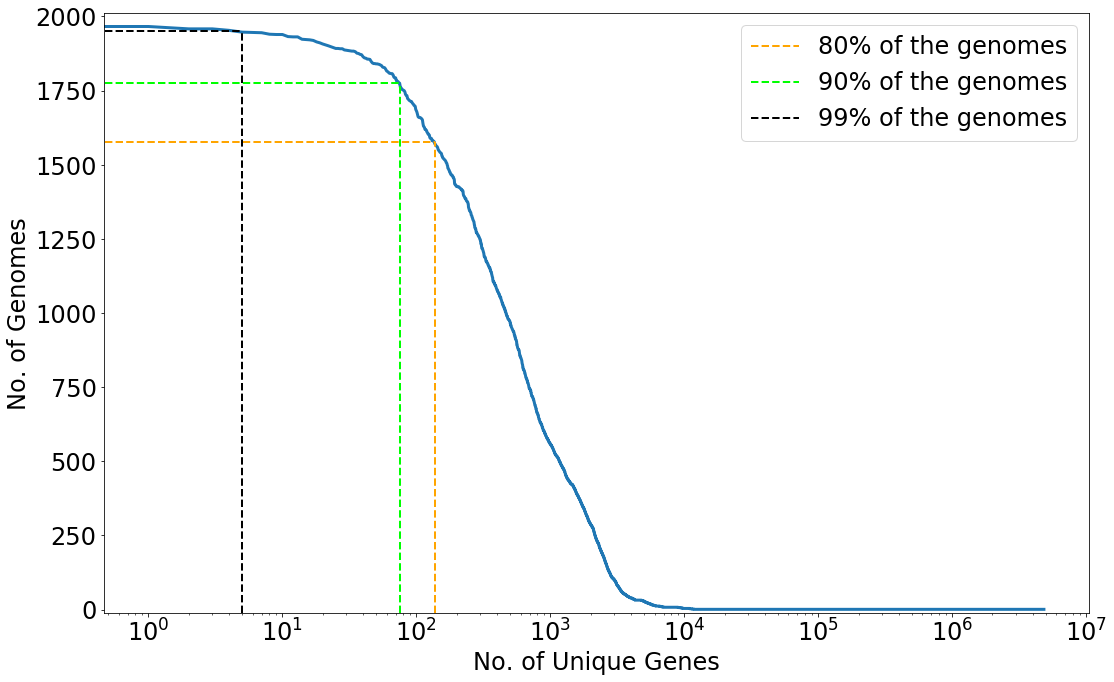

In [6]:
plt.rcParams.update(rcParams)

num_genomes = len(gene_orders)
df_Gene_Counts = df_Gene_Counts.sort_values(by = 'Counts', ascending = False)
genes_of_interest = df_Gene_Counts.loc[df_Gene_Counts['Counts'] >= 0.8*num_genomes].index.tolist()

fig, ax = plt.subplots(1,1,figsize = (16,10))
ax.plot(df_Gene_Counts['Counts'],  linewidth = 3, label = "")
ax.set_xscale('log')

t = len(df_Gene_Counts[df_Gene_Counts['Counts'] >= 0.8*num_genomes])
ax.plot([-10, t], [0.8*num_genomes, 0.8*num_genomes], color = 'orange', linewidth = 2, linestyle = '--')
ax.plot([t, t], [-10, 0.8*num_genomes], color = 'orange', linewidth = 2, linestyle = '--', 
        label = '80% of the genomes')
print(t)
t = len(df_Gene_Counts[df_Gene_Counts['Counts'] >= 0.9*num_genomes])
ax.plot([-10, t], [0.9*num_genomes, 0.9*num_genomes], color = 'lime', linewidth = 2, linestyle = '--')
ax.plot([t, t], [-10, 0.9*num_genomes], color = 'lime', linewidth = 2, linestyle = '--',
       label = '90% of the genomes')

t = len(df_Gene_Counts[df_Gene_Counts['Counts'] >= 0.99*num_genomes])
ax.plot([-10, t], [0.99*num_genomes, 0.99*num_genomes], color = 'black', linewidth = 2, linestyle = '--')
ax.plot([t, t], [-10, 0.99*num_genomes], color = 'black', linewidth = 2, linestyle = '--', 
       label = '99% of the genomes')

ax.legend()
ax.set_xlabel('No. of Unique Genes')
ax.set_ylabel('No. of Genomes')
ax.set_ylim([-10,2010])
fig.tight_layout()
fig.savefig('../Plots/Unique_Gene_Counts.pdf')

      Counts Multi_Copies Single_Copies  \
Gene                                      
tuf     1958         1036           922   
map     1838          755          1083   
lpdA    1793          747          1046   
trxA    1931          616          1315   
lepB    1901          595          1306   
...      ...          ...           ...   
mutS  1659.0          0.0        1659.0   
der   1914.0          0.0        1914.0   
ffh   1939.0          0.0        1939.0   
ftsY  1931.0          0.0        1931.0   
rpsT  1659.0          0.0        1659.0   

                                    Genome_Multi_Copies  
Gene                                                     
tuf   [GCF_005160405.1_ASM516040v1, GCF_000754345.1_...  
map   [GCF_000754345.1_ASM75434v1, GCF_002224525.1_A...  
lpdA  [GCF_001929095.2_ASM192909v2, GCF_002224525.1_...  
trxA  [GCF_001929095.2_ASM192909v2, GCF_002224525.1_...  
lepB  [GCF_900475675.1_45473_D02, GCF_002151465.1_AS...  
...                               

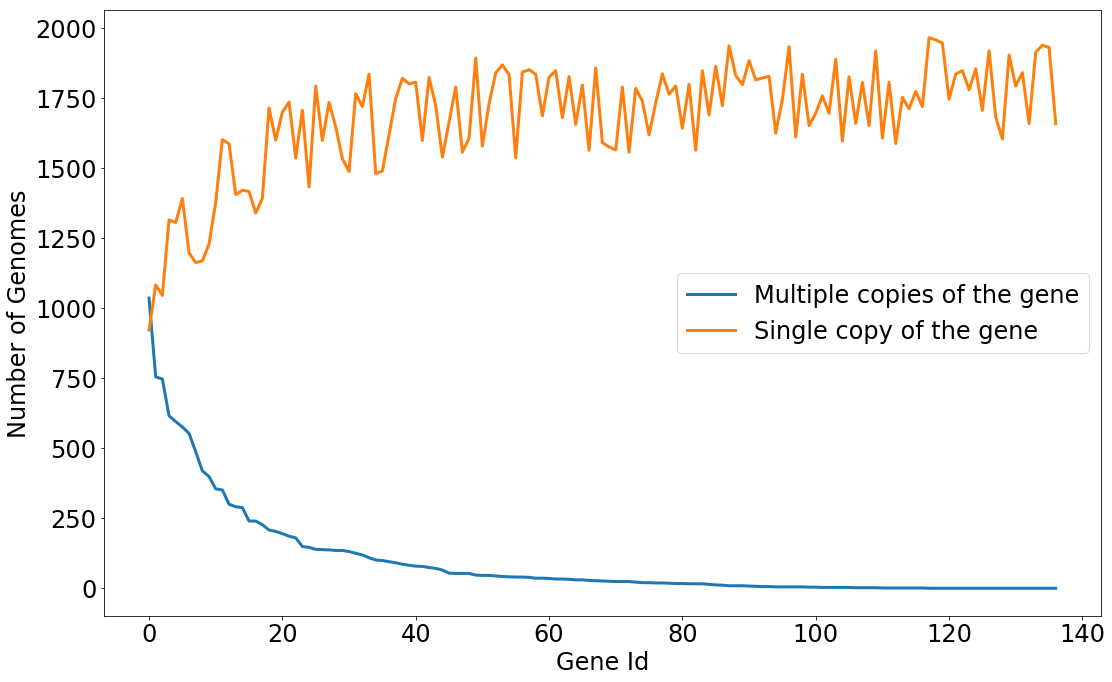

In [7]:
df_core_genes = df_Gene_Counts.loc[genes_of_interest]
df_core_genes = df_core_genes.sort_values(by = ['Multi_Copies'], ascending = 0)
print(df_core_genes)
fig,ax = plt.subplots(1,1,figsize = (16,10))
df_core_genes[['Multi_Copies','Single_Copies']].reset_index().plot(ax = ax, linewidth = 3)
ax.legend(['Multiple copies of the gene','Single copy of the gene'])
ax.set_xlabel('Gene Id')
ax.set_ylabel('Number of Genomes')
fig.tight_layout()
fig.savefig('../Plots/Single_Copy_Genes.pdf')

In [8]:
min_genome_count = 20
df_filter = df_core_genes[df_core_genes['Multi_Copies'] < min_genome_count]
core_genes = df_filter.index.tolist()
print(df_filter)
unique_genomes = set()
genome_counts = []
for i in range(0, len(df_filter)):
    if df_filter.iloc[i]['Multi_Copies'] > 0:
        genomes = df_filter.iloc[i]['Genome_Multi_Copies']
        unique_genomes = unique_genomes.union(set(genomes))
        genome_counts.append(len(unique_genomes))
        
print(core_genes)

      Counts Multi_Copies Single_Copies  \
Gene                                      
yajC    1753           19          1734   
pgsA    1856           19          1837   
tsaD    1782           18          1764   
uvrB    1811           17          1794   
grpE    1659           17          1642   
...      ...          ...           ...   
mutS  1659.0          0.0        1659.0   
der   1914.0          0.0        1914.0   
ffh   1939.0          0.0        1939.0   
ftsY  1931.0          0.0        1931.0   
rpsT  1659.0          0.0        1659.0   

                                    Genome_Multi_Copies  
Gene                                                     
yajC  [GCF_020139255.1_ASM2013925v1, GCF_016026695.1...  
pgsA  [GCF_004006435.1_ASM400643v1, GCF_003665315.1_...  
tsaD  [GCF_015767795.1_ASM1576779v1, GCF_016906245.1...  
uvrB  [GCF_013462275.1_ASM1346227v1, GCF_003260185.2...  
grpE  [GCF_020139255.1_ASM2013925v1, GCF_900097255.1...  
...                               

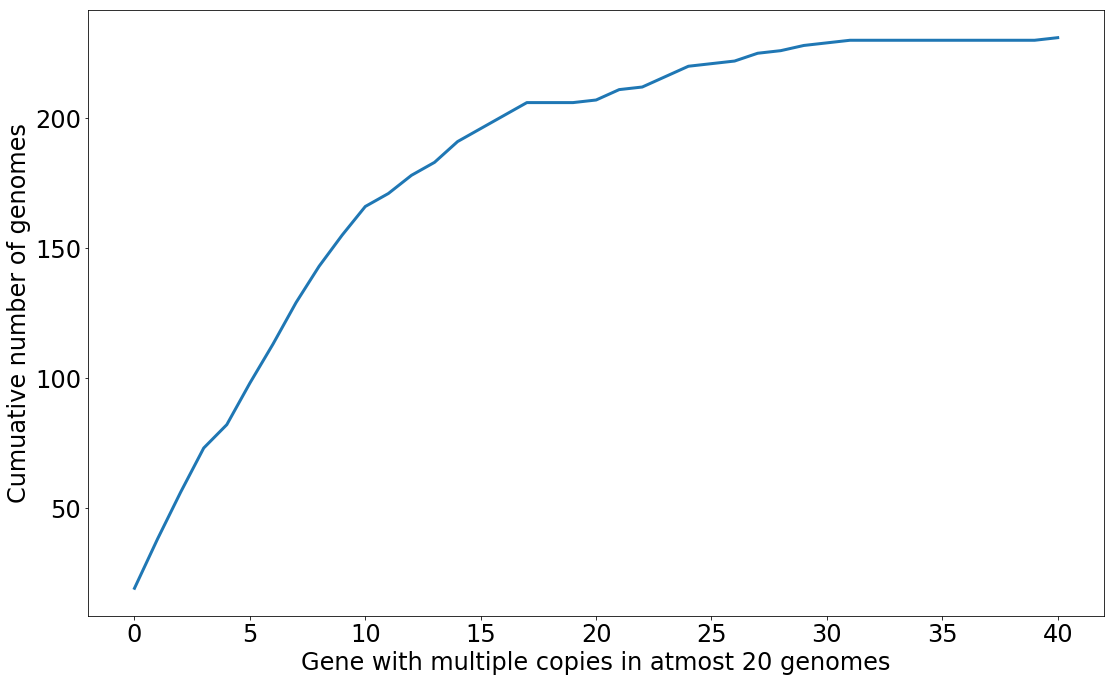

In [9]:
fig, ax = plt.subplots(1,1,figsize = (16,10))
ax.plot(genome_counts, linewidth=3)
ax.set_xlabel('Gene with multiple copies in atmost 20 genomes')
ax.set_ylabel('Cumuative number of genomes')
fig.tight_layout()
fig.savefig('../Plots/Filtering_Genomes.pdf')

In [10]:
core_genomes = []
for g in gene_orders:
    if g not in unique_genomes:
        core_genomes.append(g)
print(len(core_genomes))

1740


In [11]:
core_gene_genomes = {}
accessory_gene_genomes = {}
max_core_gene_count = 0
max_core_gene_set = []
temp = []
for genome in core_genomes:
    all_genes = gene_orders[genome][0]
    mask = gene_orders[genome][1]
    filter_genes = all_genes[np.sort(np.where(mask == True)[0])]
    core_gene_set = []
    accessory_gene_set = []
    for g in filter_genes:
        if g in core_genes:
            core_gene_set.append(g)
        else:
            accessory_gene_set.append(g)
    if len(core_gene_set) < 0.9*len(core_genes):
        continue
    temp.append(len(core_gene_set))
    core_gene_genomes[genome] = core_gene_set
    accessory_gene_genomes[genome] = accessory_gene_set
    if len(core_gene_set) > max_core_gene_count:
        max_core_gene_count = len(core_gene_set)
        max_core_gene_set = core_gene_set
        

In [12]:
ctr = 0
core_gene_to_int = {}
for g in max_core_gene_set:
    core_gene_to_int[g] = ctr
    ctr += 1
    

In [13]:
gene_int_mat = []
genome_list = []
for g in core_gene_genomes:
    genome_list.append(g)
    genes = core_gene_genomes[g]
    ids = []
    for g in core_genes:
        if g in genes:
            ids.append(+1)
        else:
            ids.append(0)
    gene_int_mat.append(ids)

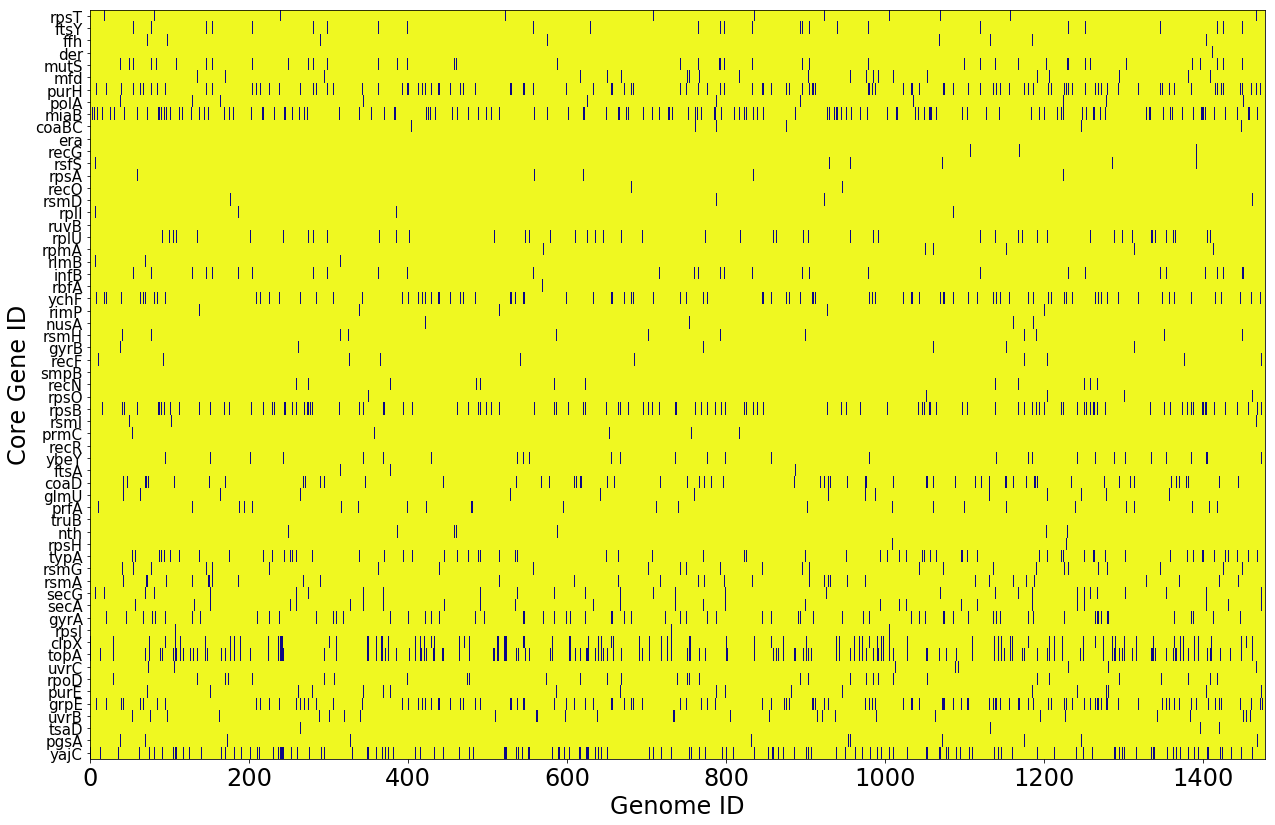

In [14]:
fig,ax = plt.subplots(1,1,figsize = (18,12))
ax.imshow(np.array(gene_int_mat).T, cmap = 'plasma',aspect='auto', alpha = 1)
ax.set_xlabel('Genome ID')
ax.set_ylabel('Core Gene ID')
fig.tight_layout()
ax.set_yticks(range(len(core_genes)))
ax.set_yticklabels(core_genes[::-1], size = 15)
fig.savefig('../Plots/Presence_Absence_Core_Genes.pdf')

In [13]:
fbuf = open('UMD_Coursework/Fall_2021/CMSC829A/Project/Data/Core_Genes.txt','w')
fbuf.write(str(core_gene_genomes))
fbuf.close()

In [14]:
fbuf = open('UMD_Coursework/Fall_2021/CMSC829A/Project/Data/Accessory_Genes.txt','w')
fbuf.write(str(accessory_gene_genomes))
fbuf.close()

In [15]:
fbuf = open('UMD_Coursework/Fall_2021/CMSC829A/Project/Data/Core_Genes_List.txt','w')
fbuf.write(str(core_genes))
fbuf.close()

In [19]:
fbuf = open('UMD_Coursework/Fall_2021/CMSC829A/Projeor s in /Data/Core_Genome_List.txt','w')
fbuf.write(str(list(core_gene_genomes.keys())))
fbuf.close()

In [15]:
mat = []
for s1 in gene_int_mat:
    vec = []
    for s2 in gene_int_mat:
        d = np.abs(np.array(s1)-np.array(s2))
        vec.append(d.sum()/len(s1))
    mat.append(vec)
        
dist_mat = np.array(mat)
print(np.mean(dist_mat))

0.04676901452902662


/Users/harihara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


1478


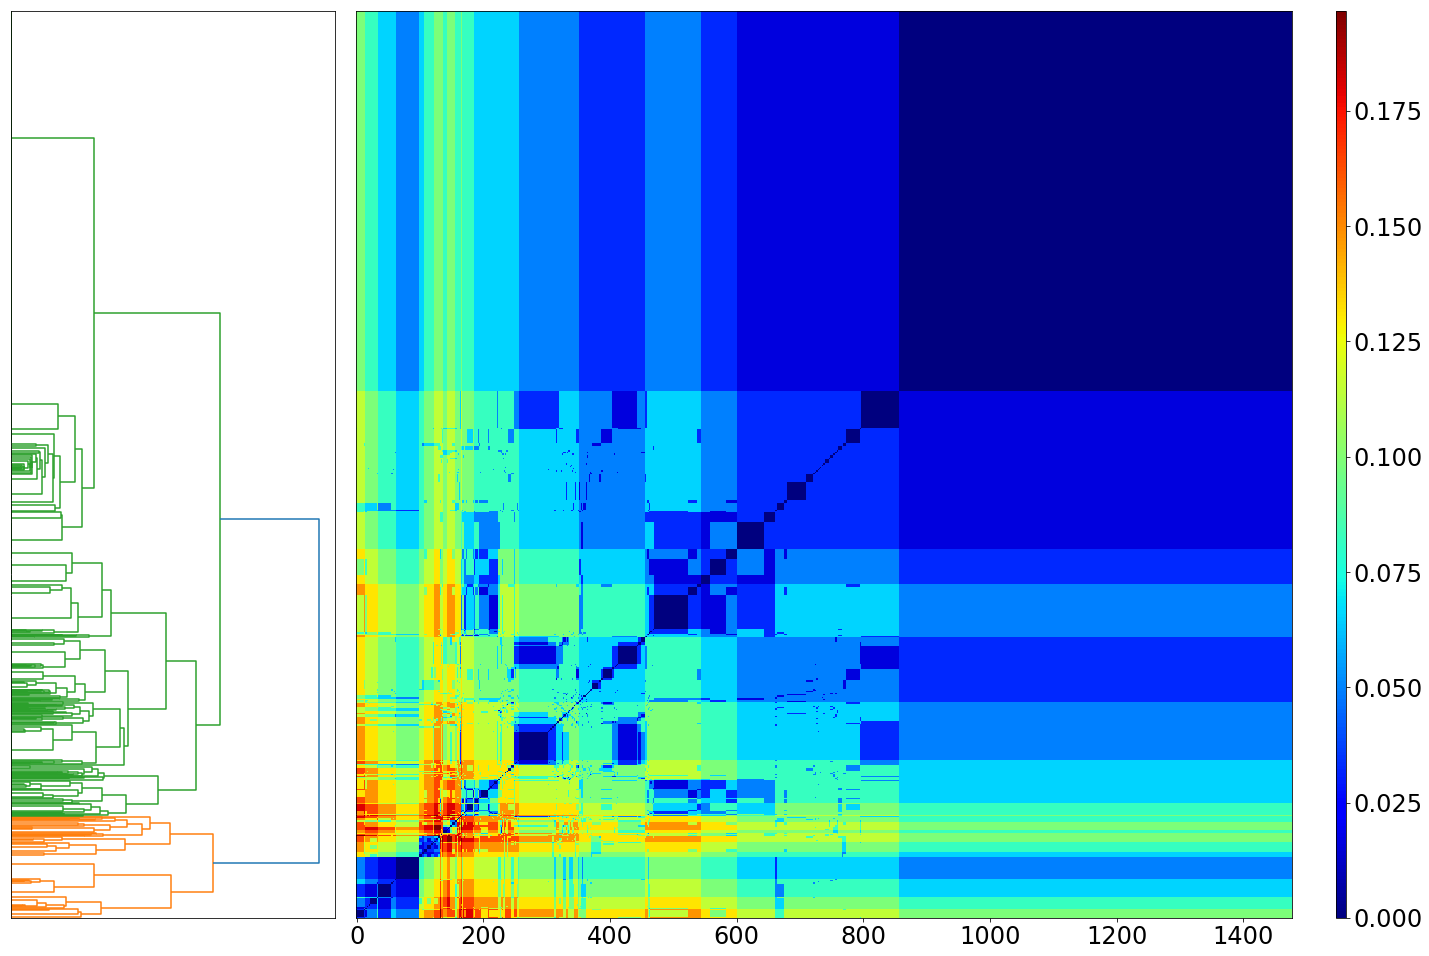

In [47]:

plt.rcParams.update(rcParams)

MAT = deepcopy(dist_mat)
Y = sch.linkage(MAT, method='average',optimal_ordering=True)
fig = plt.figure(figsize=(20,14))
axdendro = fig.add_axes([0.01,0.05,0.225,0.90])
Z = sch.dendrogram(Y, orientation='right', color_threshold = 1*max(Y[:,2]))
index = Z['leaves']
print(len(index))
axdendro.set_xticks([])
axdendro.set_yticks([])
c, cophenet_dist = sch.cophenet(Y, squareform(MAT))

axmatrix = fig.add_axes([0.250,0.05,0.65,0.90])

MAT = MAT[index,:]
MAT = MAT[:,index]
im = axmatrix.imshow(MAT, aspect='auto', origin='lower', cmap = 'jet')
axmatrix.set_yticks([])

axcolor = fig.add_axes([0.93,0.05,0.0075,0.90])
plt.colorbar(im, cax=axcolor)
fig.tight_layout()
fig.savefig('../Plots/Core_Genes_Prescence_Absence_Clusters.pdf')

In [48]:
c

0.8027325991899749